In [1]:
import numpy as np
from scipy import stats

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd

In [2]:
import nest_asyncio # https://pystan.readthedocs.io/en/latest/faq.html
nest_asyncio.apply()

In [3]:
import stan
import arviz as az # For visualization and leave one out cross validation (loo)

# We're going to fit the following statistical ("hierarchical") model

There are $N$ data points, each of which is associated with one of $k$ types.

We suppose the outcome is:
$$ y_i \sim Normal(\beta^{k(i)} \cdot x_i, \sigma^2) $$

Where $k(i)$ refers to the type of data point $i$. (i.e., a standard linear regression within each type.)

**Hierarchy**: We want to capture the following: The types are not completely unrelated and so we want to borrow information from across types especially in low data settings, but we also want to allow for the types being different and so having different parameters. 

Mathematically, we are going to say that each dimension $j$ of $\beta^{k(i)}$ is drawn from a normal distribution centered around some (unknown) overall mean:

$$\beta^{k(i)}_j \sim Normal(\beta_j, \Sigma)$$

Where $\beta_j$ (and potentiall $\Sigma$) are also learned parameters of the model, for example with priors:
$$\beta_j \sim Normal(0, 5)$$
 

(In practice, they recommend different priors and hyperpriors, see: https://mc-stan.org/docs/stan-users-guide/multivariate-hierarchical-priors.html)

Note: This is similar to having interaction terms between the betas and a type-indicator and then regularizing in a standard machine learning setting; however, Bayesian models allow for easy fitting of more general relationships...see this blog post I wrote many years ago when I was first learning Stan/Bayesian modeling: https://medium.com/@nikhil_garg/hierarchical-bayes-and-stan-tutorial-example-7df7d4d5193. 

**Question: what are data generating processes that would be consistent with the above?**

# Let's generate data from such a model

In [4]:
def draw_parameters_from_setting(n_locations, n_features, datapoints_per_location_min, beta_overall, do_bad_location, bad_location_is_low_data, datapoints_per_location_max = 300):
    datapoints_per_location_max = max(datapoints_per_location_max, datapoints_per_location_min*10)
    #draw beta for each location using normal distribution with mean beta_overall and standard deviation .5
    betas_k = np.random.normal(loc = beta_overall, scale = .5, size = (n_locations, n_features))
    number_datapoints_per_location = [int(x) for x in (np.linspace(datapoints_per_location_min, datapoints_per_location_max, n_locations))]
    # np.random.randint(low = datapoints_per_location_min, high = 100, size = n_locations)
    
    
    if do_bad_location:
        betas_k[-1] = np.array([-15, 15])
        if bad_location_is_low_data:
            number_datapoints_per_location[-1] = datapoints_per_location_min
        else:
            number_datapoints_per_location[-1] = 100
    return betas_k, number_datapoints_per_location

In [5]:
n_locations = 5 # k 
n_features = 1 # dimension of x 
datapoints_per_location_min = 20

beta_overall = [4]#, 1] #overall slope terms \beta
sigma = .1

#do we have a bad location that is far from the others?
do_bad_location = False
bad_location_is_low_data = False

In [6]:
betas_k, number_datapoints_per_location  = draw_parameters_from_setting(
    n_locations, n_features, datapoints_per_location_min, beta_overall, do_bad_location, bad_location_is_low_data)
betas_k

array([[3.20073637],
       [3.61063438],
       [4.12723506],
       [5.20611324],
       [4.46279125]])

In [7]:
number_datapoints_per_location

[20, 90, 160, 230, 300]

In [8]:
def draw_samples_from_model(betas_k, number_datapoints_per_location, test_set_samples_per_location = 200, sigma = .1):
    #draw samples from model
    # samples = []
    ys = []
    features = []
    location_index = []
    
    test_set_ys = []
    test_set_features = []
    test_set_location_indices = []
    for k in range(len(number_datapoints_per_location)): #number of types       
        #draw x from a absolute value of normal distribution with mean 0 and variance .1
        # Note, our model isn't make any assumptions about X, so we can draw from any distribution we want
        x = np.abs(np.random.normal(loc = 0, scale = .1, size = (number_datapoints_per_location[k], n_features)))
        #draw y from normal distribution with mean beta*x and variance .2
        y = np.random.normal(loc = np.dot(x, betas_k[k]), scale = sigma, size = number_datapoints_per_location[k])
        ys.extend(y)
        features.extend(x)
        location_index.extend([k + 1]*number_datapoints_per_location[k]) # +1 because stan is 1 indexed
        
        # repeat for test set
        x_test_set = np.abs(np.random.normal(loc = 0, scale = .1, size = (test_set_samples_per_location, n_features)))
        y_test_set = np.random.normal(loc = np.dot(x_test_set, betas_k[k]), scale = .2, size = test_set_samples_per_location)
        test_set_ys.extend(y_test_set)
        test_set_features.extend(x_test_set)
        test_set_location_indices.extend([k + 1]*test_set_samples_per_location) # +1 because stan is 1 indexed
        
    return {'y': ys, 'X': features, 'types' : location_index, 'N': len(ys), 'Nattr': n_features, 'X_test': test_set_features, 'y_test': test_set_ys, 'types_test' : test_set_location_indices, 'N_test': len(test_set_ys), 'N_types': len(number_datapoints_per_location)}

In [9]:
data_dict = draw_samples_from_model(betas_k, number_datapoints_per_location, sigma = sigma)
data_dict

{'y': [0.3383177716530066,
  0.261310248937546,
  0.17994393139313536,
  0.08707681504406467,
  0.09796378738878625,
  0.14282113383950082,
  0.24986332194056732,
  0.3136888055653727,
  0.02358521728301881,
  0.453839699311882,
  0.0007872218836631195,
  0.23407907910507653,
  0.3252245451554014,
  0.2938505118686391,
  0.25213062489982474,
  0.31868085357319587,
  0.17519383155269302,
  0.31322017401554203,
  0.048631575203441614,
  0.12711545087060055,
  -0.05184194414756918,
  -0.08502820475808162,
  -0.02017972938221496,
  0.47009174243216556,
  0.653010885383592,
  0.16002348992405216,
  0.21147157787694876,
  0.8118287701001521,
  0.6448751853825281,
  0.14102211967393136,
  0.10457826515775462,
  0.30516760406226434,
  0.4855056220510906,
  0.08530824251569369,
  0.08522247797093693,
  0.40355502705376706,
  0.11429853110037465,
  0.25911136839123994,
  0.23939617586013312,
  0.8022444070880447,
  0.024356392784064637,
  0.279522245931179,
  0.43421664580905395,
  0.89012395494

<AxesSubplot: xlabel='y', ylabel='Density'>

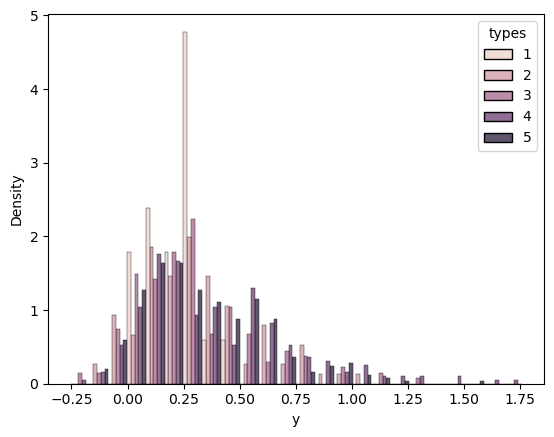

In [10]:
df = pd.DataFrame({'y': data_dict['y'], 'types': data_dict['types']})
sns.histplot(data = df, x = 'y', hue = 'types', stat = 'density', common_norm = False, multiple = 'dodge')

In [11]:
def get_arviz_data(fit, compiled_model = None, model_data=None):  
    dataaz = az.from_pystan(posterior=fit, posterior_model=compiled_model
                            , posterior_predictive='yposterior_pred' #variable that contains the posterior predictive samples
                            , observed_data = model_data
                            , predictions = 'y_testset_pred' #variable that contains the test set predictions
                            , predictions_constant_data = 'X_test' # variable that contains the test set features
                            )
    return dataaz

# Fit a linear regression ignoring hierarchy

### With enough samples

In [12]:
stan_data = draw_samples_from_model(betas_k, number_datapoints_per_location)

In [13]:
stan_folder = 'stan_code/'
stan_file = stan_folder + 'linear_regression.stan'
with open(stan_file) as file:
    model_code = file.read()
print(model_code)

data {
    int<lower=0> N;
    int<lower=1> Nattr; // number of covariates
    matrix[N,Nattr] X;  
    array[N] real y;

    int<lower=0> N_test;
    matrix[N_test,Nattr] X_test;  
}

transformed data {
   /* ... declarations ... statements ... */
}

parameters {
    vector[Nattr] beta;  // attribute effects
    real <lower=0> sigma; // standard deviation of the noise
}

transformed parameters {
    // real <lower=0> sigmasquared = sigma*sigma; // variance of the noise
   /* ... declarations ... statements ... */
}

model {
    // Priors
    // beta ~ normal(0, 10);
    sigma ~ normal(0, 10);

    // Likelihood
    y ~ normal(X*beta, sigma);
}

generated quantities {
    # this is drawing samples from the posterior predictive distribution, so that we can check the fit
    array[N] real yposterior_pred;
    yposterior_pred = normal_rng(X*beta, sigma);
    // this will produce at the end a matrix of size N x #_of_iterations, that are samples of y, called posterior predictive distributio

In [14]:
compiled_model = stan.build(model_code, data=stan_data, random_seed=1)

Building...

In file included from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/boost/multi_array/multi_array_ref.hpp:32,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/boost/multi_array.hpp:34,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/boost/numeric/odeint/algebra/multi_array_algebra.hpp:22,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/boost/numeric/odeint.hpp:63,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/ode_rk45.hpp:9,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/integrate_ode_rk45.hpp:6,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor.hpp:14,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include


Building: 30.3s, done.Messages from stanc:
Warning in '/tmp/httpstan_avohbnux/model_jezxo4dp.stan', line 35, column 4: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
Warning in '/tmp/httpstan_avohbnux/model_jezxo4dp.stan', line 40, column 4: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [15]:
fit = compiled_model.sample(num_chains=2, num_warmup = 200, num_samples= 1000)

Sampling:   0%
Sampling:  50% (1200/2400)
Sampling: 100% (2400/2400)
Sampling: 100% (2400/2400), done.
Messages received during sampling:
  Gradient evaluation took 5.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.49 seconds.
  Adjust your expectations accordingly!


In [16]:
idata = idata = get_arviz_data(fit, compiled_model = compiled_model, model_data = stan_data)
summary = az.summary(fit, var_names = ['beta', 'sigma'])
summary

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]  4.576  0.039   4.499    4.647      0.001    0.001    2103.0   
sigma    0.113  0.003   0.108    0.119      0.000    0.000    1656.0   

         ess_tail  r_hat  
beta[0]    1439.0    1.0  
sigma      1316.0    1.0

In [17]:
# ground truth:
betas_k, sigma

(array([[3.20073637],
        [3.61063438],
        [4.12723506],
        [5.20611324],
        [4.46279125]]),
 0.1)

In [18]:
def plot_residuals_by_type(stan_data, fit):
    y_test_predictions = fit['y_testset_pred'] # this is shape (N_test, num_samples = num_chains * num_samples_per_chain)
    #I want one prediction per test point, so I take the mean of the predictions
    y_test_predictions_mean = np.mean(y_test_predictions, axis = 1).flatten().tolist()
    
    y_test = stan_data['y_test']
    types_test = stan_data['types_test']
    
    # print(np.shape(y_test_predictions_mean))
    n_features = stan_data['Nattr']
    df = pd.DataFrame({'y_test': y_test, 'y_test_predictions': y_test_predictions_mean, 'types_test': types_test})
    df['residuals'] = df['y_test'] - df['y_test_predictions']
    for feat in range(n_features):
        df.loc[:,f'x{feat}'] = list(np.array(np.matrix(stan_data['X_test'])[:, feat].flatten())[0])
        sns.lmplot(data = df, x = f'x{feat}', y = 'residuals', fit_reg = True, hue = 'types_test')
        sns.regplot(data = df, x = f'x{feat}', y = 'residuals', scatter = False, color = 'teal')   
        plt.show()
    return df
    
def check_calibration_by_type(stan_data, fit):
    y_test_predictions = fit['y_testset_pred'] # this is shape (N_test, num_samples = num_chains * num_samples_per_chain)
    #I want one prediction per test point, so I take the mean of the predictions
    y_test_predictions_mean = np.mean(y_test_predictions, axis = 1).flatten().tolist()   
    y_test = stan_data['y_test']
    types_test = stan_data['types_test']
    df = pd.DataFrame({'y_test': y_test, 'y_test_predictions': y_test_predictions_mean, 'types_test': types_test})
    print(df.groupby('types_test').mean())
    
def plot_stuff_about_model(idata, stan_data, fit, var_names = ['beta', 'sigma']):
    print ('CONVERGENCE CHECKS')
    az.plot_trace(idata, var_names=var_names)
    plt.show()
    
    az.plot_rank(idata)
    plt.show()
    
    az.plot_autocorr(idata, var_names=var_names)
    
    # Plot local ESS. This plot, together with the quantile ESS plot, is recommended to check that there are enough samples for all the explored regions of parameter space. Checking local and quantile ESS is particularly relevant when working with HDI intervals as opposed to ESS bulk, which is relevant for point estimates.
    # https://python.arviz.org/en/stable/api/generated/arviz.plot_ess.html  
    az.plot_ess(idata)
    plt.show()
    
    # Plot ESS evolution as the number of samples increase. When the model is converging properly, both lines in this plot should be roughly linear.
    az.plot_ess(idata, kind='evolution')
    plt.show()
    
    print('IS THE MODEL GOOD?')
    az.plot_pair(idata)
    plt.show()
    
    # Posterior predictive
    az.plot_ppc(idata, data_pairs = {'y': 'yposterior_pred'}, var_names = ['y'], num_pp_samples = 100)
    plt.show()
    
    # # Plot Bayesian p-value for observed data and Posterior/Prior predictive.
    # az.plot_bpv(idata, kind="p_value", data_pairs = {'y': 'yposterior_pred'}, var_names = ['y'])
    
    #by type posterior predictive
    df = plot_residuals_by_type(stan_data, fit)
    check_calibration_by_type(stan_data, fit)

    print("WHAT ARE THE RESULTS?")
    az.plot_forest(idata, var_names = var_names)
    plt.show()
    
    # az.plot_density(idata)
    # plt.show()
    
        


CONVERGENCE CHECKS


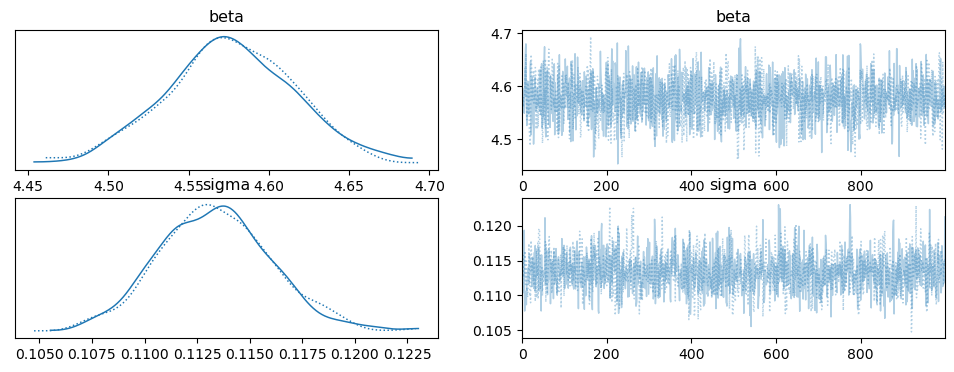

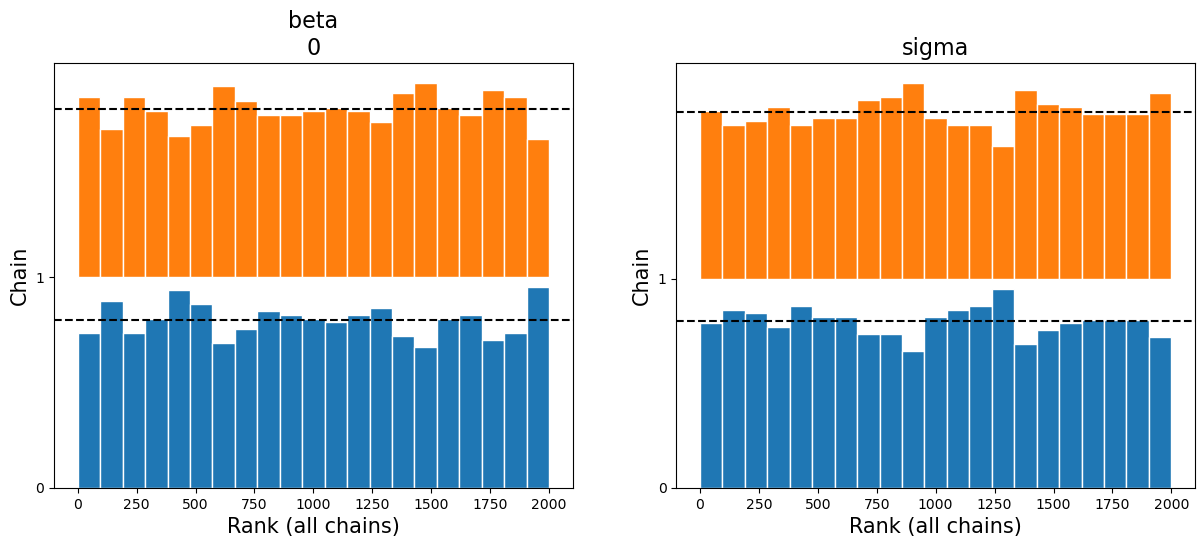

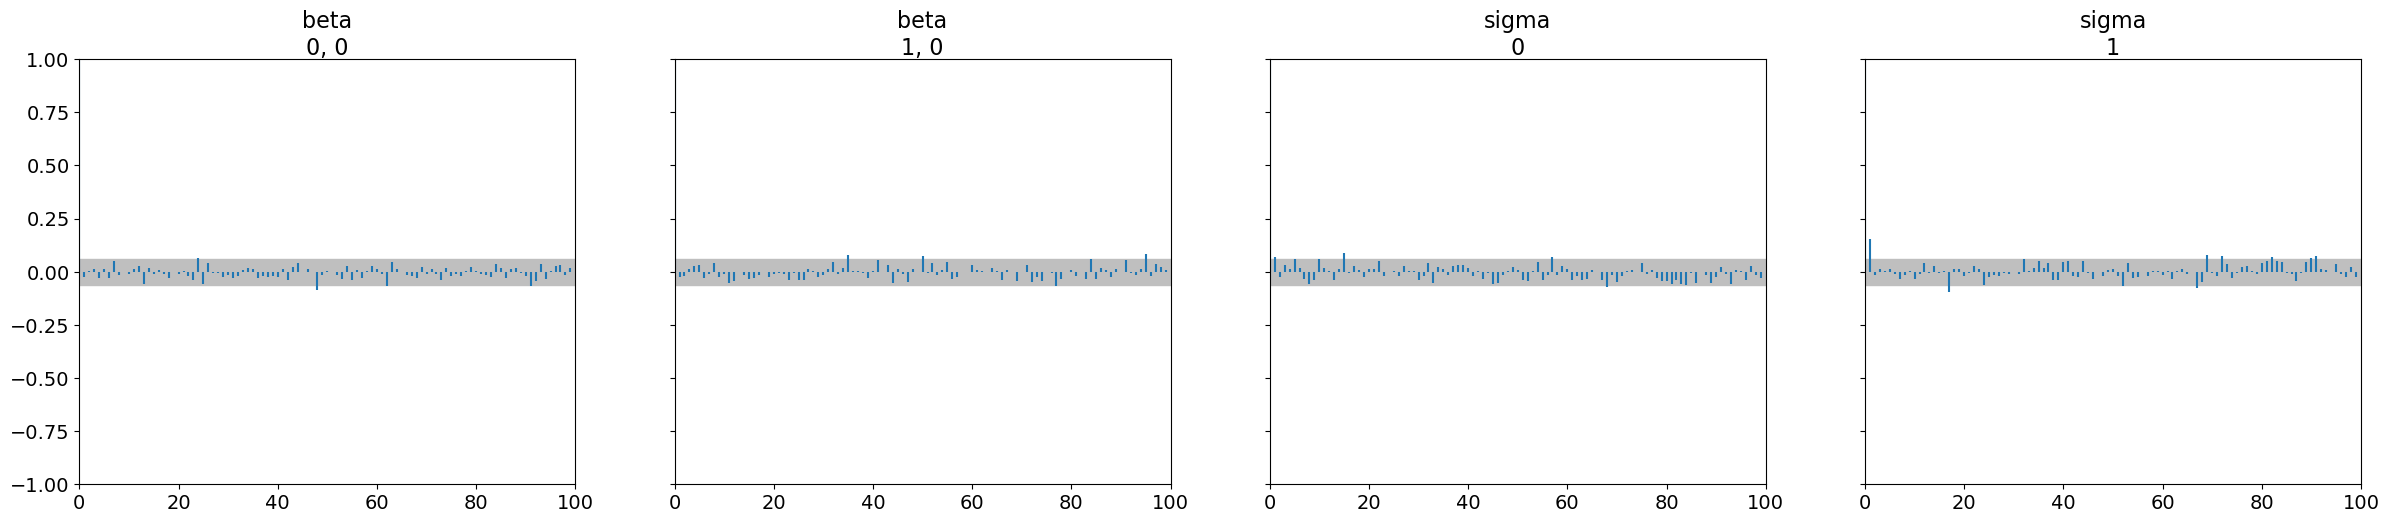

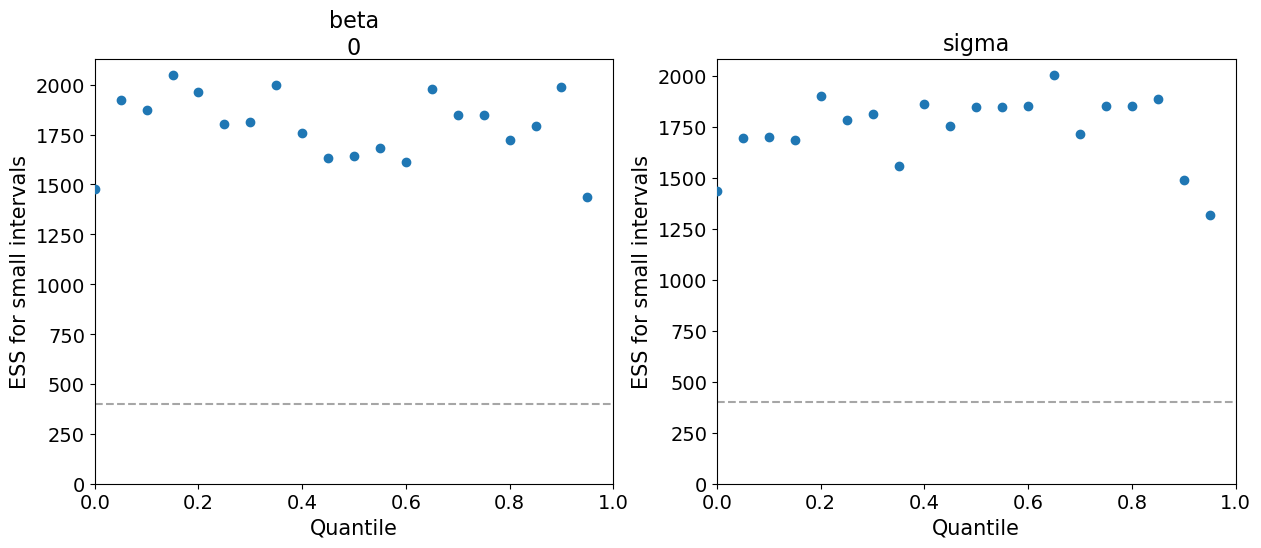

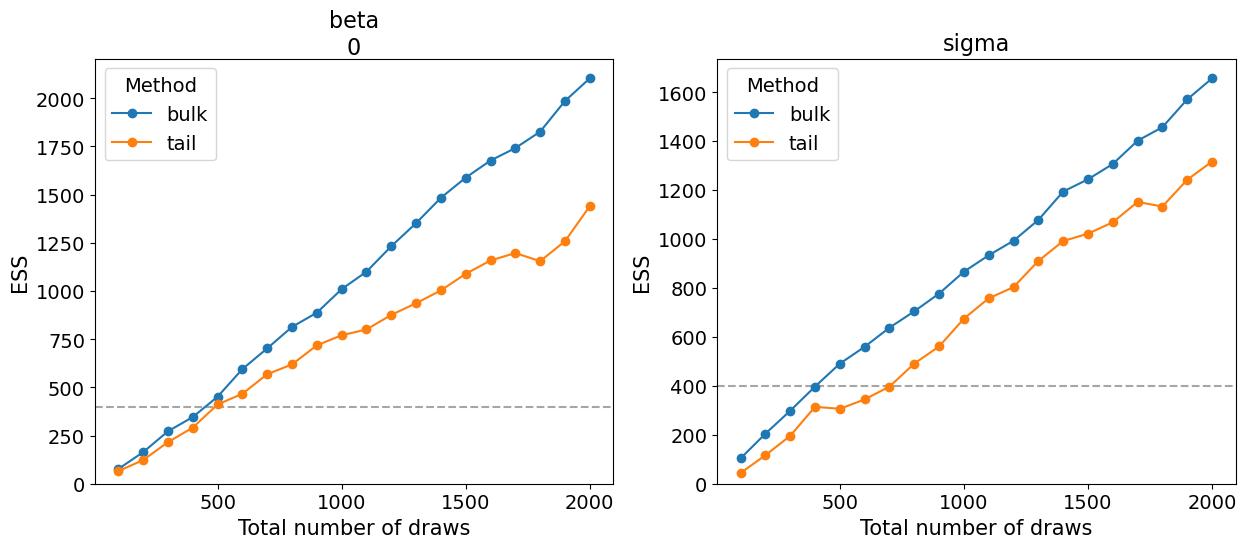

IS THE MODEL GOOD?


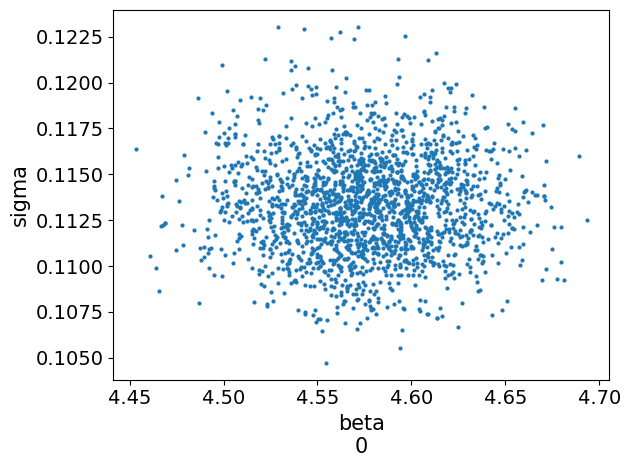

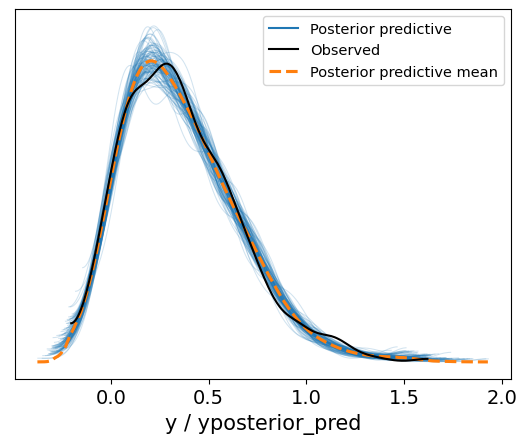

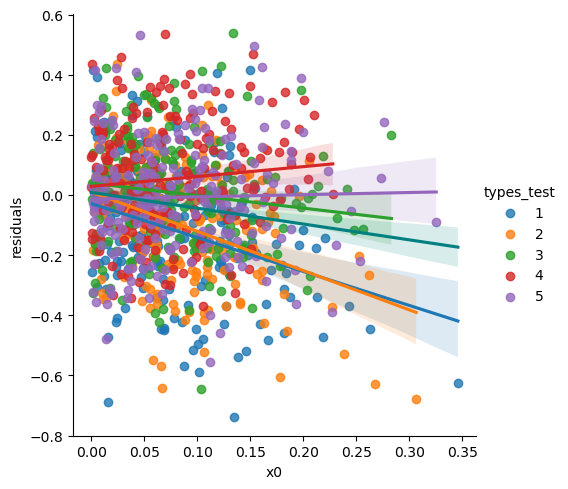

              y_test  y_test_predictions
types_test                              
1           0.253904            0.375277
2           0.276974            0.374285
3           0.381114            0.376193
4           0.392583            0.339811
5           0.362222            0.370063
WHAT ARE THE RESULTS?


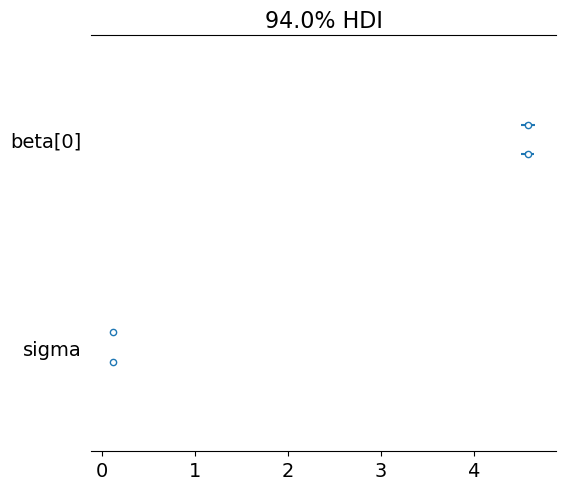

In [19]:
plot_stuff_about_model(idata, stan_data, fit)

Overall, the above checks indicate:
1. The model converged.
2. It's not quite the right model -- posterior predictive check doesn't match prior, and we're especially uncalibrated by type, and data is predictive of residuals conditional on type.

### What would the above look like if we didn't sample for long enough?

In [20]:
fit = compiled_model.sample(num_chains=2, num_warmup = 10, num_samples= 100)

Sampling:   0%
Sampling:  50% (110/220)
Sampling: 100% (220/220)
Sampling: 100% (220/220), done.
Messages received during sampling:
  Gradient evaluation took 4.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.49 seconds.
  Adjust your expectations accordingly!
           performed for num_warmup < 20
  Gradient evaluation took 6.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.68 seconds.
  Adjust your expectations accordingly!
           performed for num_warmup < 20


In [21]:
idata = idata = get_arviz_data(fit, compiled_model = compiled_model, model_data = stan_data)
summary = az.summary(fit, var_names = ['beta', 'sigma'])
summary

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]  3.936  1.461   0.419    4.751      0.479     0.35      22.0   
sigma    0.163  0.113   0.107    0.424      0.040     0.03      17.0   

         ess_tail  r_hat  
beta[0]      12.0   1.16  
sigma        12.0   1.12

In [22]:
# ground truth:
betas_k, sigma

(array([[3.20073637],
        [3.61063438],
        [4.12723506],
        [5.20611324],
        [4.46279125]]),
 0.1)

CONVERGENCE CHECKS


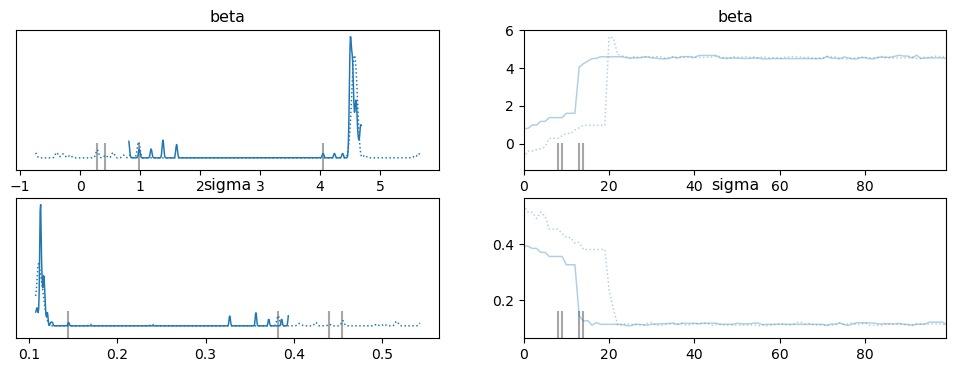

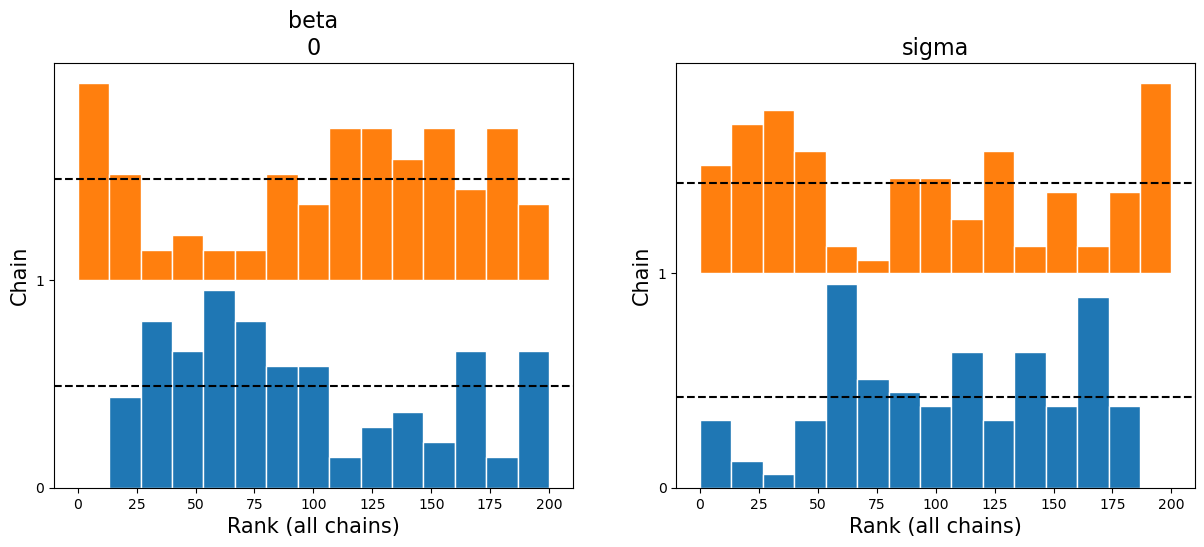

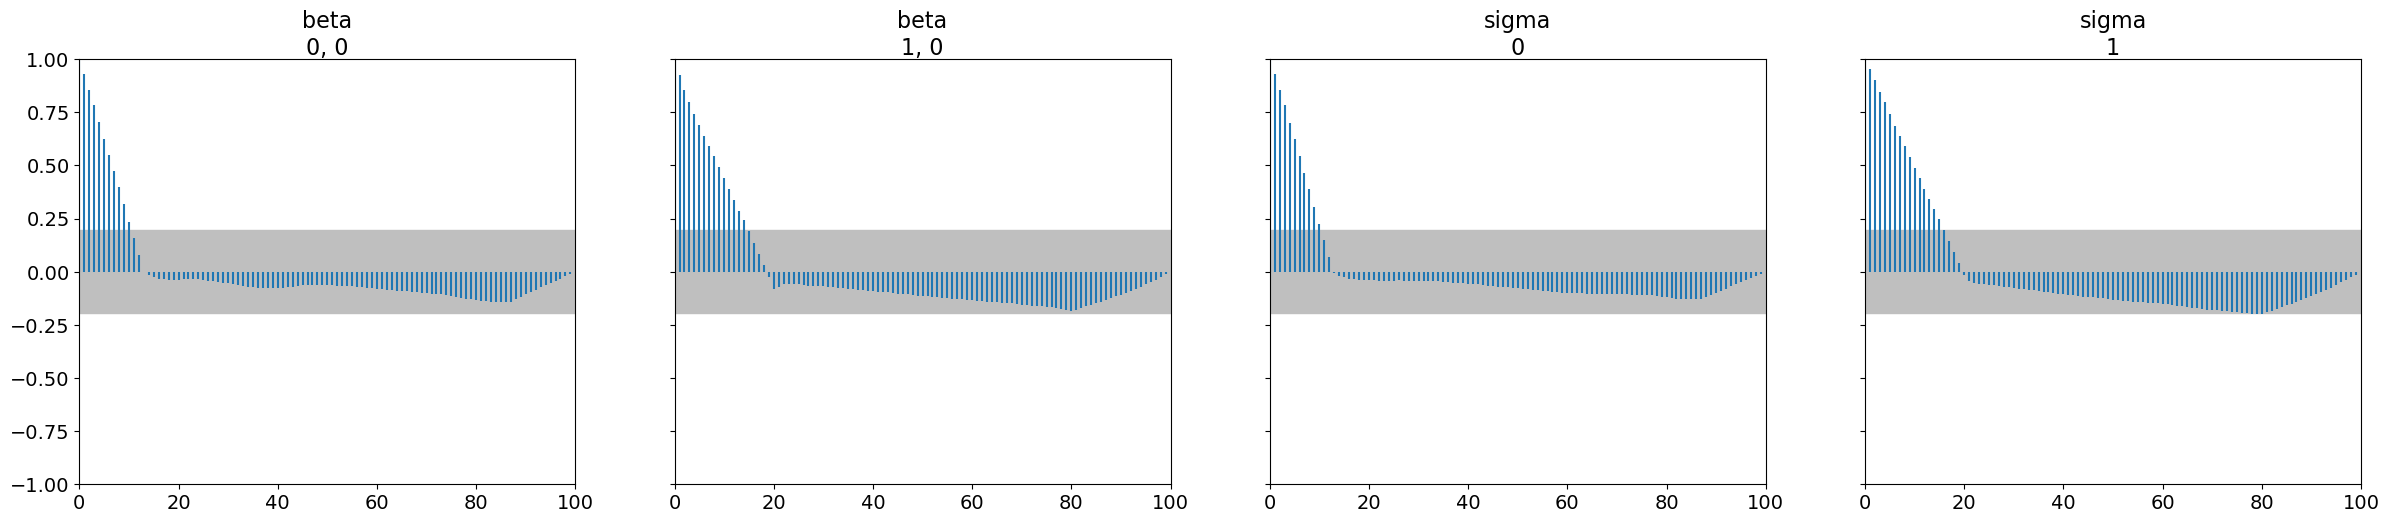

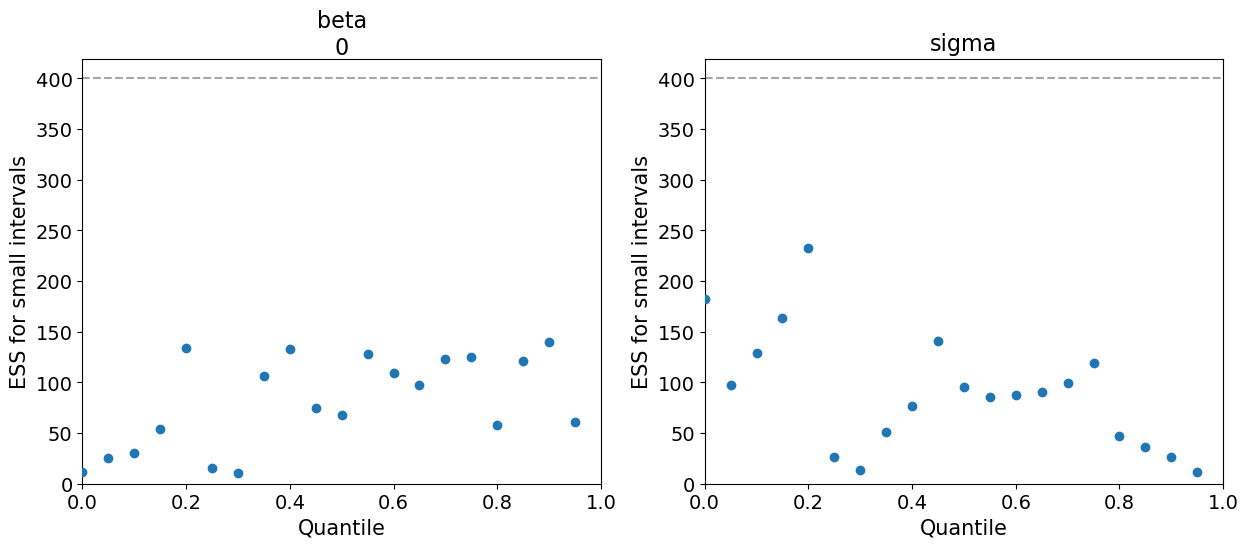

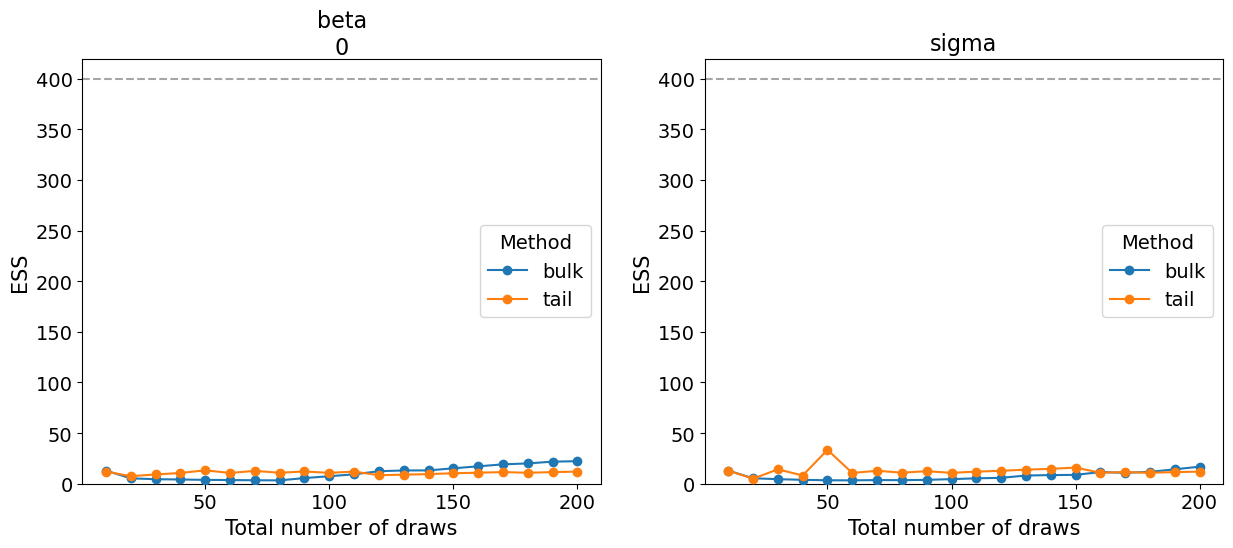

IS THE MODEL GOOD?


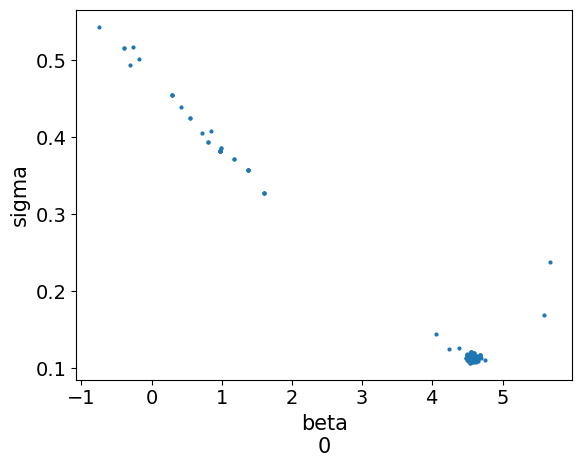

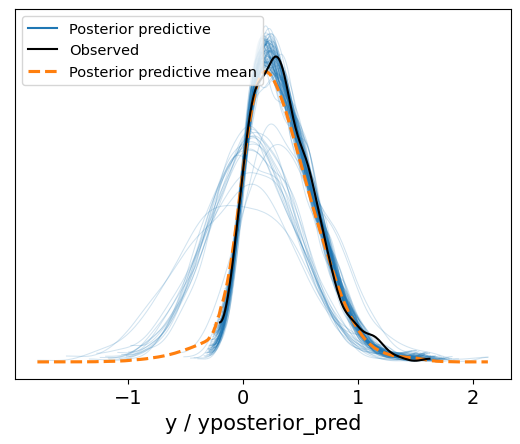

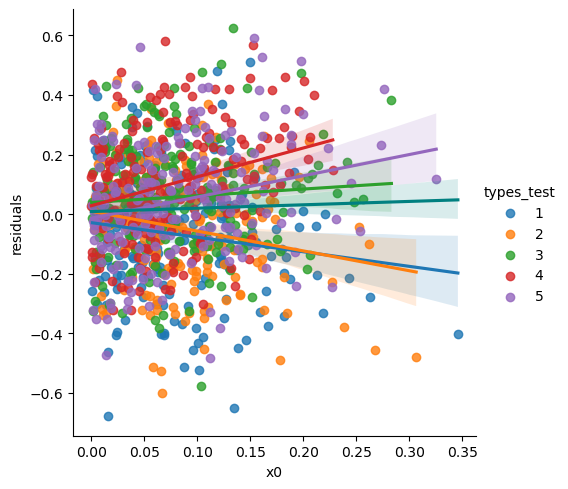

              y_test  y_test_predictions
types_test                              
1           0.253904            0.322798
2           0.276974            0.321944
3           0.381114            0.323585
4           0.392583            0.292291
5           0.362222            0.318313
WHAT ARE THE RESULTS?


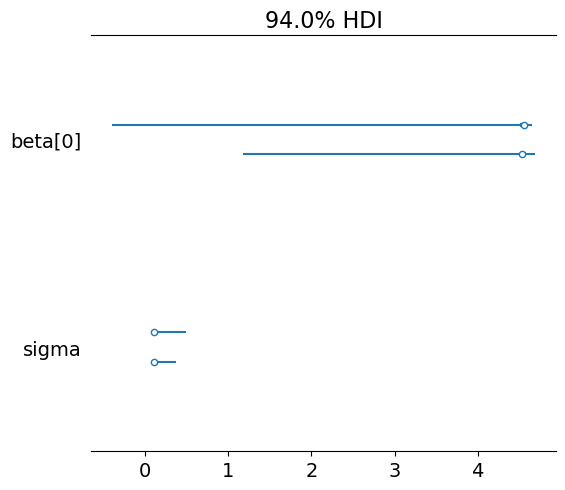

In [23]:
plot_stuff_about_model(idata, stan_data, fit)

All the checks above indicate that we just didn't sample long enough, especially warmup:
1. Rhats are high, chains are different from one another.
2. Auto-correlation at the beginning is large
3. Posterior distributions are multi-modal

### Model is even worse -- collinearity in features, so definitely not identified

In [24]:
stan_data = draw_samples_from_model(betas_k, number_datapoints_per_location)

In [25]:
# NEW -- I'm going to duplicate x1 into x2 and fit 2 features, which is bad -- there is collinearity
stan_data.keys()

dict_keys(['y', 'X', 'types', 'N', 'Nattr', 'X_test', 'y_test', 'types_test', 'N_test', 'N_types'])

In [26]:
stan_data['X'] = np.hstack((stan_data['X'], [[-x[0]] for x in stan_data['X']]))
stan_data['X_test'] = np.hstack((stan_data['X_test'], [[-x[0]] for x in stan_data['X_test']]))
stan_data['Nattr'] = 2

In [27]:
stan_folder = 'stan_code/'
stan_file = stan_folder + 'linear_regression.stan'
with open(stan_file) as file:
    model_code = file.read()
print(model_code)

data {
    int<lower=0> N;
    int<lower=1> Nattr; // number of covariates
    matrix[N,Nattr] X;  
    array[N] real y;

    int<lower=0> N_test;
    matrix[N_test,Nattr] X_test;  
}

transformed data {
   /* ... declarations ... statements ... */
}

parameters {
    vector[Nattr] beta;  // attribute effects
    real <lower=0> sigma; // standard deviation of the noise
}

transformed parameters {
    // real <lower=0> sigmasquared = sigma*sigma; // variance of the noise
   /* ... declarations ... statements ... */
}

model {
    // Priors
    // beta ~ normal(0, 10);
    sigma ~ normal(0, 10);

    // Likelihood
    y ~ normal(X*beta, sigma);
}

generated quantities {
    # this is drawing samples from the posterior predictive distribution, so that we can check the fit
    array[N] real yposterior_pred;
    yposterior_pred = normal_rng(X*beta, sigma);
    // this will produce at the end a matrix of size N x #_of_iterations, that are samples of y, called posterior predictive distributio

In [28]:
compiled_model = stan.build(model_code, data=stan_data, random_seed=1)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_avohbnux/model_jezxo4dp.stan', line 35, column 4: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
Warning in '/tmp/httpstan_avohbnux/model_jezxo4dp.stan', line 40, column 4: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [29]:
fit = compiled_model.sample(num_chains=2, num_warmup = 200, num_samples= 1000)

Sampling:   0%
Sampling:   0% (1/2400)
Sampling:   0% (2/2400)
Sampling:   4% (101/2400)
Sampling:   8% (200/2400)
Sampling:  13% (301/2400)
Sampling:  21% (501/2400)
Sampling:  25% (600/2400)
Sampling:  29% (700/2400)
Sampling:  38% (900/2400)
Sampling:  71% (1700/2400)
Sampling:  75% (1800/2400)
Sampling: 100% (2400/2400)
Sampling: 100% (2400/2400), done.
Messages received during sampling:
  Gradient evaluation took 6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.6 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_ke_diqe9/model_jezxo4dp.stan', line 31, column 4 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then 

In [30]:
idata = idata = get_arviz_data(fit, compiled_model = compiled_model, model_data = stan_data)
summary = az.summary(fit, var_names = ['beta', 'sigma'])
summary

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]  73.250  101.253 -117.371  251.343     47.207   35.760       5.0   
beta[1]  68.808  101.252 -121.859  246.924     47.205   35.759       5.0   
sigma     0.119    0.003    0.114    0.124      0.000    0.000      69.0   

         ess_tail  r_hat  
beta[0]      35.0   1.38  
beta[1]      35.0   1.38  
sigma       129.0   1.01

In [31]:
# ground truth:
betas_k, sigma

(array([[3.20073637],
        [3.61063438],
        [4.12723506],
        [5.20611324],
        [4.46279125]]),
 0.1)

CONVERGENCE CHECKS


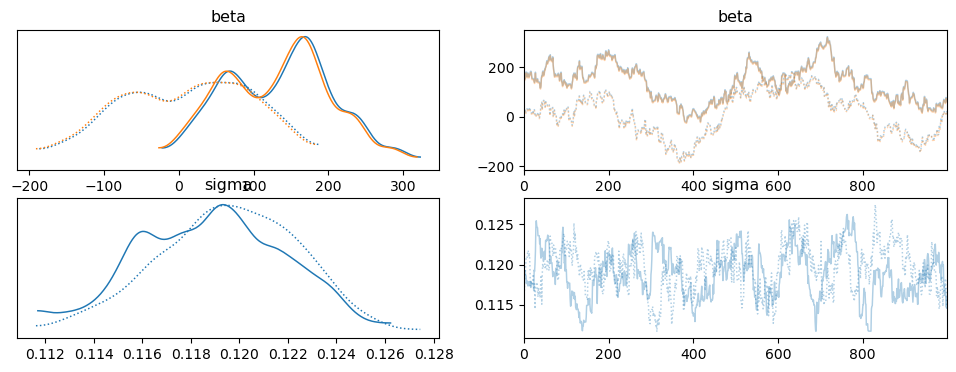

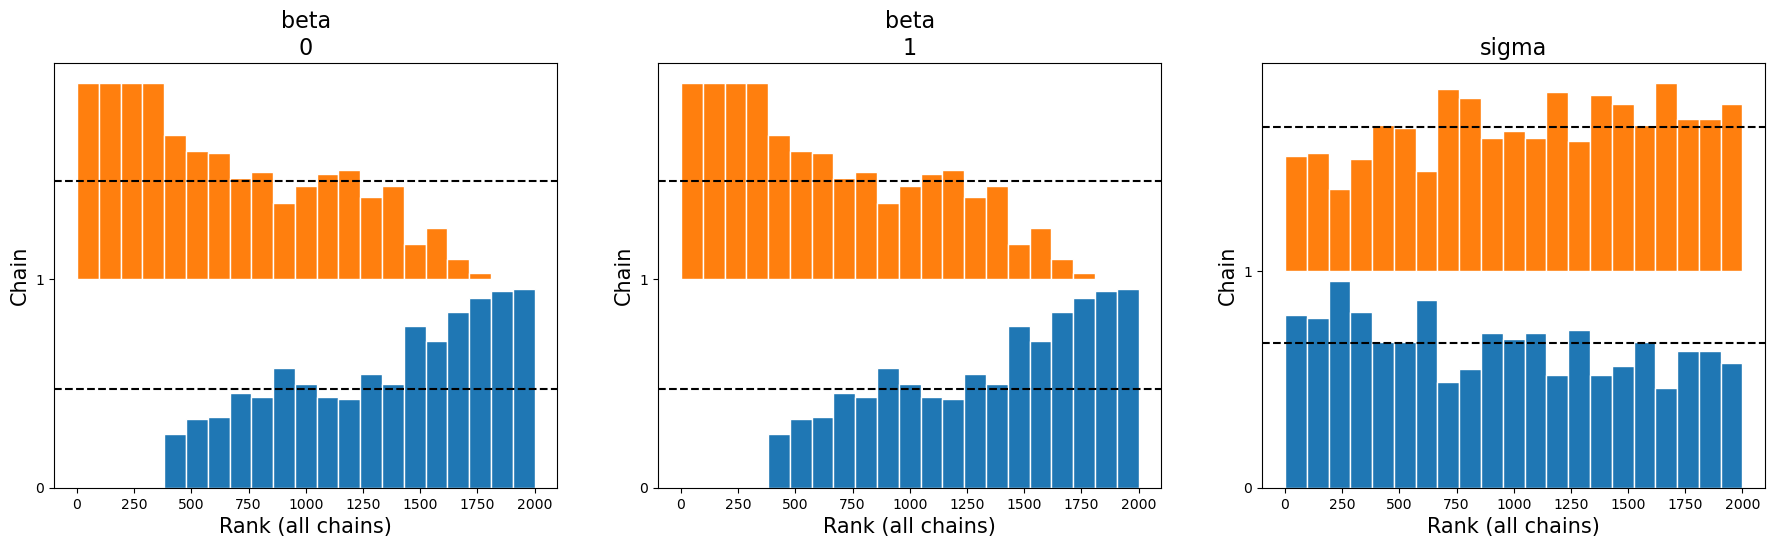

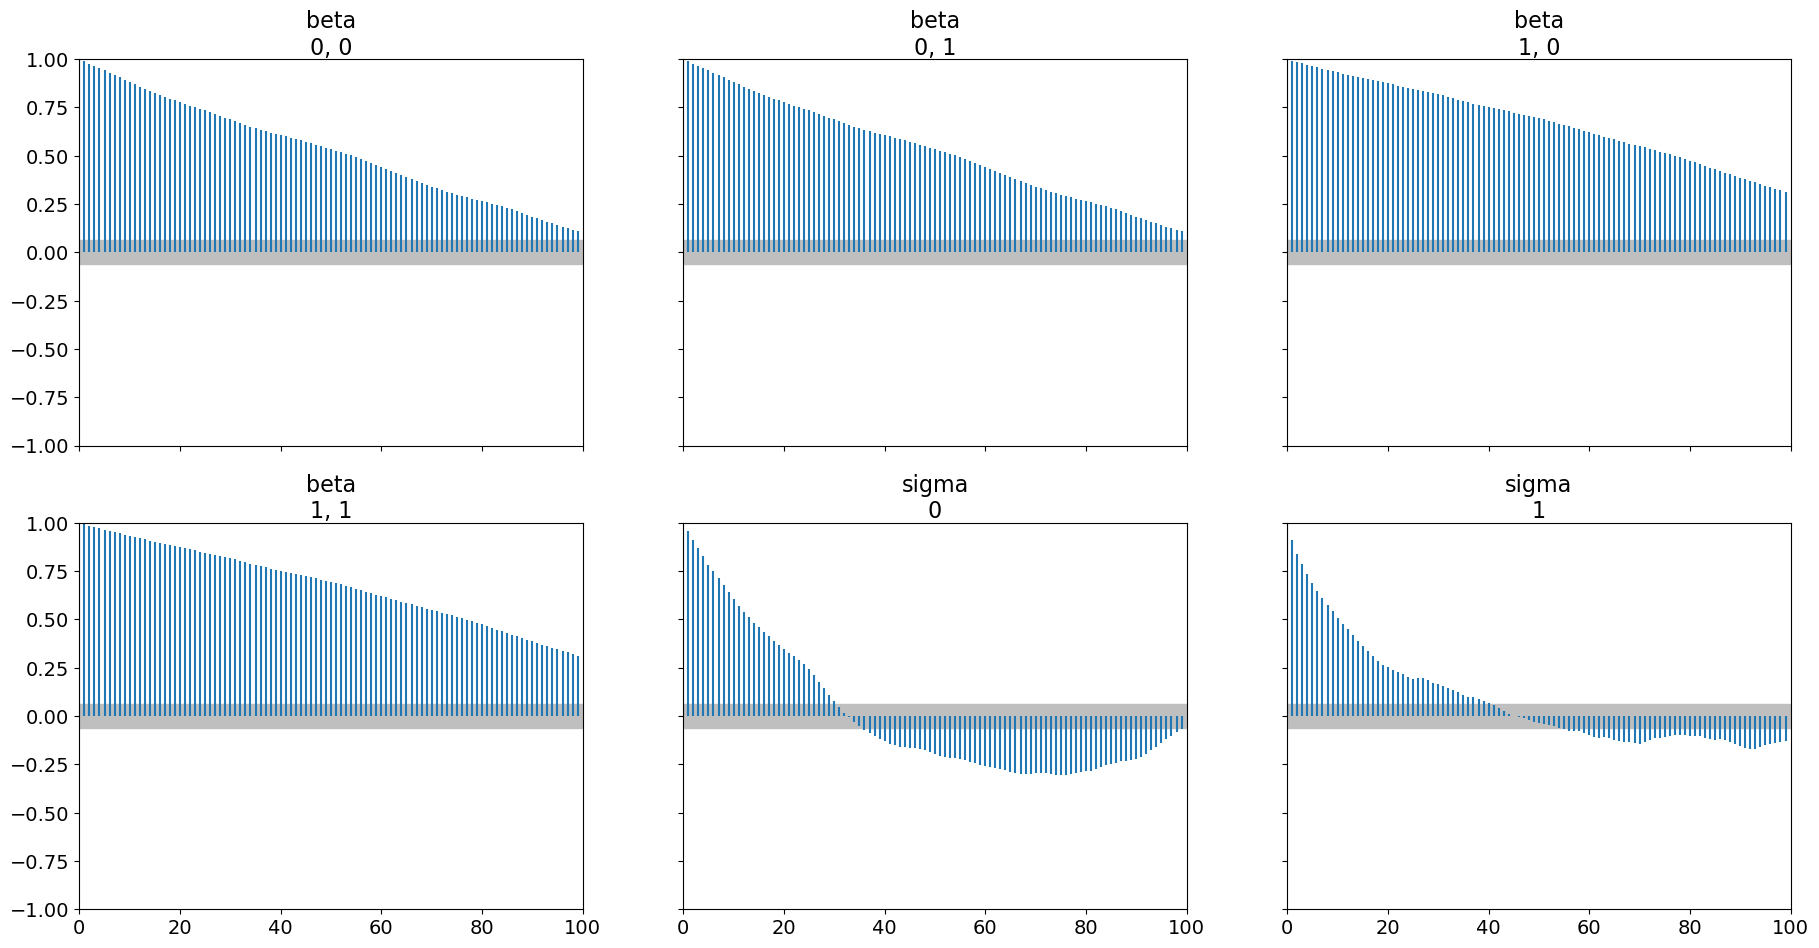

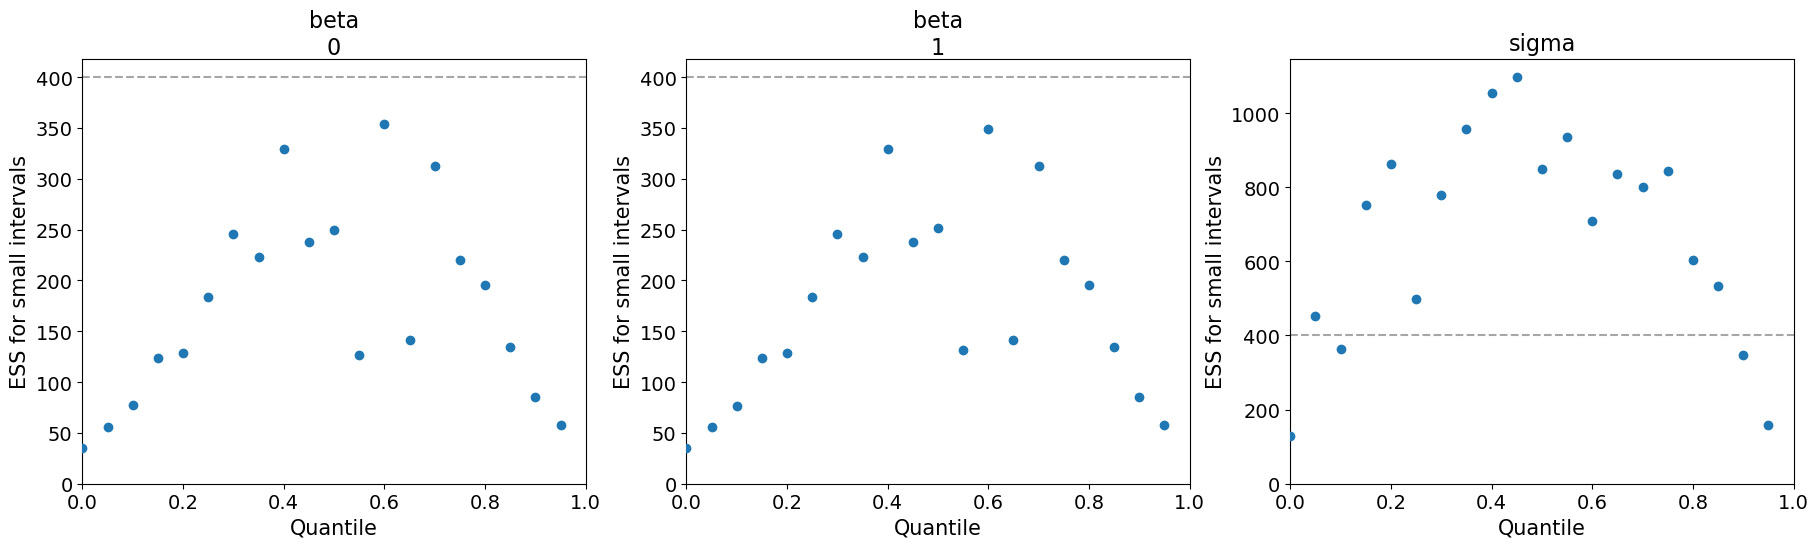

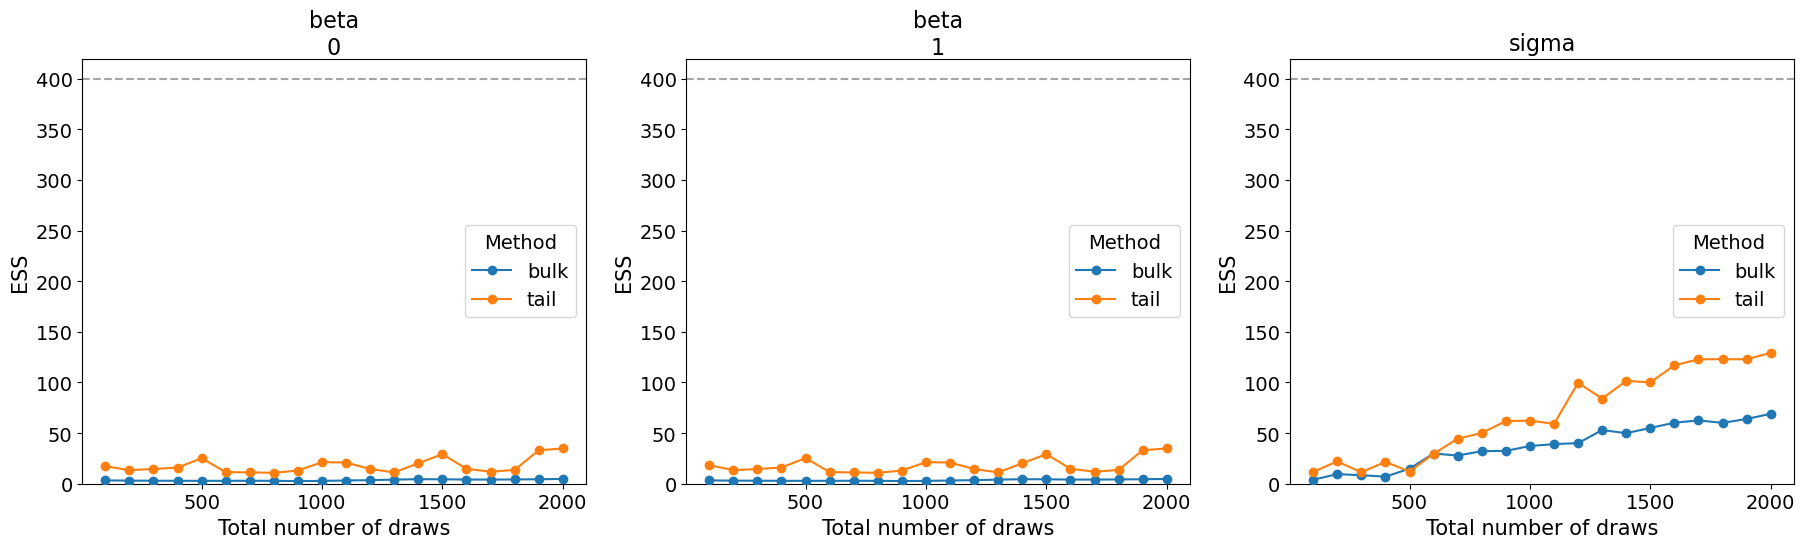

IS THE MODEL GOOD?


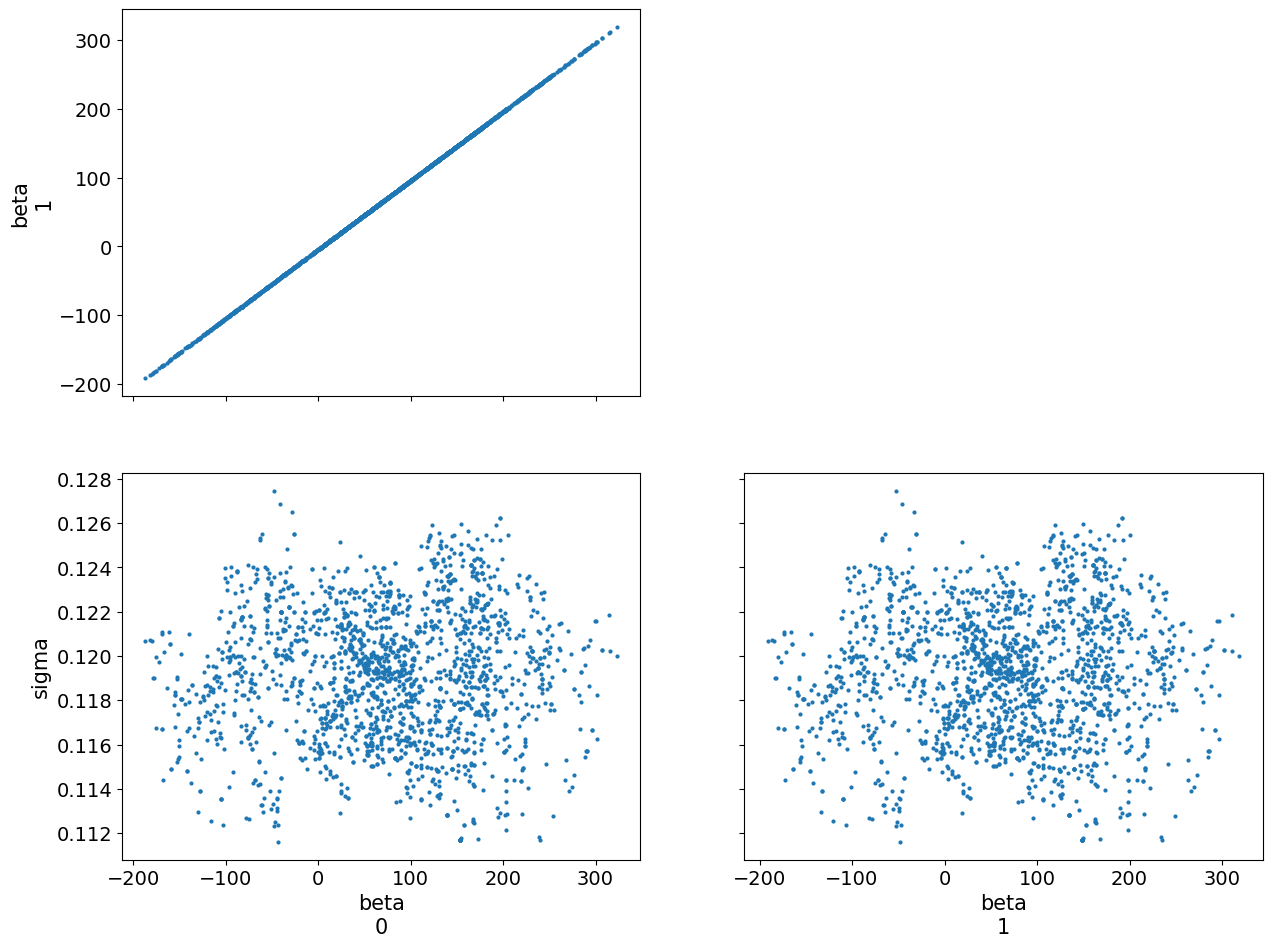

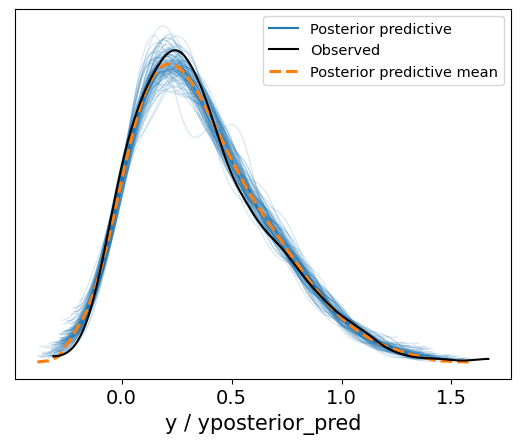

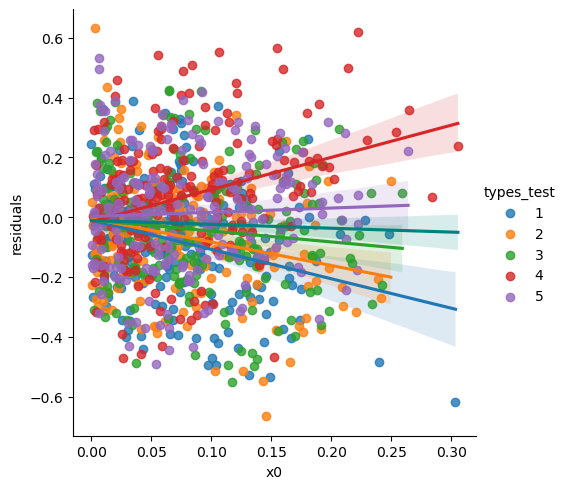

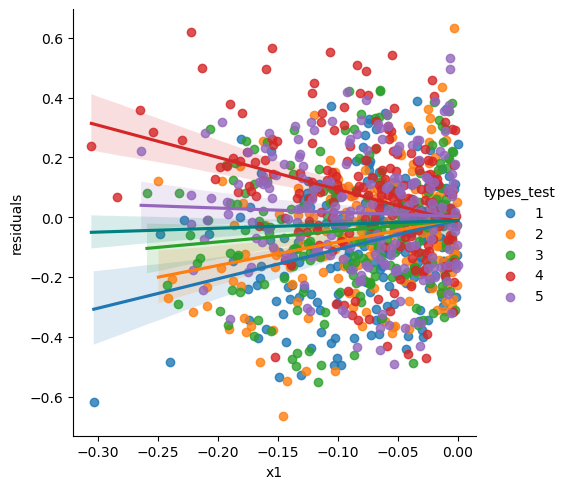

              y_test  y_test_predictions
types_test                              
1           0.254943            0.339299
2           0.268275            0.331487
3           0.352800            0.394942
4           0.420539            0.350650
5           0.369159            0.355562
WHAT ARE THE RESULTS?


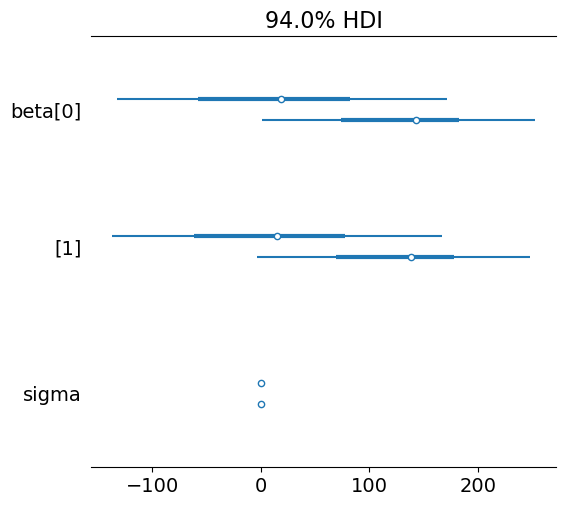

In [32]:
plot_stuff_about_model(idata, stan_data, fit)

This is definitely bad! The two chains are in completely different parts of the parameter space, which is reflected in super high rhat, the trace rank plot, the trace plot, etc.

How do we fix this?
1. Of course, you can remove one of the parameters, they're perfectly correlated (as the pair plot shows).
2. Just add _regularization_, as you could do in a standard machine learning setting. As we talked about previously, regularization <=> adding informative priors for the parameters. For example, if we had an informative prior for the parameters instead of a flat prior, we would have nicely converged (but parameter interpretation might still be challenging). 

#### Fixing the non-identification with priors

In [33]:
stan_folder = 'stan_code/'
stan_file = stan_folder + 'linear_regression_withinformativeprior.stan'
with open(stan_file) as file:
    model_code = file.read()
print(model_code)
compiled_model = stan.build(model_code, data=stan_data, random_seed=1)
fit = compiled_model.sample(num_chains=2, num_warmup = 200, num_samples= 1000)

data {
    int<lower=0> N;
    int<lower=0> N_test;
    int<lower=1> Nattr; // number of covariates
    matrix[N,Nattr] X;  
    matrix[N_test,Nattr] X_test;  
    array[N] real y;
    }

parameters {
    vector[Nattr] beta;  // attribute effects
    real <lower=0> sigma; // standard deviation of the noise
}
model {
    beta ~ normal(0, 10);
    sigma ~ normal(0, 10);
    y ~ normal(X*beta, sigma);
}

generated quantities {
    # this is drawing samples from the posterior predictive distribution, so that we can check the fit
    array[N] real yposterior_pred;
    yposterior_pred = normal_rng(X*beta, sigma);

    # this is the exact predictions for the test set
    vector[N_test] y_testset_pred;
    y_testset_pred = X_test*beta;
}
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_p5aqdnbx/model_yqzoeqev.stan', line 21, column 4: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
Warning in '/tmp/httpstan_p5aqdnbx/model_yqzoeqev.stan', line 25, column 4: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
Sampling:   0%
Sampling:   0% (1/2400)
Sampling:   0% (2/2400)
Sampling:   4% (101/2400)
Sampling:   8% (200/2400)
Sampling:  54% (1300/2400)
Sampling: 100% (2400/2400)
Sampling: 100% (2400/2400), done.
Messages received during sampling:
  Gradient evaluation took 5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.5 seconds.
  Adjust your expectations according

In [34]:
idata = idata = get_arviz_data(fit, compiled_model = compiled_model, model_data = stan_data)
summary = az.summary(fit, var_names = ['beta', 'sigma'])
summary

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]  2.092  7.221 -11.962   15.011      0.342    0.256     446.0   
beta[1] -2.351  7.221 -16.437   10.571      0.342    0.242     446.0   
sigma    0.119  0.003   0.114    0.125      0.000    0.000     629.0   

         ess_tail  r_hat  
beta[0]     501.0    1.0  
beta[1]     501.0    1.0  
sigma       664.0    1.0

CONVERGENCE CHECKS


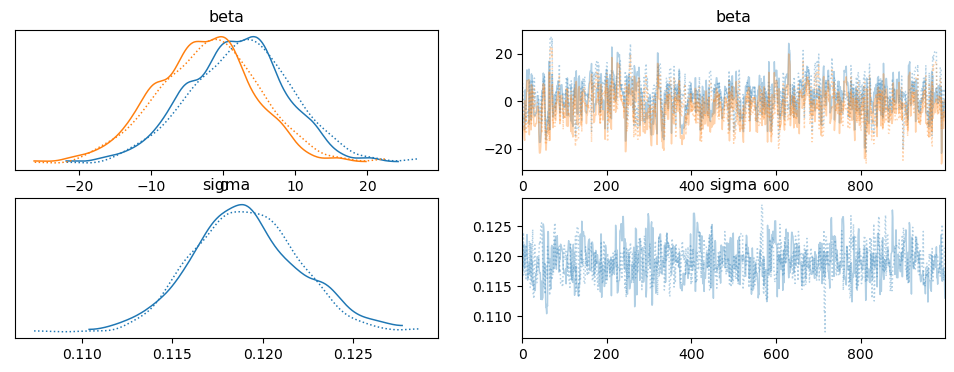

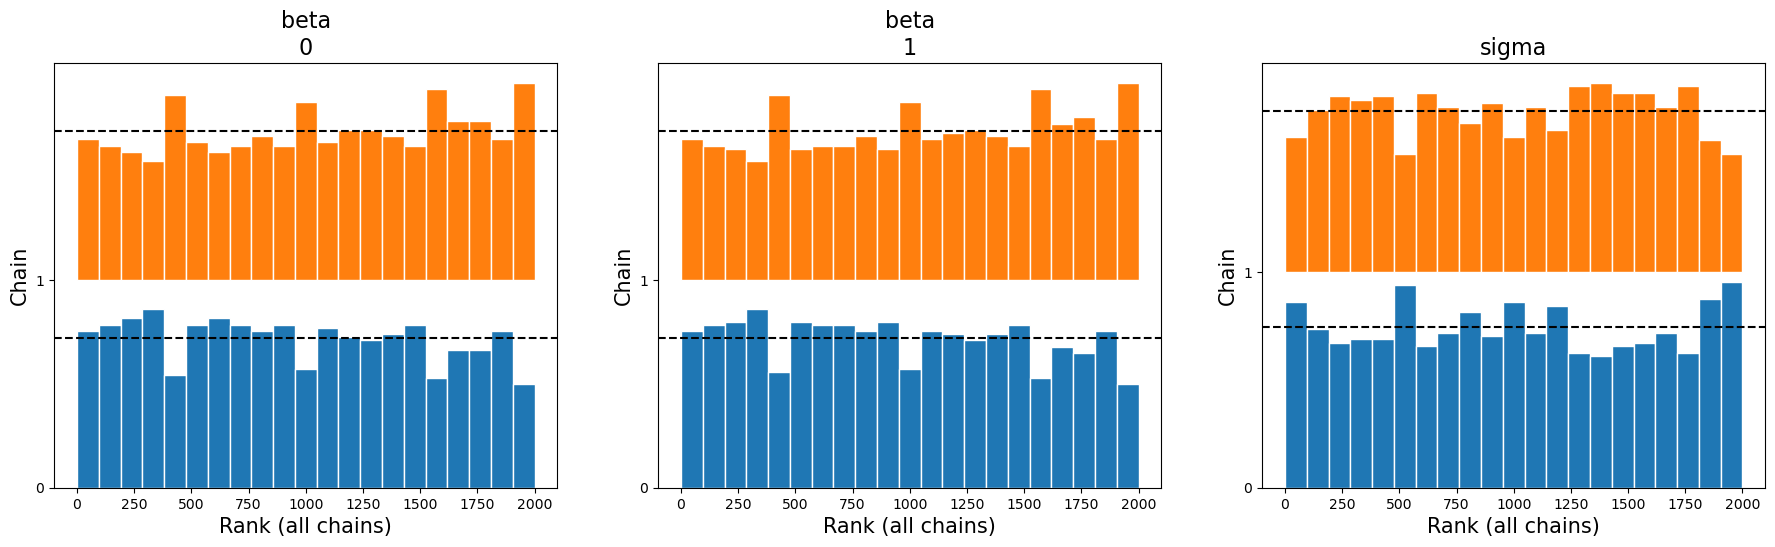

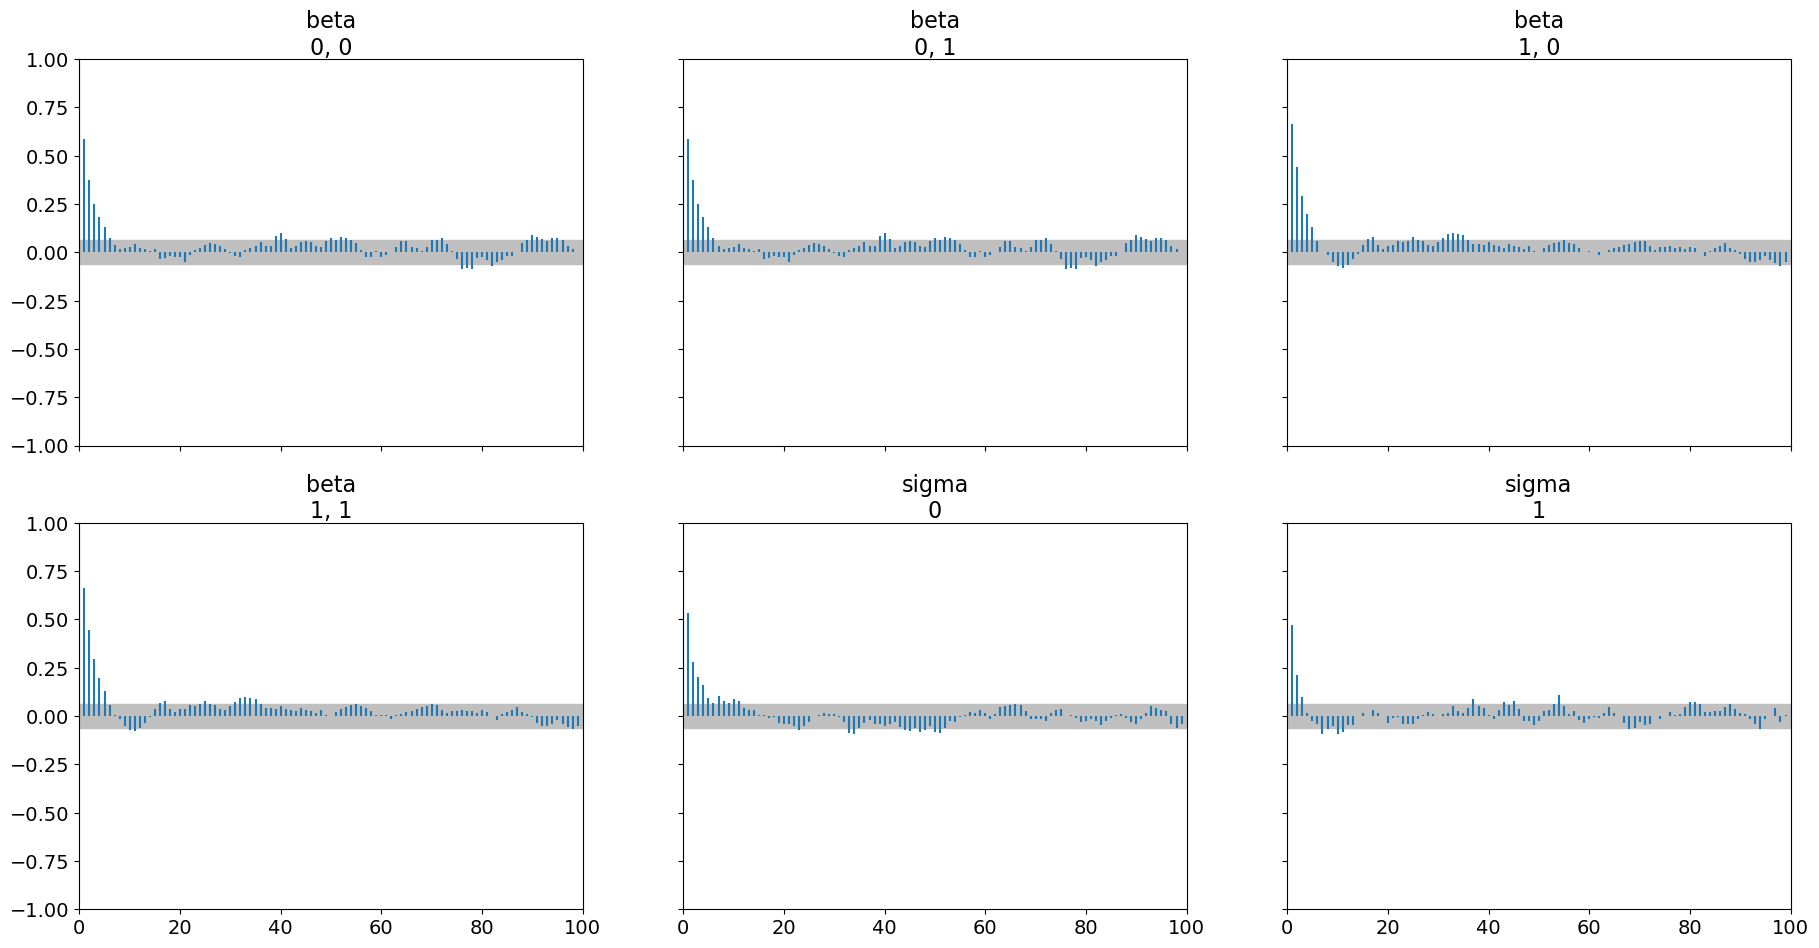

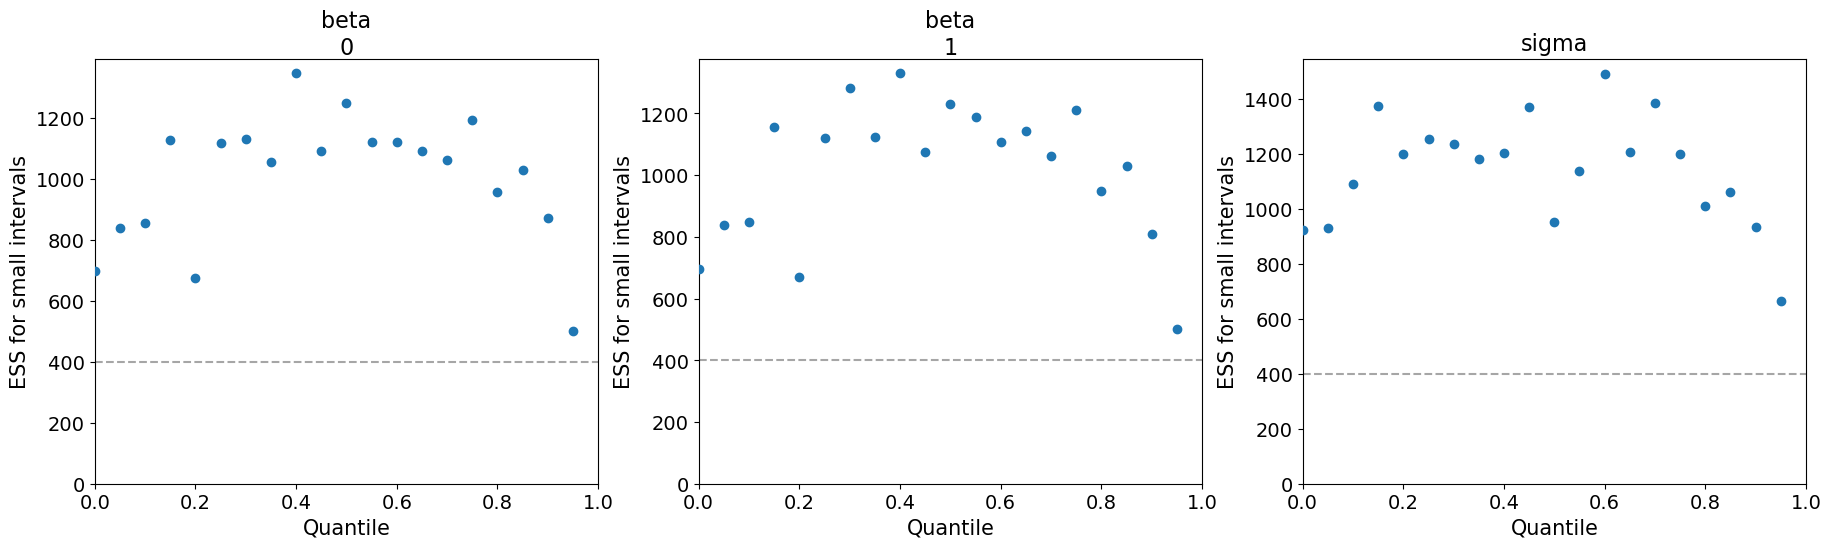

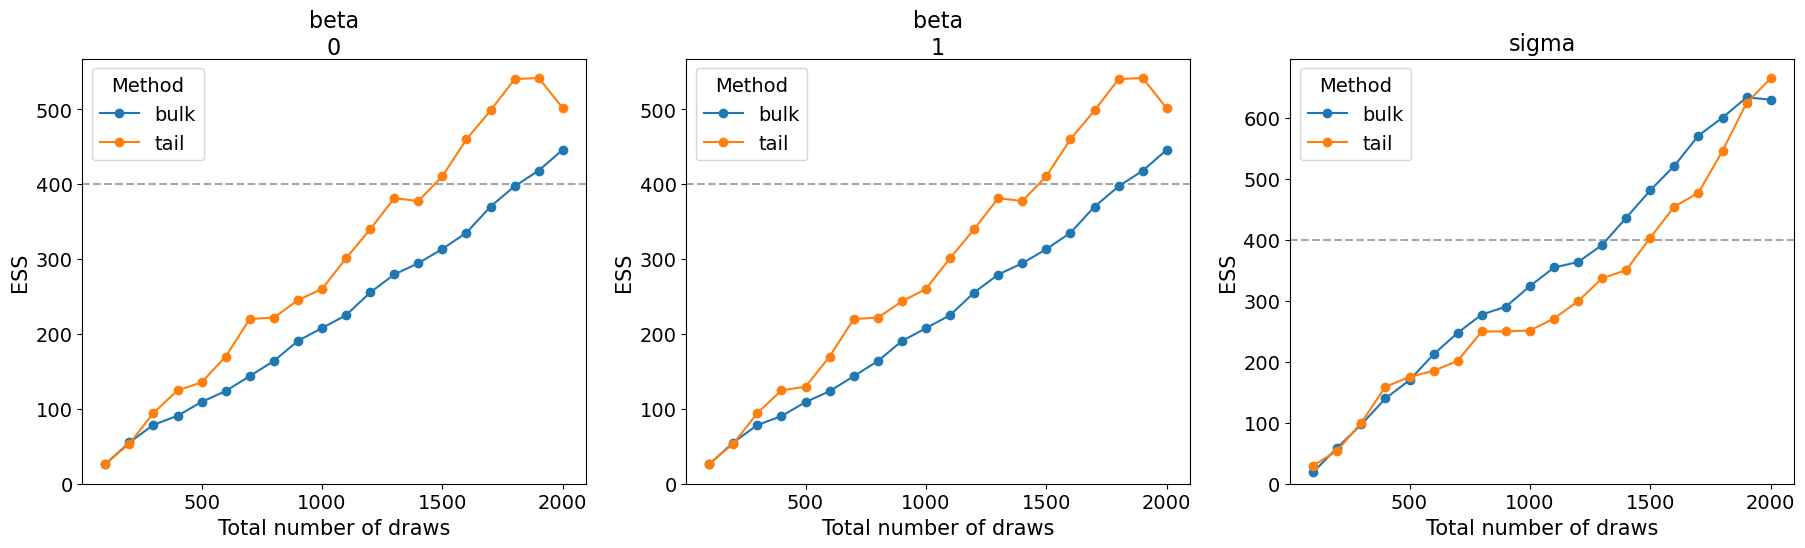

IS THE MODEL GOOD?


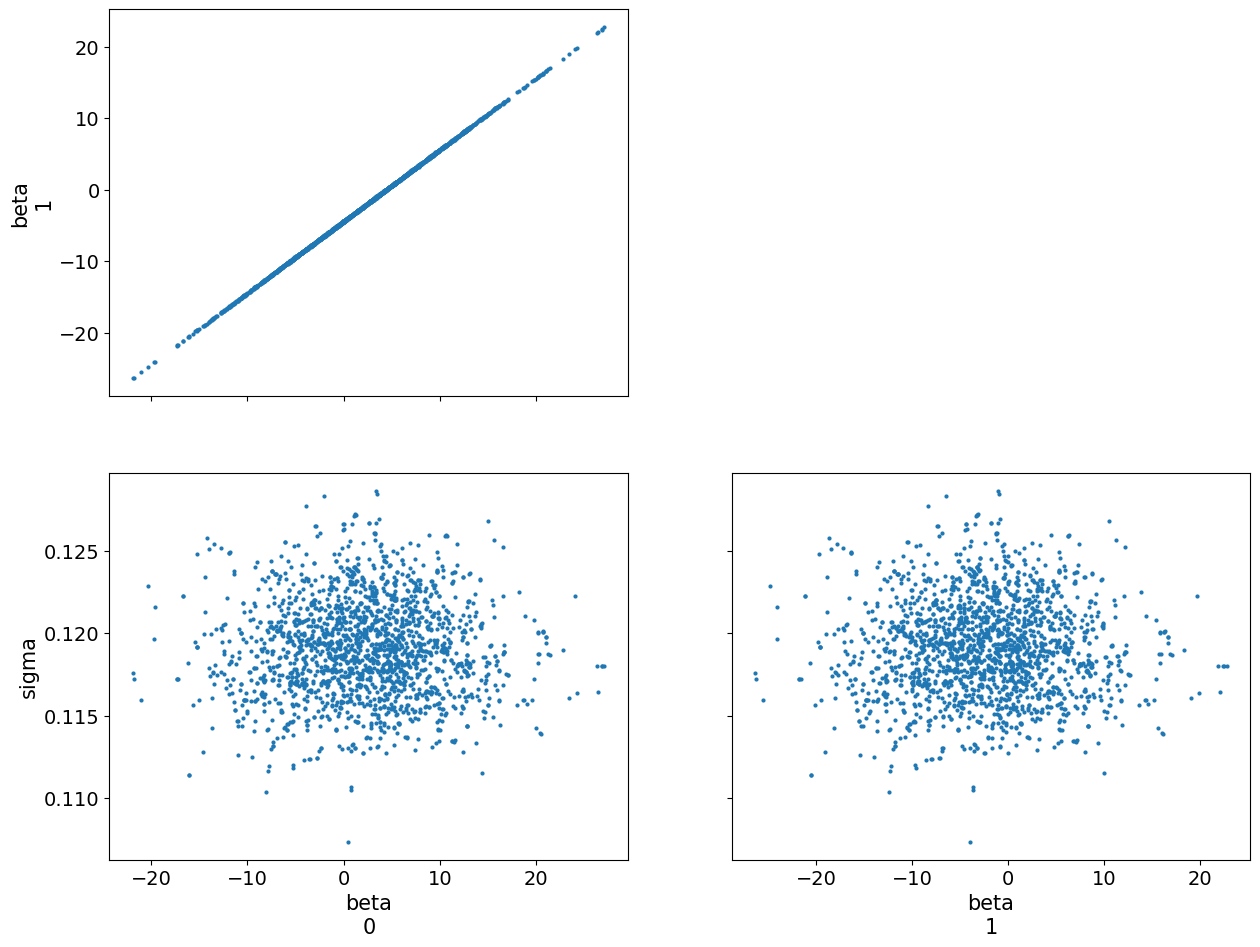

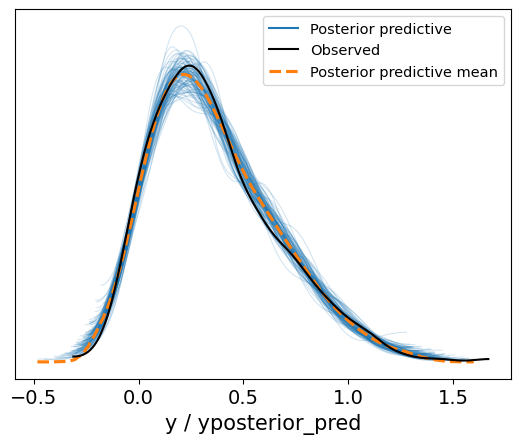

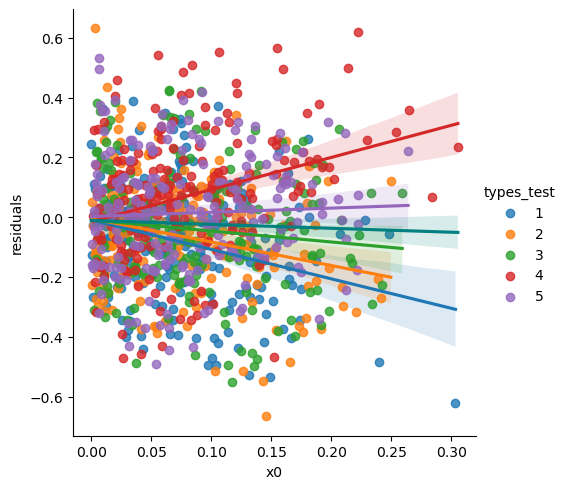

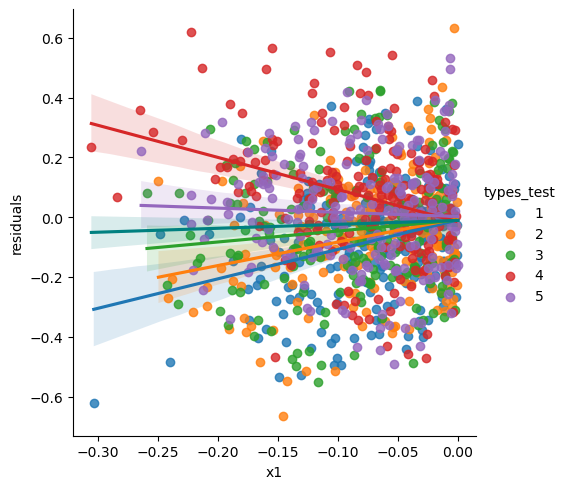

              y_test  y_test_predictions
types_test                              
1           0.254943            0.339432
2           0.268275            0.331618
3           0.352800            0.395098
4           0.420539            0.350788
5           0.369159            0.355702
WHAT ARE THE RESULTS?


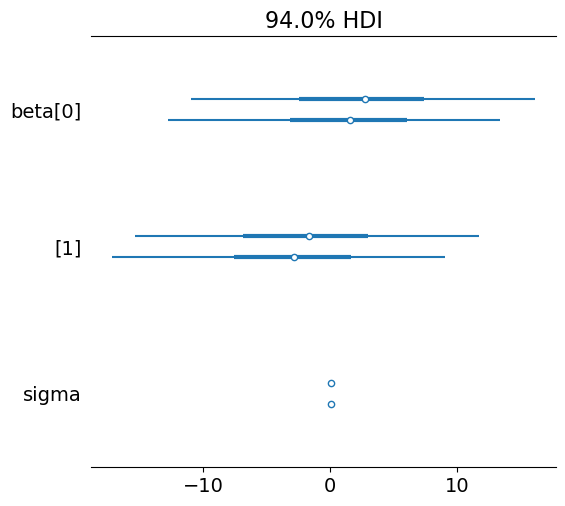

In [35]:
plot_stuff_about_model(idata, stan_data, fit)

# Now let's fit a correct hierarchical model

### With a LOT of data per area

In [36]:
n_locations = 5 # k 
n_features = 1 # dimension of x 
datapoints_per_location_min = 500

beta_overall = [4]#, 1] #overall slope terms \beta
sigma = .1

#do we have a bad location that is far from the others?
do_bad_location = False
bad_location_is_low_data = False
betas_k, number_datapoints_per_location  = draw_parameters_from_setting(
    n_locations, n_features, datapoints_per_location_min, beta_overall, do_bad_location, bad_location_is_low_data)
betas_k

array([[3.01823184],
       [3.67758702],
       [4.07243468],
       [4.34686258],
       [4.07602506]])

In [37]:
stan_data = draw_samples_from_model(betas_k, number_datapoints_per_location)

In [38]:
stan_folder = 'stan_code/'
stan_file = stan_folder + 'linear_regression_hierarchical.stan'
with open(stan_file) as file:
    model_code = file.read()
print(model_code)

data {
    int<lower=0> N;
    int<lower=0> N_test;
    int<lower=0> N_types;

    int<lower=1> Nattr; // number of covariates
    matrix[N,Nattr] X;  
    matrix[N_test,Nattr] X_test;  
    array[N] real y;
    array[N] int types; 
    array[N_test] int types_test; 
    }

parameters {
    vector[Nattr] beta;  // attribute effects

    // attribute effects per type
    array[N_types] vector[Nattr] beta_types;

    real <lower=0> sigma; // standard deviation of the noise
}
model {
    beta ~ normal(0, 10);
    sigma ~ normal(0, 10);

    #hierarchical prior on beta_types
    for (i in 1:N_types) {
        beta_types[i] ~ normal(beta, 10);
    }

    # likelihood for each observation
    for (i in 1:N) {
        y[i] ~ normal(X[i]*beta_types[types[i]], sigma);
    }
}

generated quantities {
    # this is drawing samples from the posterior predictive distribution, so that we can check the fit
    array[N] real yposterior_pred;
    for (i in 1:N) {
        yposterior_pred[i] = normal_rng

In [39]:
compiled_model = stan.build(model_code, data=stan_data, random_seed=1)

Building...

In file included from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/boost/multi_array/multi_array_ref.hpp:32,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/boost/multi_array.hpp:34,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/boost/numeric/odeint/algebra/multi_array_algebra.hpp:22,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/boost/numeric/odeint.hpp:63,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/ode_rk45.hpp:9,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/integrate_ode_rk45.hpp:6,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor.hpp:14,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include


Building: 28.4s, done.Messages from stanc:
Warning in '/tmp/httpstan__efbbgir/model_6jfmyiwv.stan', line 26, column 4: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
Warning in '/tmp/httpstan__efbbgir/model_6jfmyiwv.stan', line 31, column 4: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
Warning in '/tmp/httpstan__efbbgir/model_6jfmyiwv.stan', line 38, column 4: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
Warning in '/tmp/httpstan__efbbgir/model_6jfmyiwv.stan', line 44, column 4: Comments
    beginning with # are deprecated and this s

In [40]:
fit = compiled_model.sample(num_chains=2, num_warmup = 200, num_samples= 500)

Sampling:   0%
Sampling:   0% (1/1400)
Sampling:   0% (2/1400)
Sampling:   7% (101/1400)
Sampling:  14% (202/1400)
Sampling:  22% (301/1400)
Sampling:  29% (400/1400)
Sampling:  36% (500/1400)
Sampling:  43% (601/1400)
Sampling:  50% (701/1400)
Sampling:  57% (800/1400)
Sampling:  64% (900/1400)
Sampling:  71% (1000/1400)
Sampling:  79% (1100/1400)
Sampling:  86% (1200/1400)
Sampling:  93% (1300/1400)
Sampling: 100% (1400/1400)
Sampling: 100% (1400/1400), done.
Messages received during sampling:
  Gradient evaluation took 0.001973 seconds
  1000 transitions using 10 leapfrog steps per transition would take 19.73 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_1dmrgv26/model_6jfmyiwv.stan', line 33, column 8 to column 56)
  If this warning occurs sporadically, such as for highly constrai

In [41]:
idata = idata = get_arviz_data(fit, compiled_model = compiled_model, model_data = stan_data)
summary = az.summary(fit, var_names = ['beta', 'beta_types', 'sigma'])
summary

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]           3.293  3.792  -3.757   10.410      0.102    0.109    1407.0   
beta_types[0, 0]  3.050  0.044   2.962    3.124      0.002    0.001     833.0   
beta_types[1, 0]  3.649  0.024   3.608    3.695      0.001    0.000    1296.0   
beta_types[2, 0]  4.057  0.019   4.024    4.092      0.001    0.000    1217.0   
beta_types[3, 0]  4.349  0.016   4.319    4.377      0.000    0.000    1876.0   
beta_types[4, 0]  4.082  0.014   4.057    4.109      0.000    0.000    1563.0   
sigma             0.100  0.001   0.098    0.101      0.000    0.000    1423.0   

                  ess_tail  r_hat  
beta[0]              765.0   1.01  
beta_types[0, 0]     826.0   1.00  
beta_types[1, 0]     755.0   1.00  
beta_types[2, 0]     773.0   1.00  
beta_types[3, 0]     661.0   1.00  
beta_types[4, 0]     746.0   1.00  
sigma                854.0   1.00

In [42]:
# ground truth:
betas_k, sigma

(array([[3.01823184],
        [3.67758702],
        [4.07243468],
        [4.34686258],
        [4.07602506]]),
 0.1)

This model nails the parameter estimates per location -- it's the right model.

CONVERGENCE CHECKS


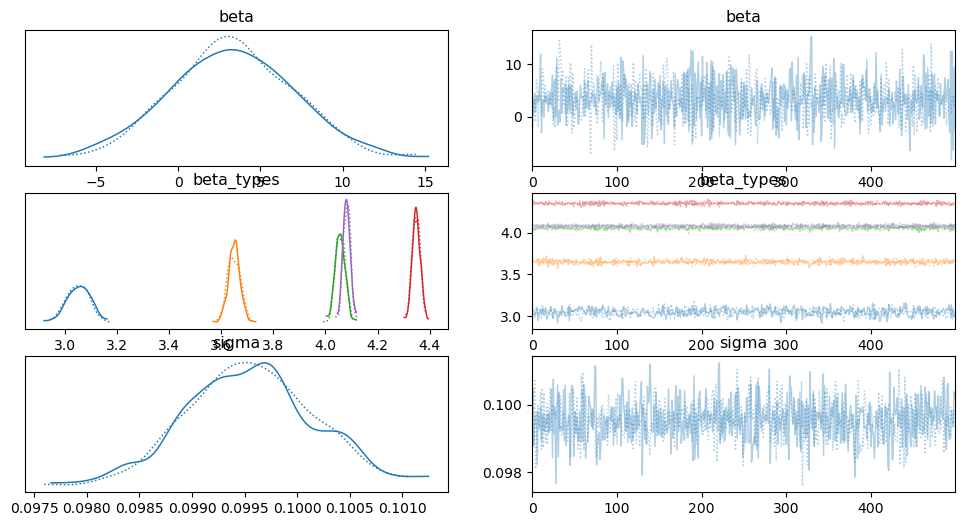

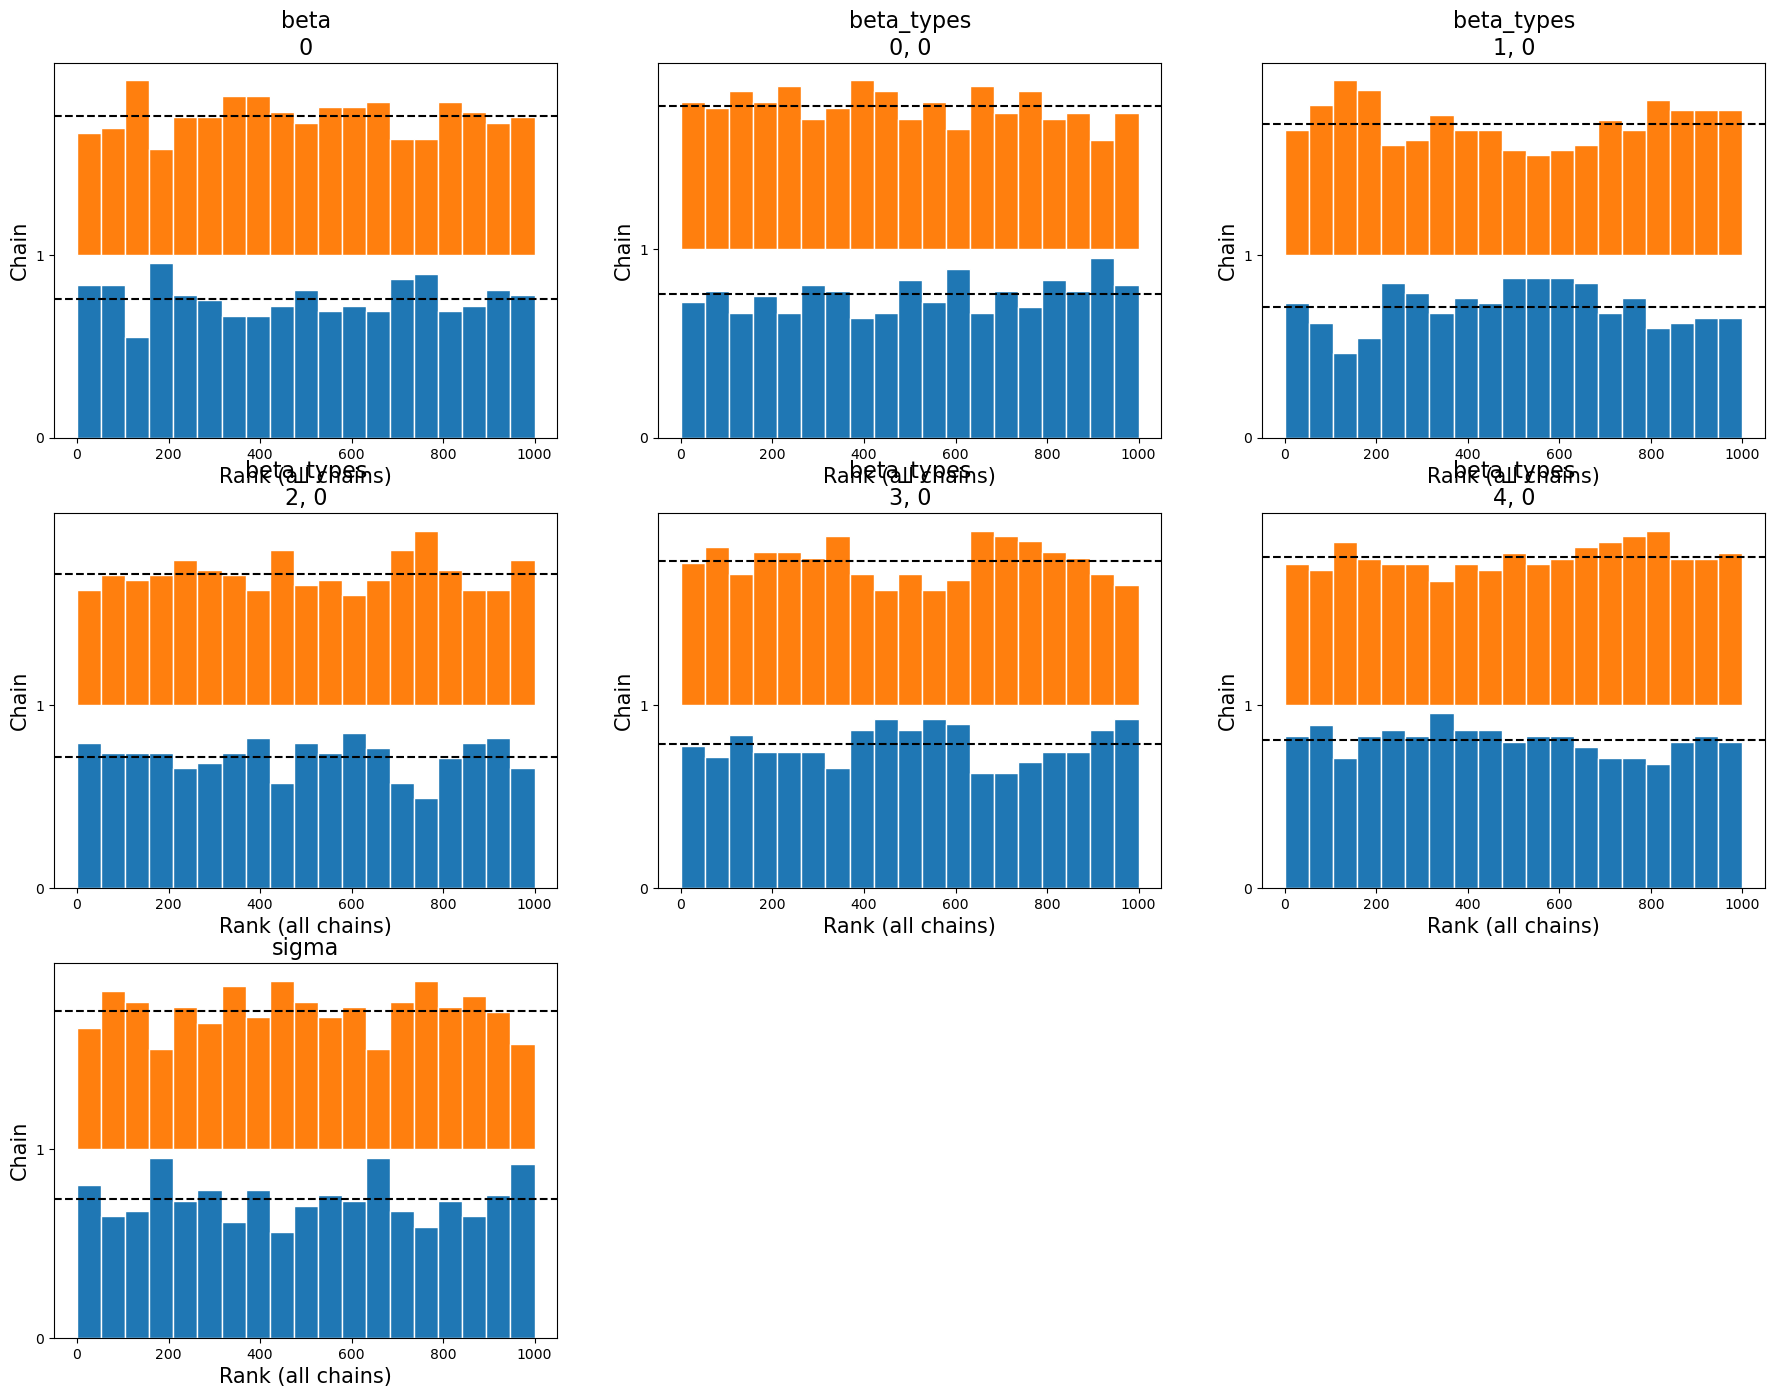

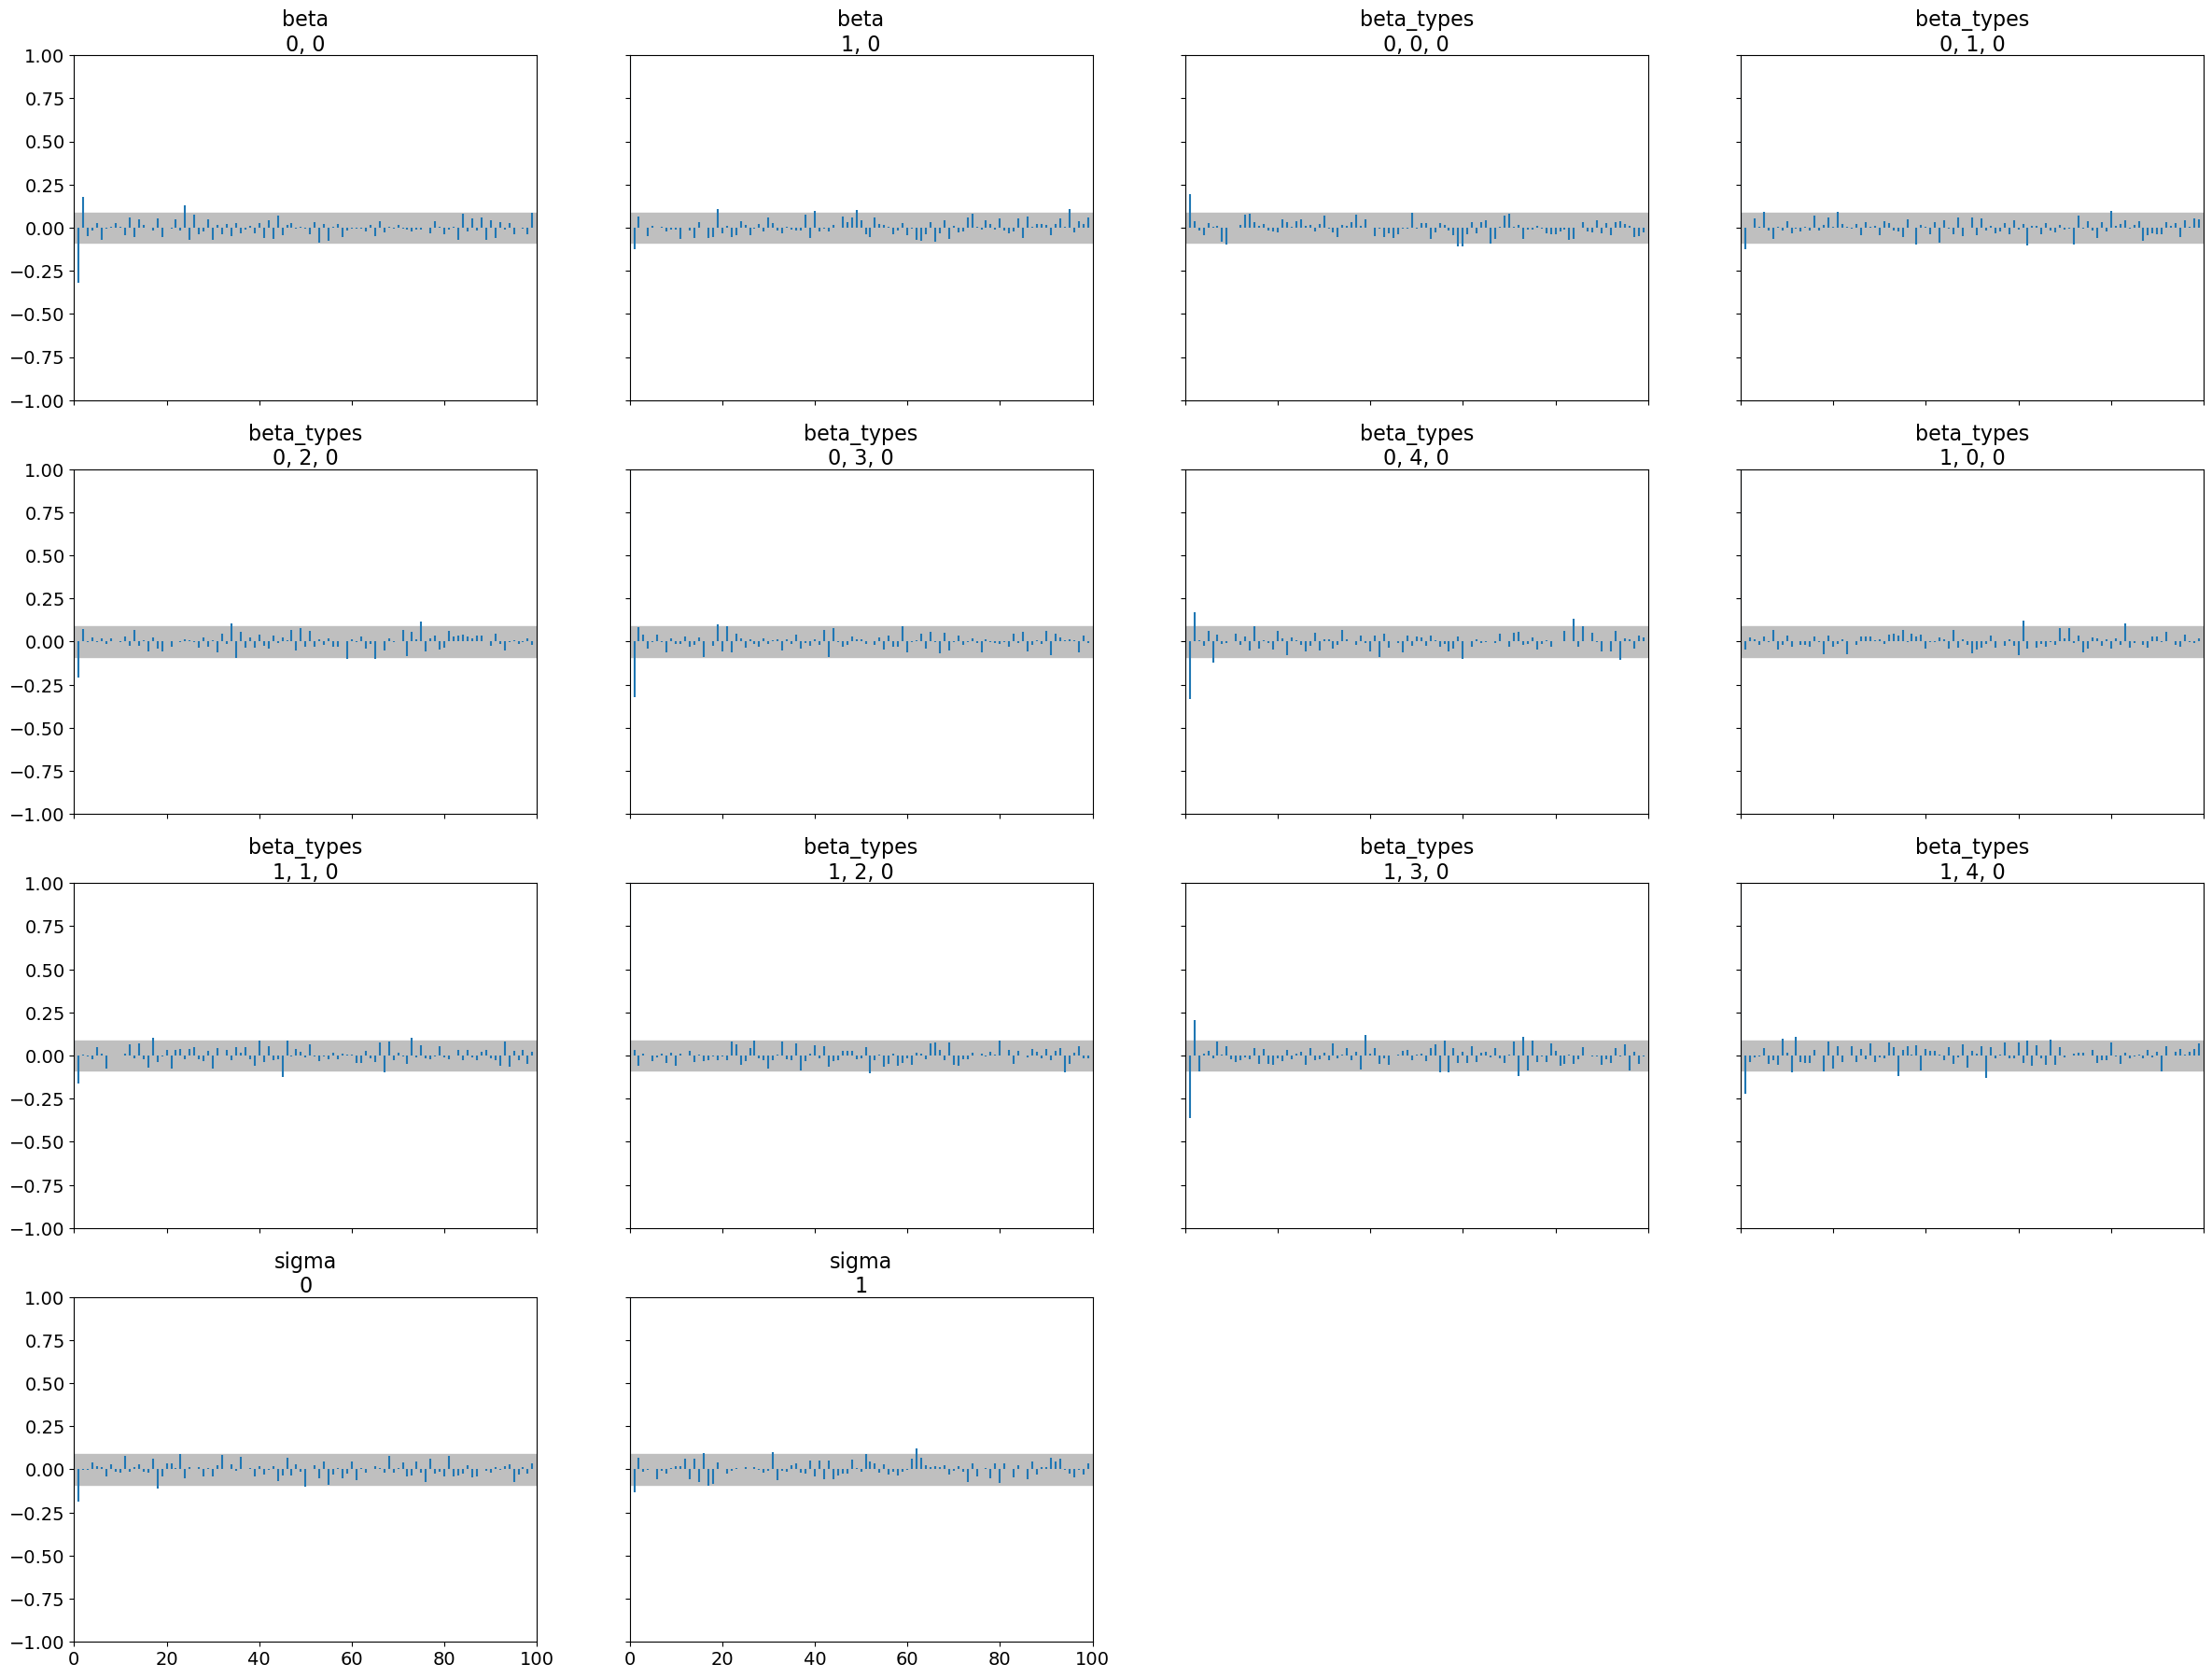

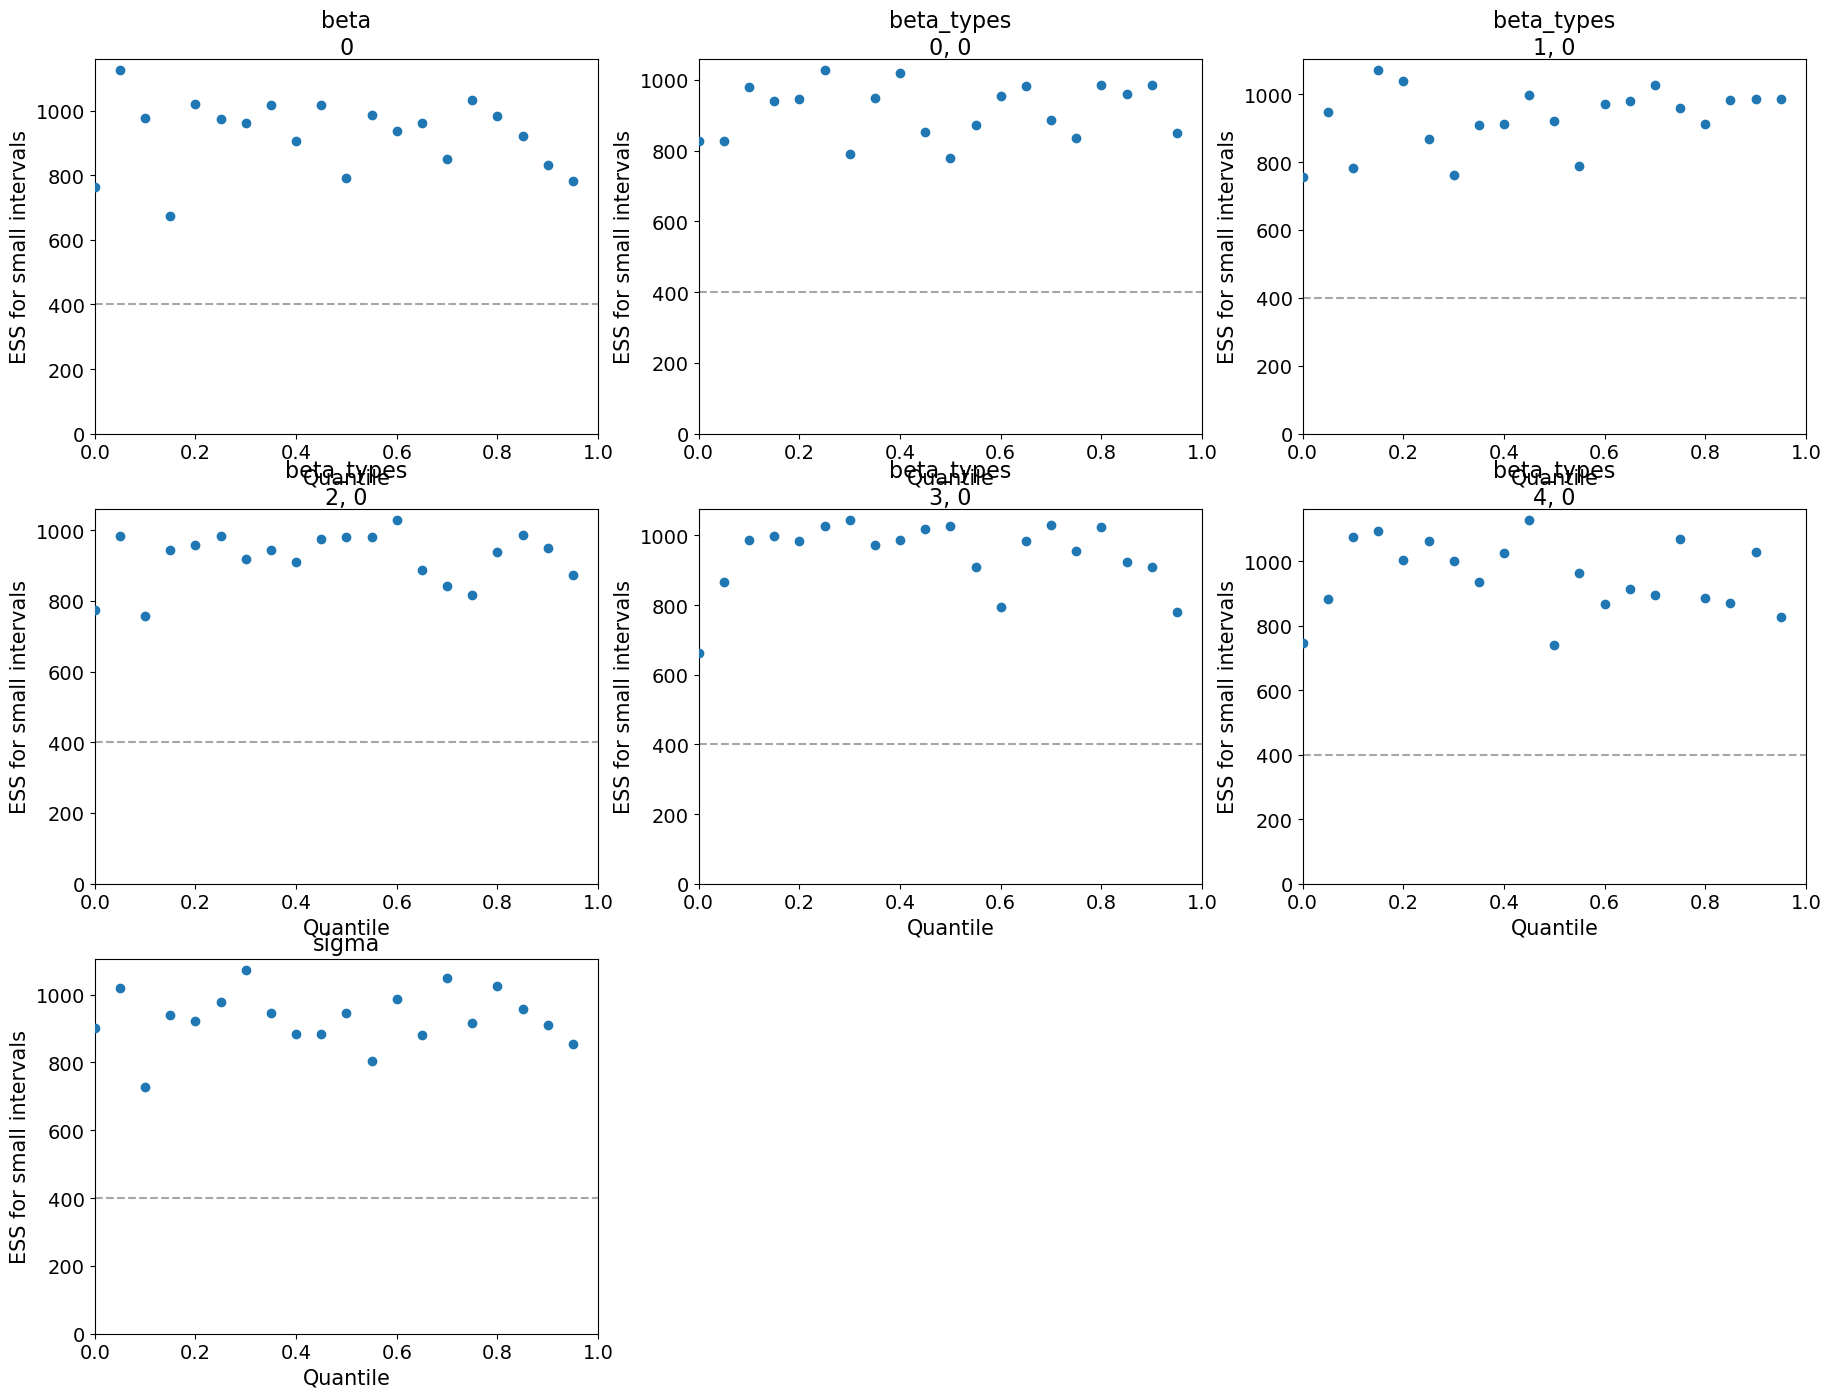

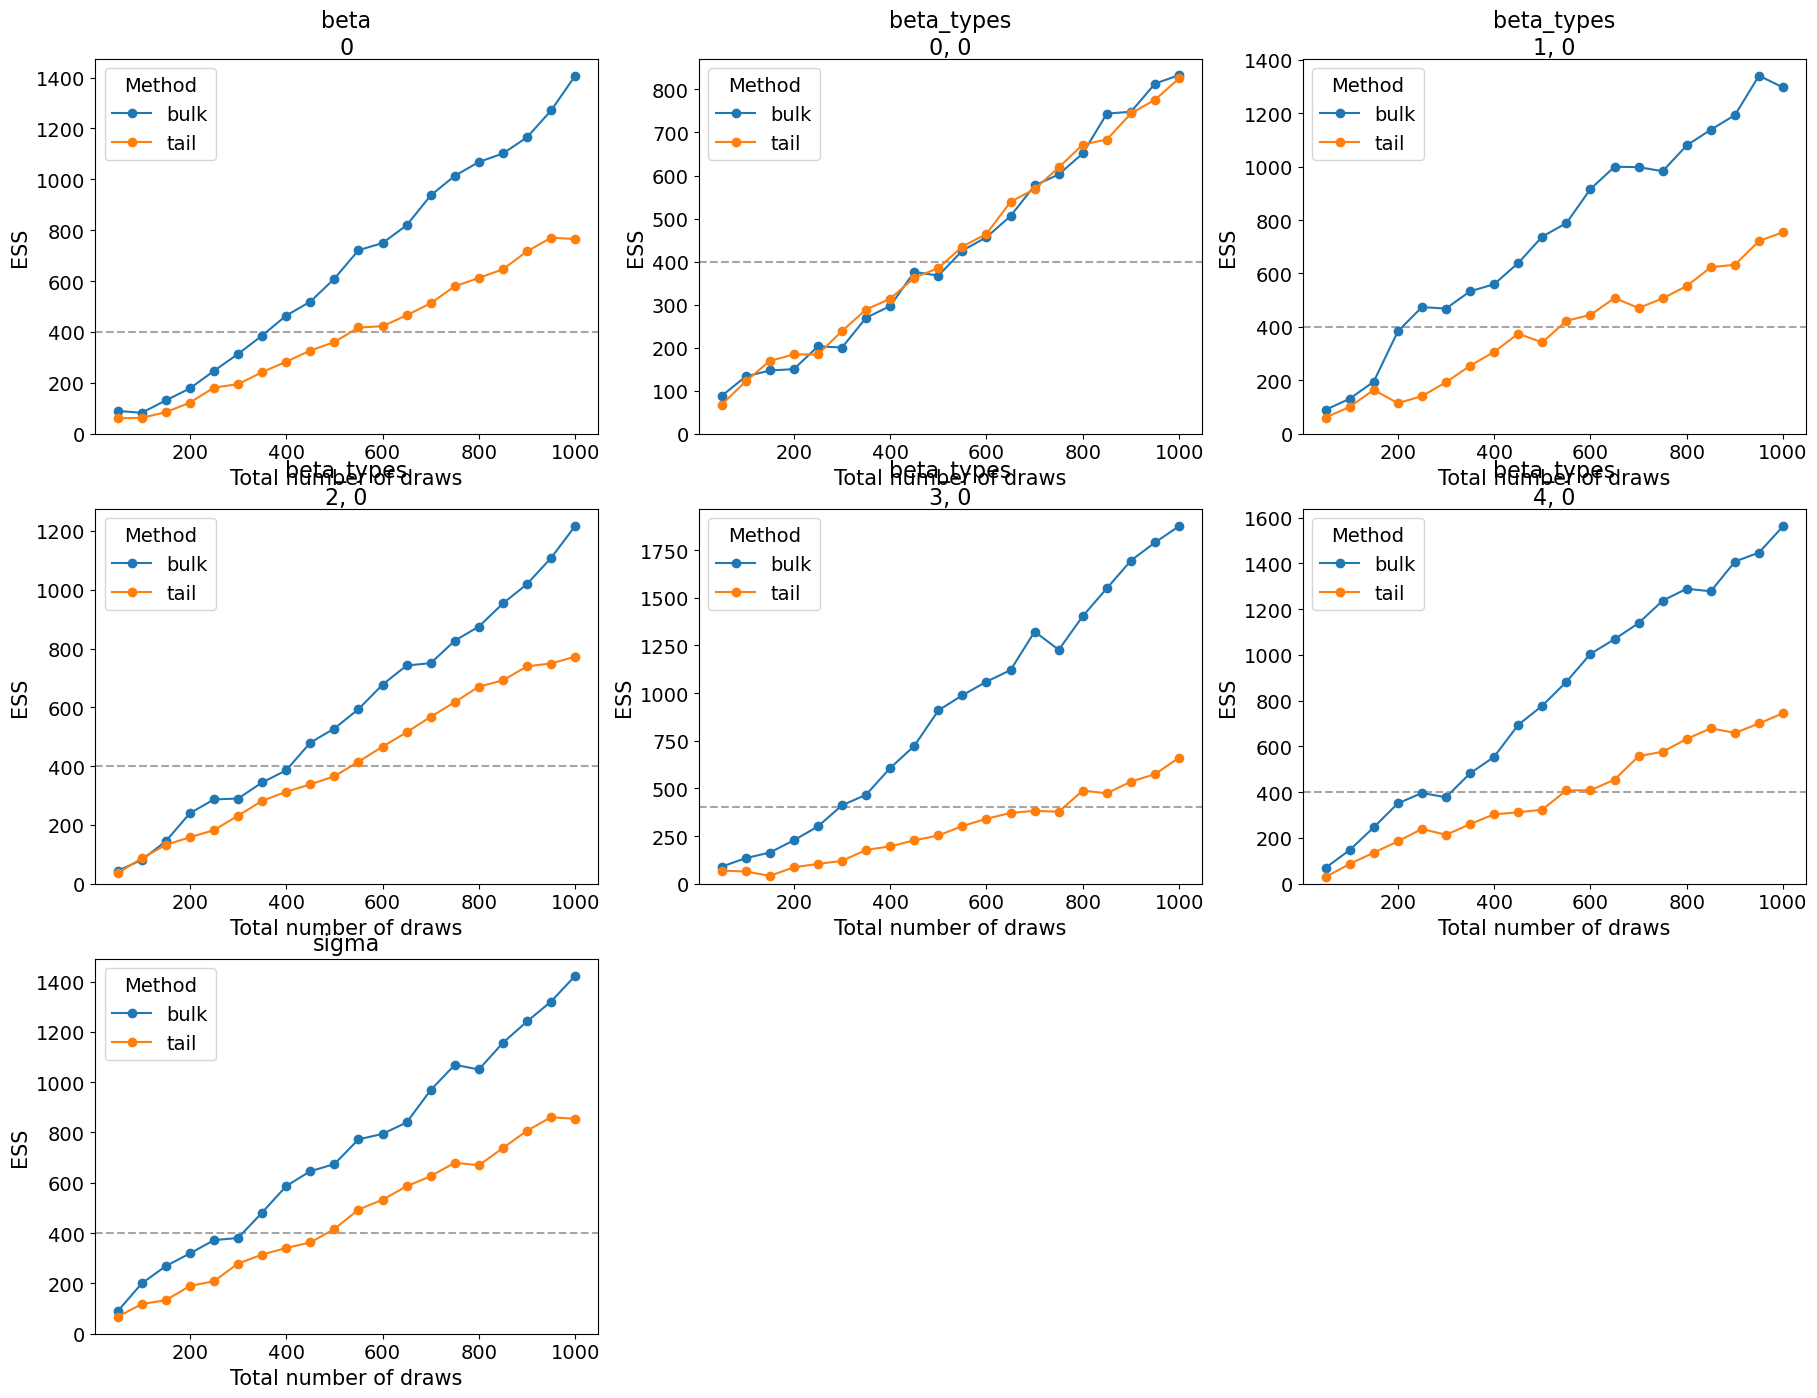

IS THE MODEL GOOD?


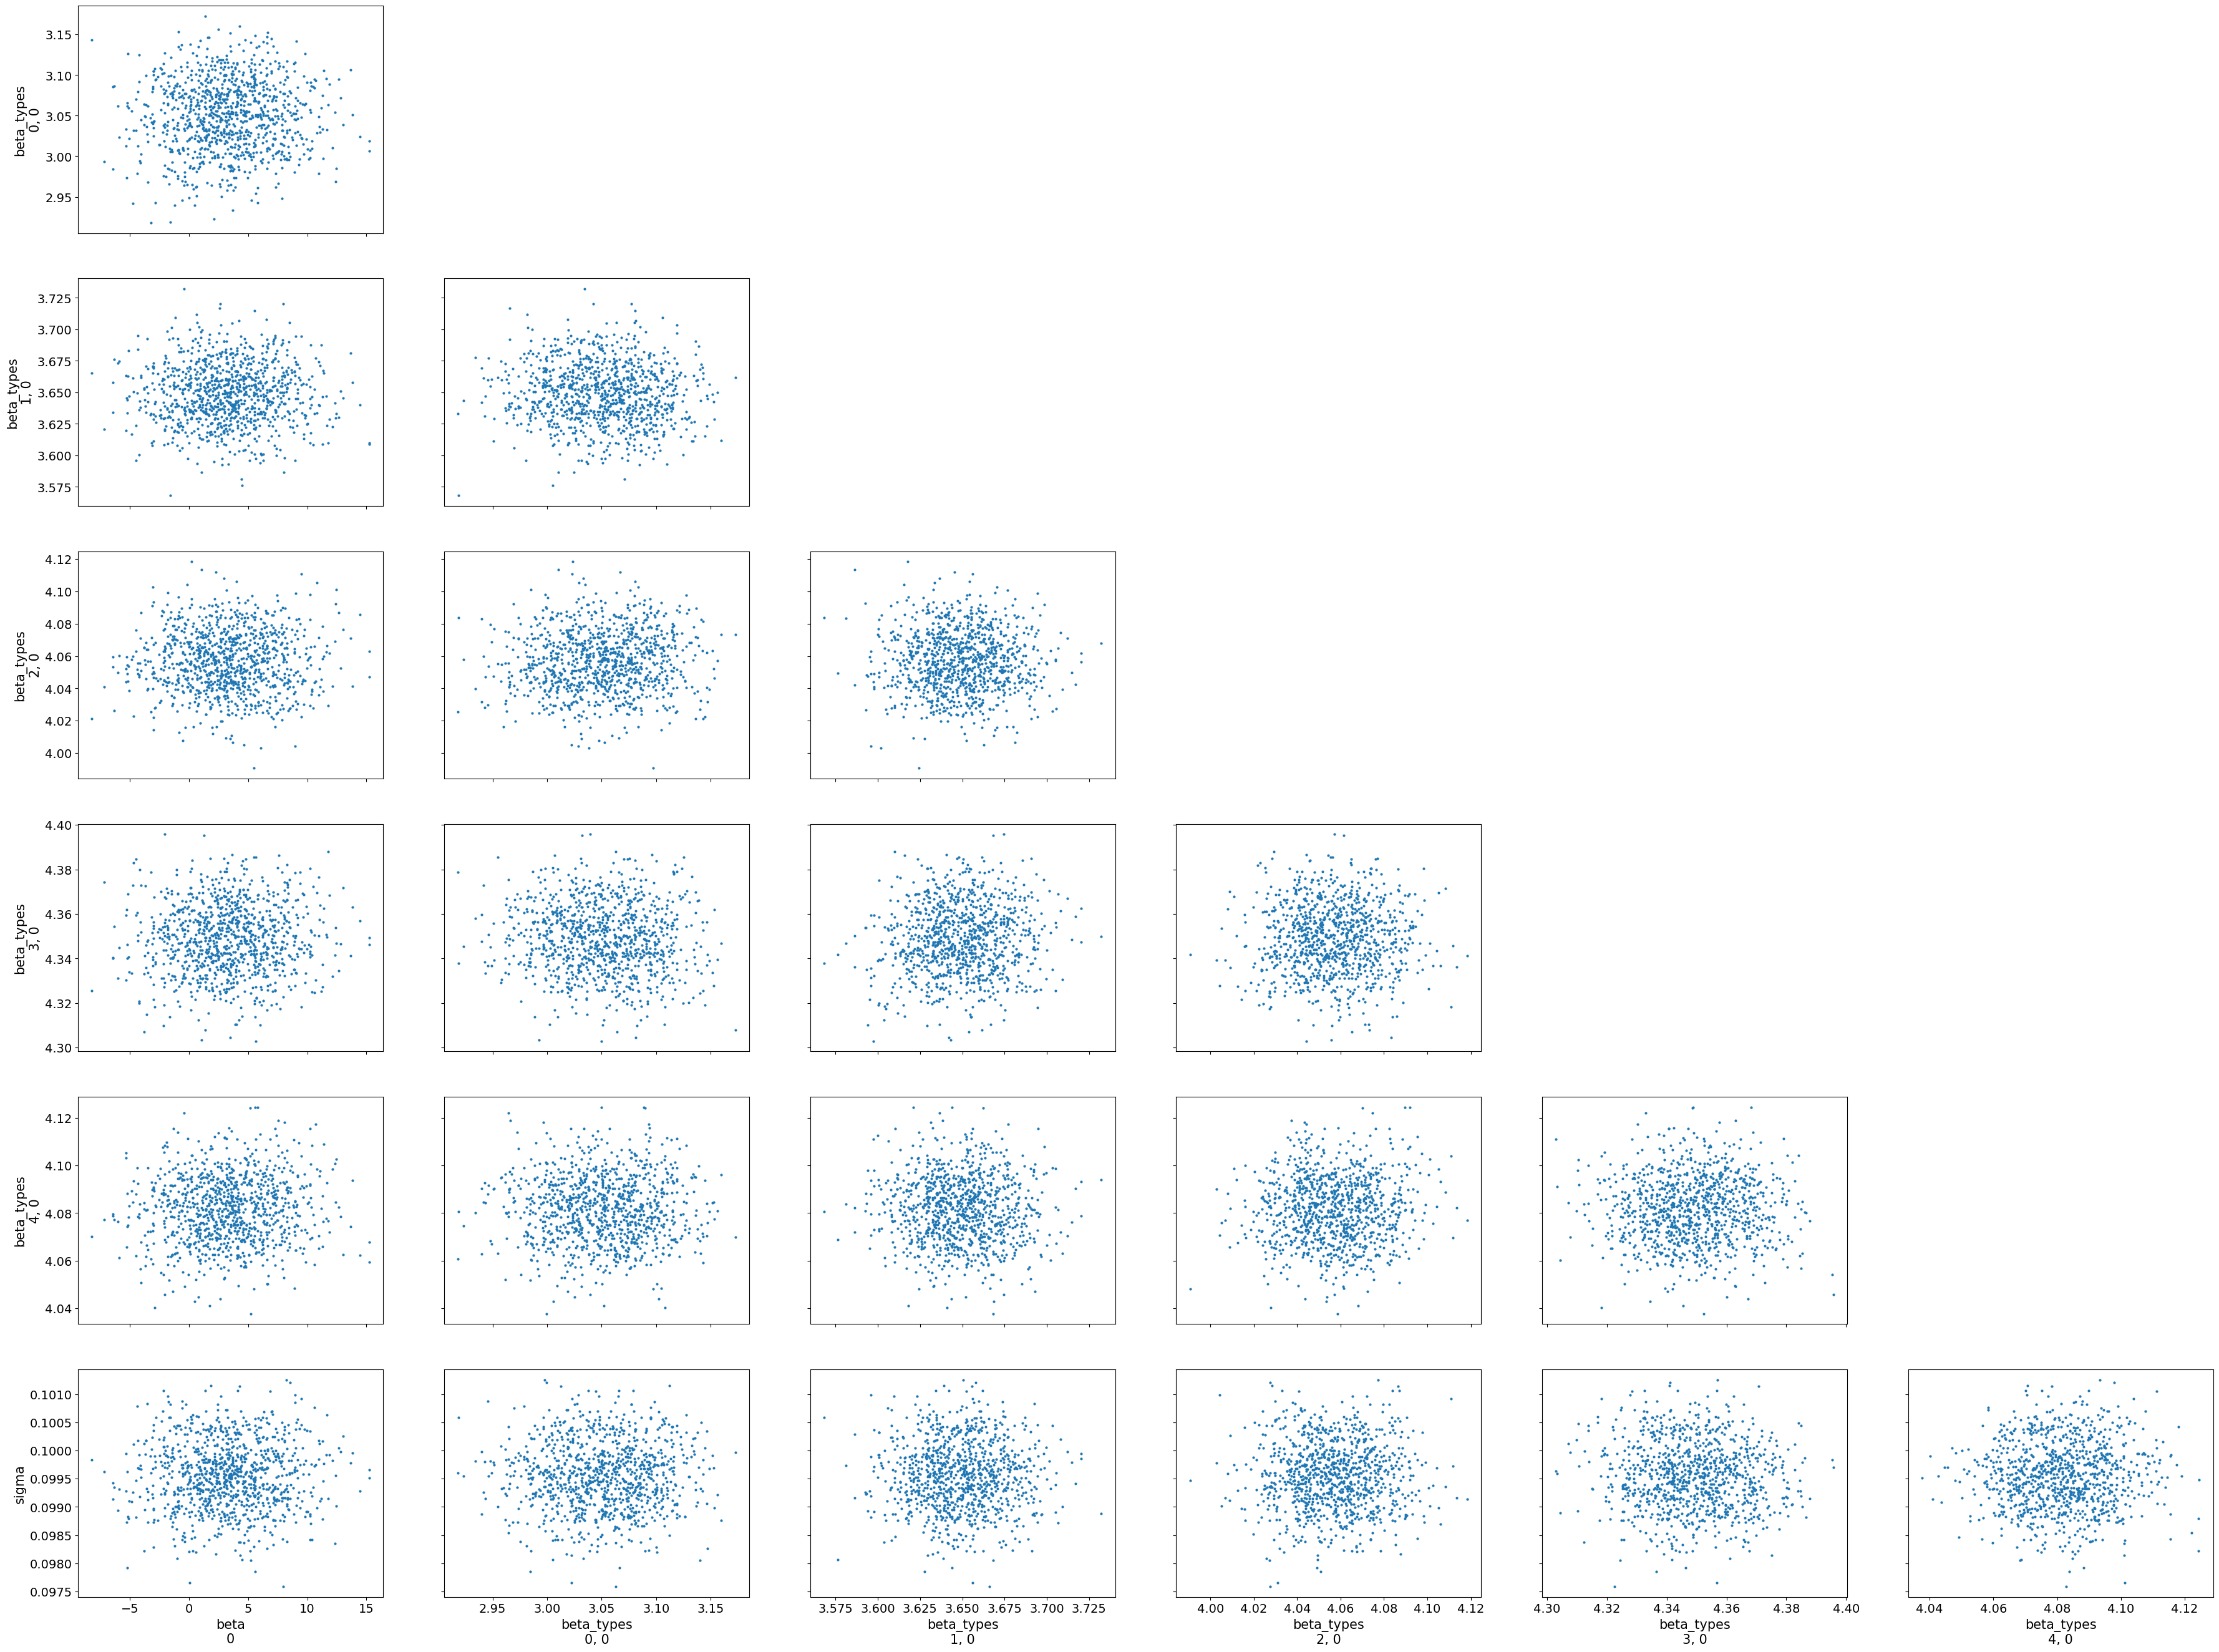

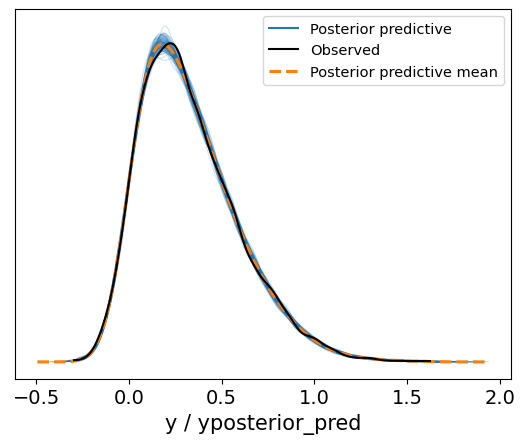

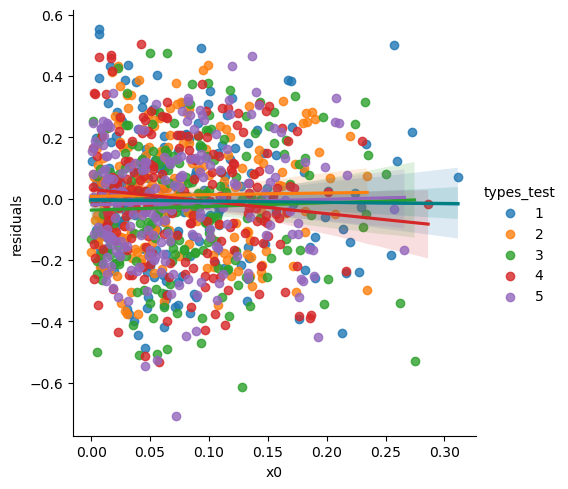

              y_test  y_test_predictions
types_test                              
1           0.235726            0.242859
2           0.289688            0.278116
3           0.309982            0.337512
4           0.344226            0.345444
5           0.297754            0.311037
WHAT ARE THE RESULTS?


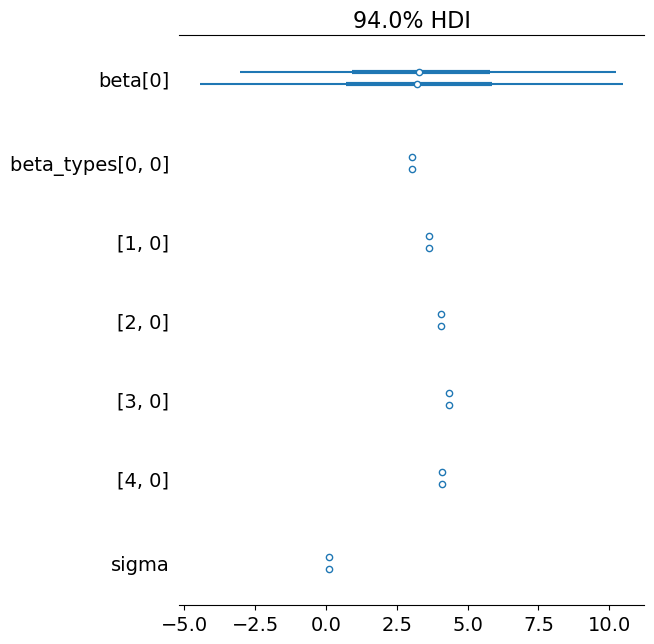

In [43]:
plot_stuff_about_model(idata, stan_data, fit, var_names = ['beta', 'beta_types', 'sigma'])

As expected, this model is great! It converges nicely, and the checks indicate that the model is correct -- model is well calibrated, and posterior predictive check is perfect

# What is a hierarchical model doing? If there are few data points for a given type, then its parameters are basically going to be near the population mean 

In [44]:
n_locations = 5 # k 
n_features = 1 # dimension of x 
datapoints_per_location_min = 0
datapoints_per_location_max = 200

beta_overall = [4]#, 1] #overall slope terms \beta
sigma = .1

#do we have a bad location that is far from the others?
do_bad_location = False
bad_location_is_low_data = False
betas_k, number_datapoints_per_location  = draw_parameters_from_setting(
    n_locations, n_features, datapoints_per_location_min, beta_overall, do_bad_location, bad_location_is_low_data)
betas_k

array([[3.75235122],
       [4.17349758],
       [3.85028076],
       [3.3160893 ],
       [4.16097363]])

In [45]:
number_datapoints_per_location

[0, 75, 150, 225, 300]

In [46]:
stan_data = draw_samples_from_model(betas_k, number_datapoints_per_location)

In [52]:
stan_folder = 'stan_code/'
stan_file = stan_folder + 'linear_regression_hierarchical.stan'
with open(stan_file) as file:
    model_code = file.read()
print(model_code)

data {
    int<lower=0> N;
    int<lower=0> N_test;
    int<lower=0> N_types;

    int<lower=1> Nattr; // number of covariates
    matrix[N,Nattr] X;  
    matrix[N_test,Nattr] X_test;  
    array[N] real y;
    array[N] int types; 
    array[N_test] int types_test; 
    }

parameters {
    vector[Nattr] beta;  // attribute effects

    // attribute effects per type
    array[N_types] vector[Nattr] beta_types;

    real <lower=0> sigma; // standard deviation of the noise
}
model {
    beta ~ normal(0, 10);
    sigma ~ normal(0, 10);

    #hierarchical prior on beta_types
    for (i in 1:N_types) {
        beta_types[i] ~ normal(beta, 1);
    }

    # likelihood for each observation
    for (i in 1:N) {
        y[i] ~ normal(X[i]*beta_types[types[i]], sigma);
    }
}

generated quantities {
    # this is drawing samples from the posterior predictive distribution, so that we can check the fit
    array[N] real yposterior_pred;
    for (i in 1:N) {
        yposterior_pred[i] = normal_rng(

In [53]:
compiled_model = stan.build(model_code, data=stan_data, random_seed=1)

Building...

In file included from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/boost/multi_array/multi_array_ref.hpp:32,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/boost/multi_array.hpp:34,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/boost/numeric/odeint/algebra/multi_array_algebra.hpp:22,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/boost/numeric/odeint.hpp:63,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/ode_rk45.hpp:9,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/integrate_ode_rk45.hpp:6,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor.hpp:14,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include


Building: 49.7s, done.Messages from stanc:
Warning in '/tmp/httpstan_vjbru124/model_4zowlthv.stan', line 26, column 4: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
Warning in '/tmp/httpstan_vjbru124/model_4zowlthv.stan', line 31, column 4: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
Warning in '/tmp/httpstan_vjbru124/model_4zowlthv.stan', line 38, column 4: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
Warning in '/tmp/httpstan_vjbru124/model_4zowlthv.stan', line 44, column 4: Comments
    beginning with # are deprecated and this s

In [58]:
fit = compiled_model.sample(num_chains=2, num_warmup = 200, num_samples= 500)

Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000421 seconds
  1000 transitions using 10 leapfrog steps per transition would take 4.21 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_lpdgmq1w/model_4zowlthv.stan', line 33, column 8 to column 56)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Gradient evaluation took 0.00021 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.1 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected becaus

In [59]:
idata = idata = get_arviz_data(fit, compiled_model = compiled_model, model_data = stan_data)
summary = az.summary(fit, var_names = ['beta', 'beta_types', 'sigma'])
summary

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]           3.893  0.496   2.985    4.788      0.014    0.010    1294.0   
beta_types[0, 0]  3.881  1.129   1.866    6.154      0.035    0.025    1067.0   
beta_types[1, 0]  4.148  0.116   3.930    4.366      0.003    0.002    1552.0   
beta_types[2, 0]  3.933  0.076   3.795    4.078      0.002    0.001    1879.0   
beta_types[3, 0]  3.273  0.065   3.158    3.398      0.002    0.001    1739.0   
beta_types[4, 0]  4.201  0.061   4.090    4.313      0.002    0.001    1597.0   
sigma             0.103  0.003   0.098    0.108      0.000    0.000    1228.0   

                  ess_tail  r_hat  
beta[0]              792.0    1.0  
beta_types[0, 0]     586.0    1.0  
beta_types[1, 0]     887.0    1.0  
beta_types[2, 0]     657.0    1.0  
beta_types[3, 0]     750.0    1.0  
beta_types[4, 0]     682.0    1.0  
sigma                643.0    1.0

In [60]:
# ground truth:
betas_k, sigma

(array([[3.75235122],
        [4.17349758],
        [3.85028076],
        [3.3160893 ],
        [4.16097363]]),
 0.1)

Location 1 parameter is at the population mean, with high posterior variance, since we have 0 datapoints for that location. If this location is indeed close to the population mean, it does OK. Otherwise, model will be mis-calibrated for that location.

CONVERGENCE CHECKS


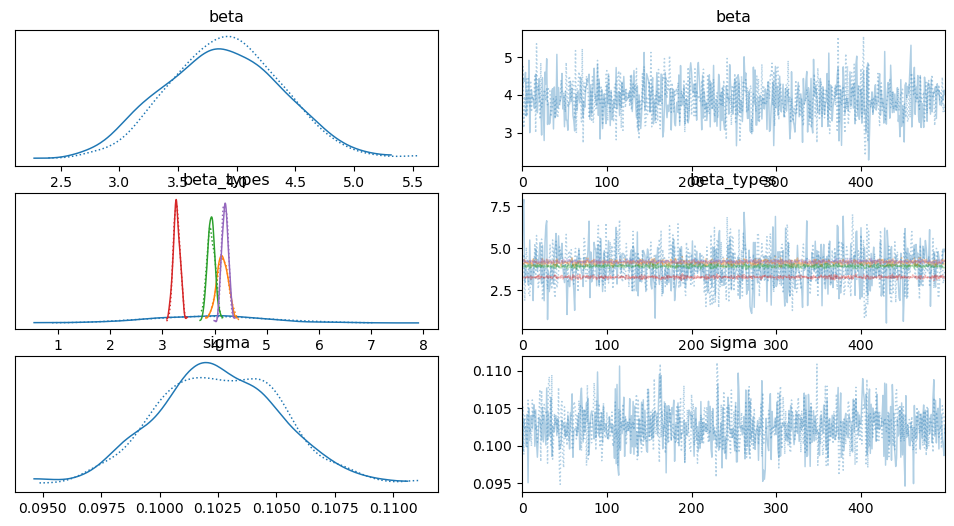

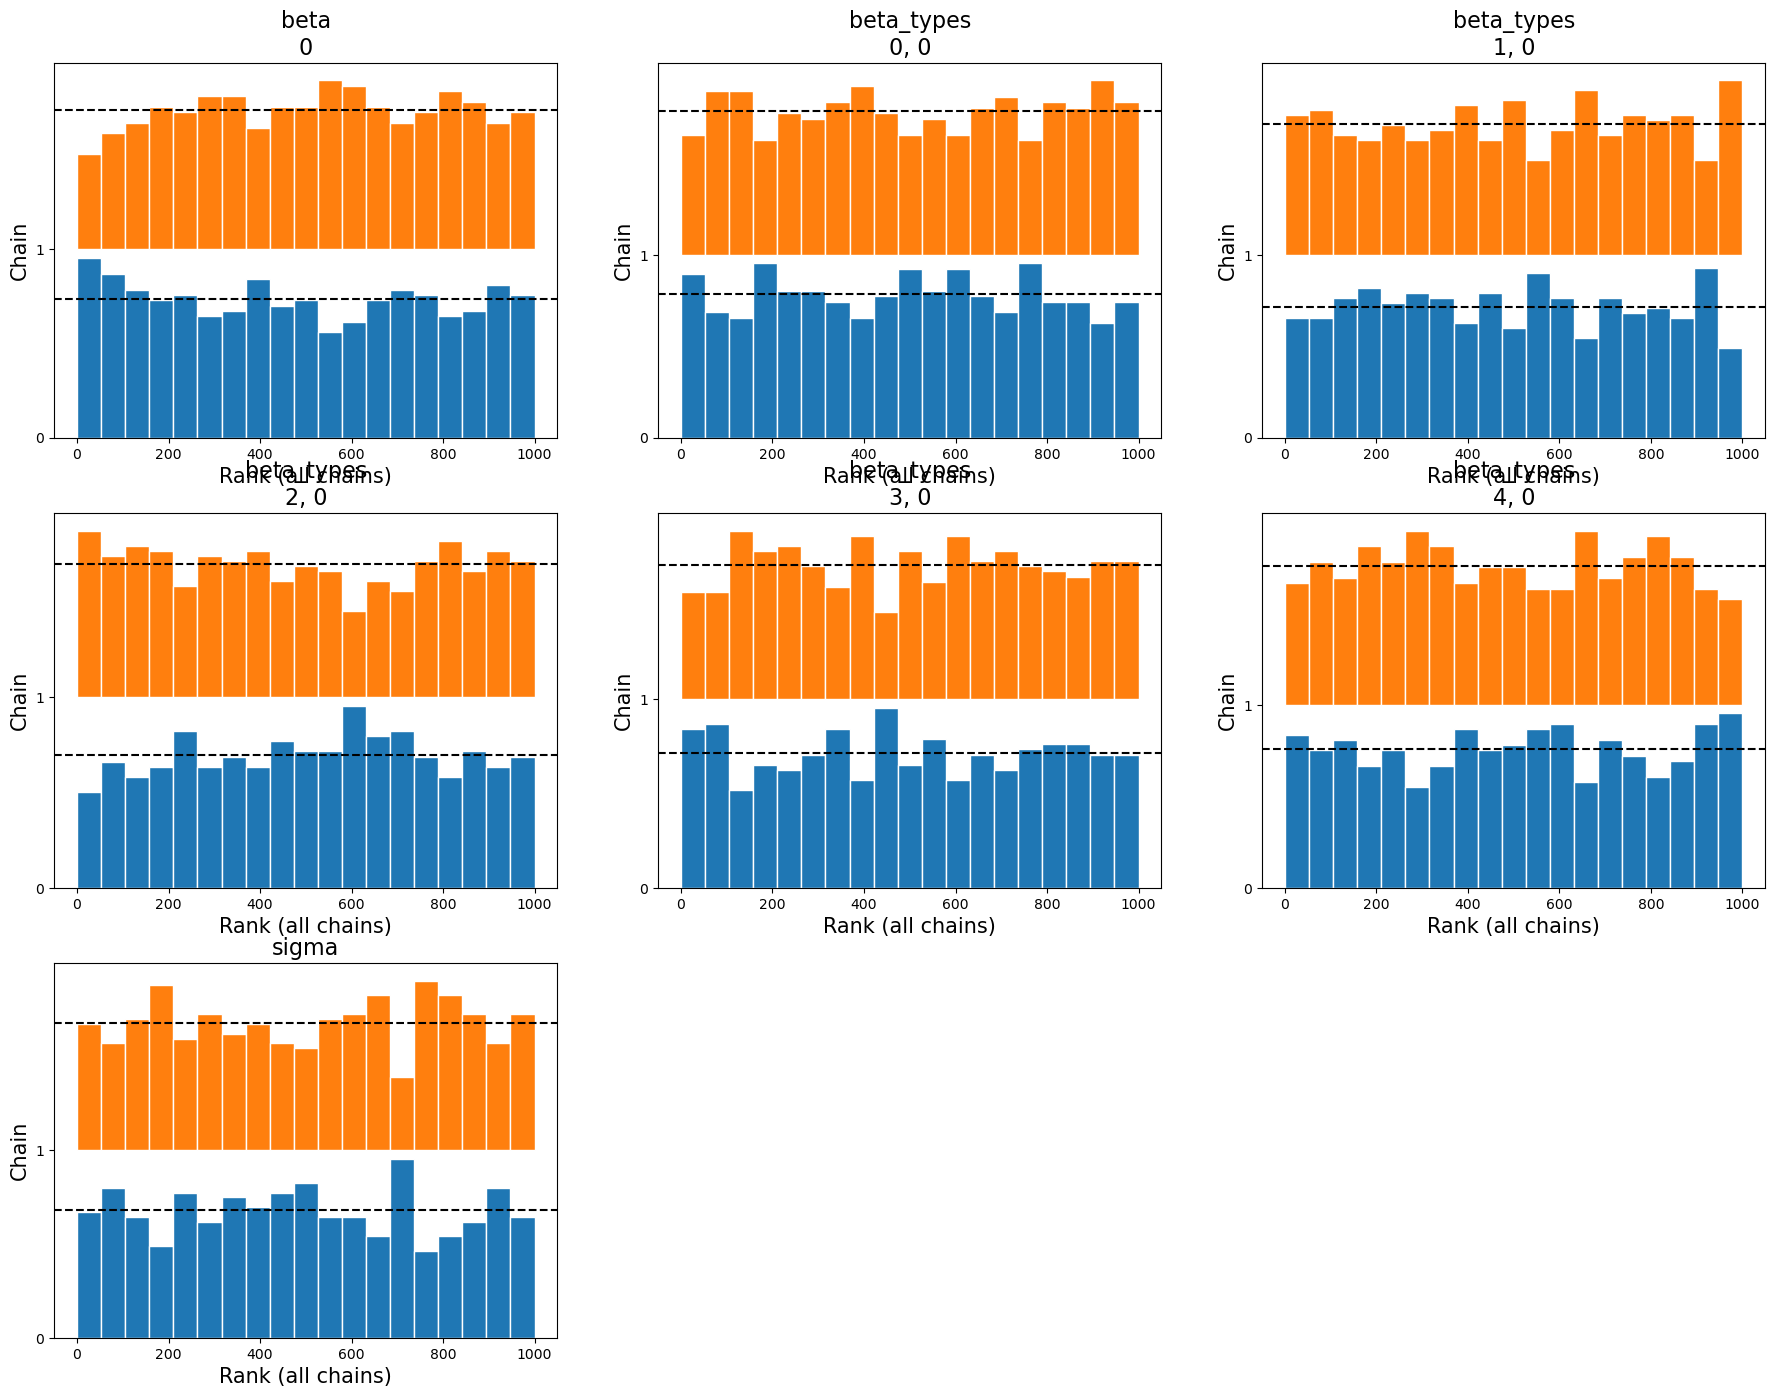

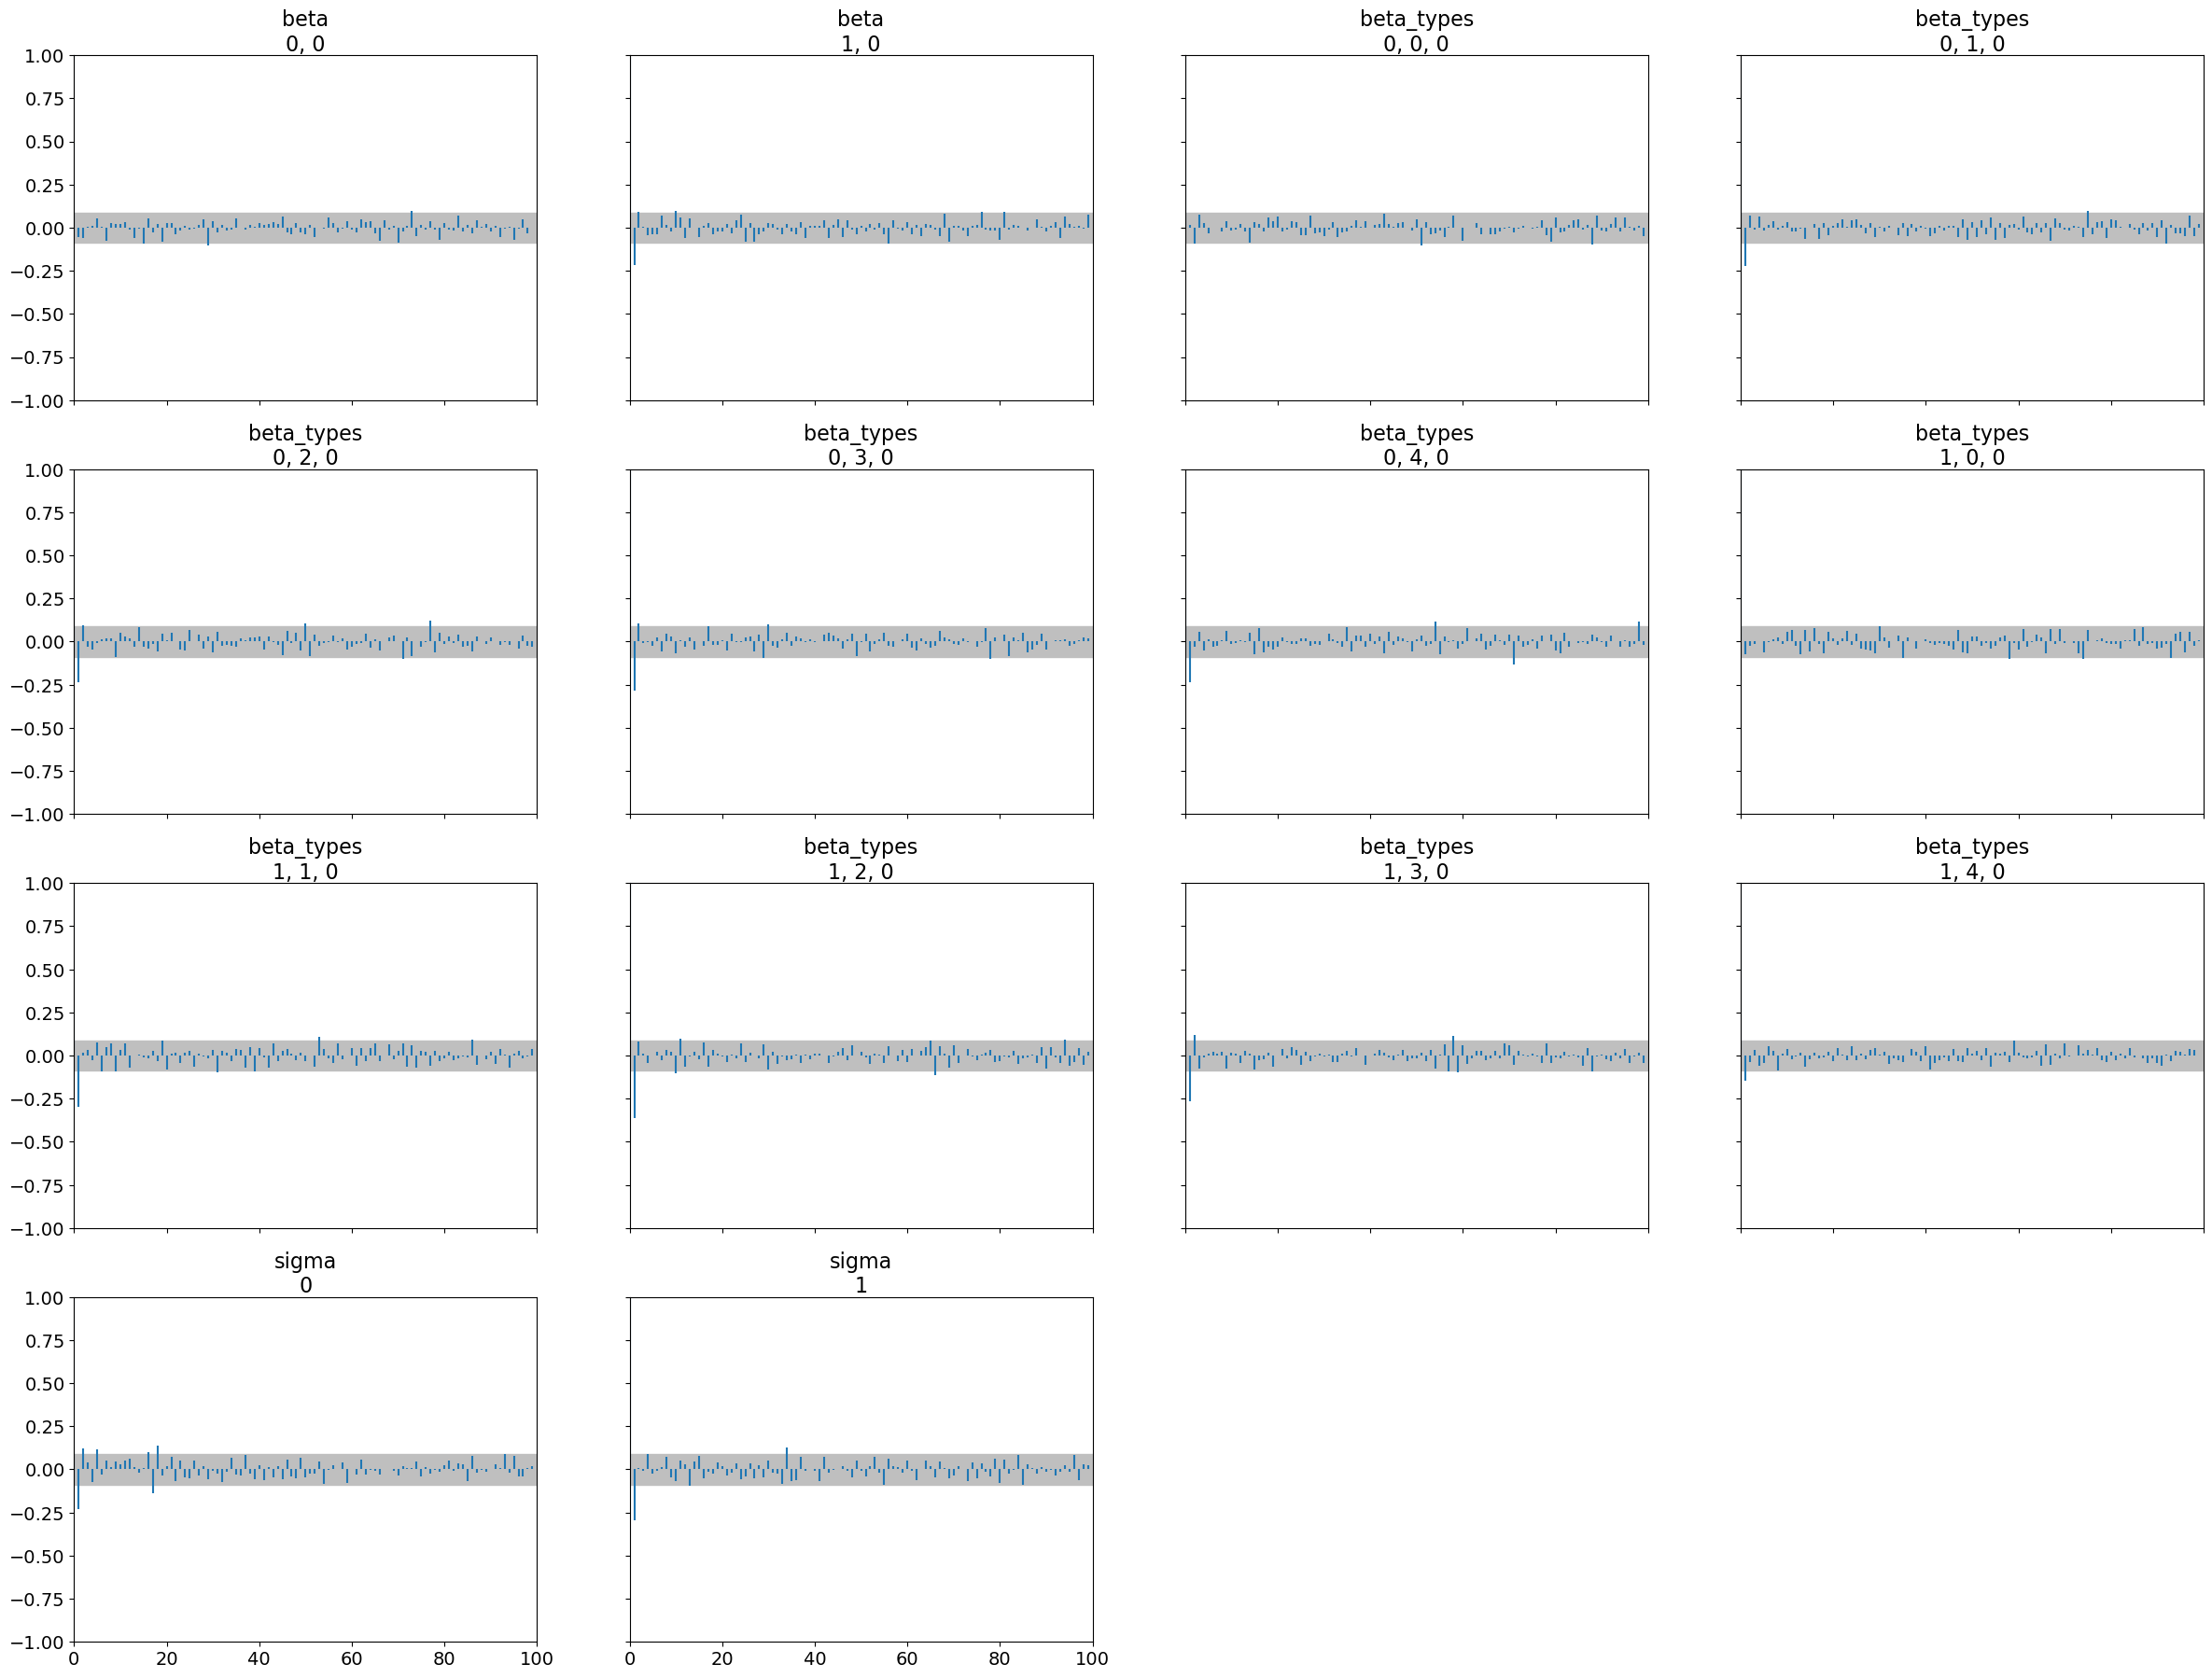

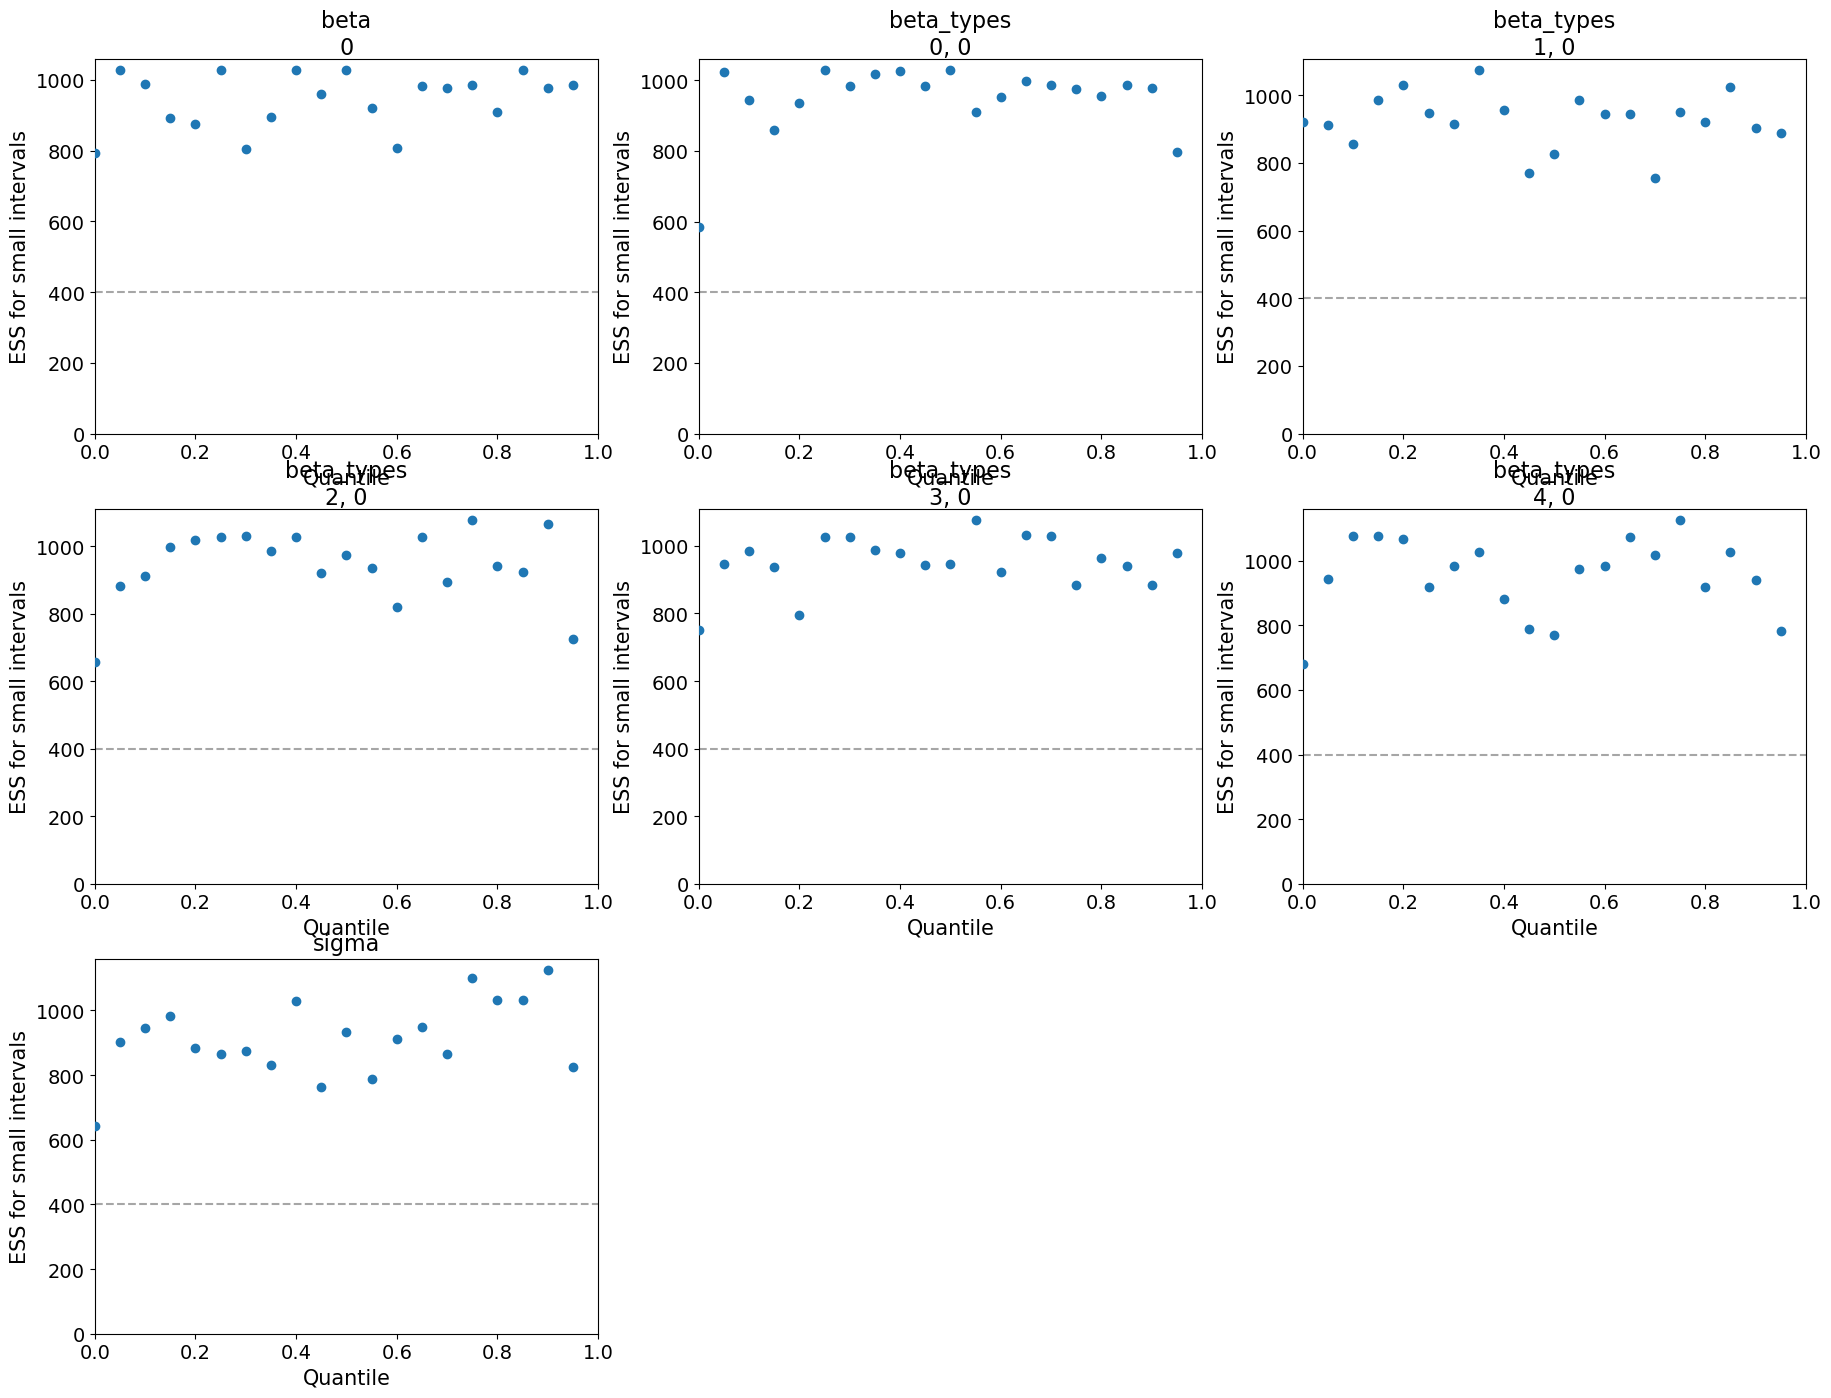

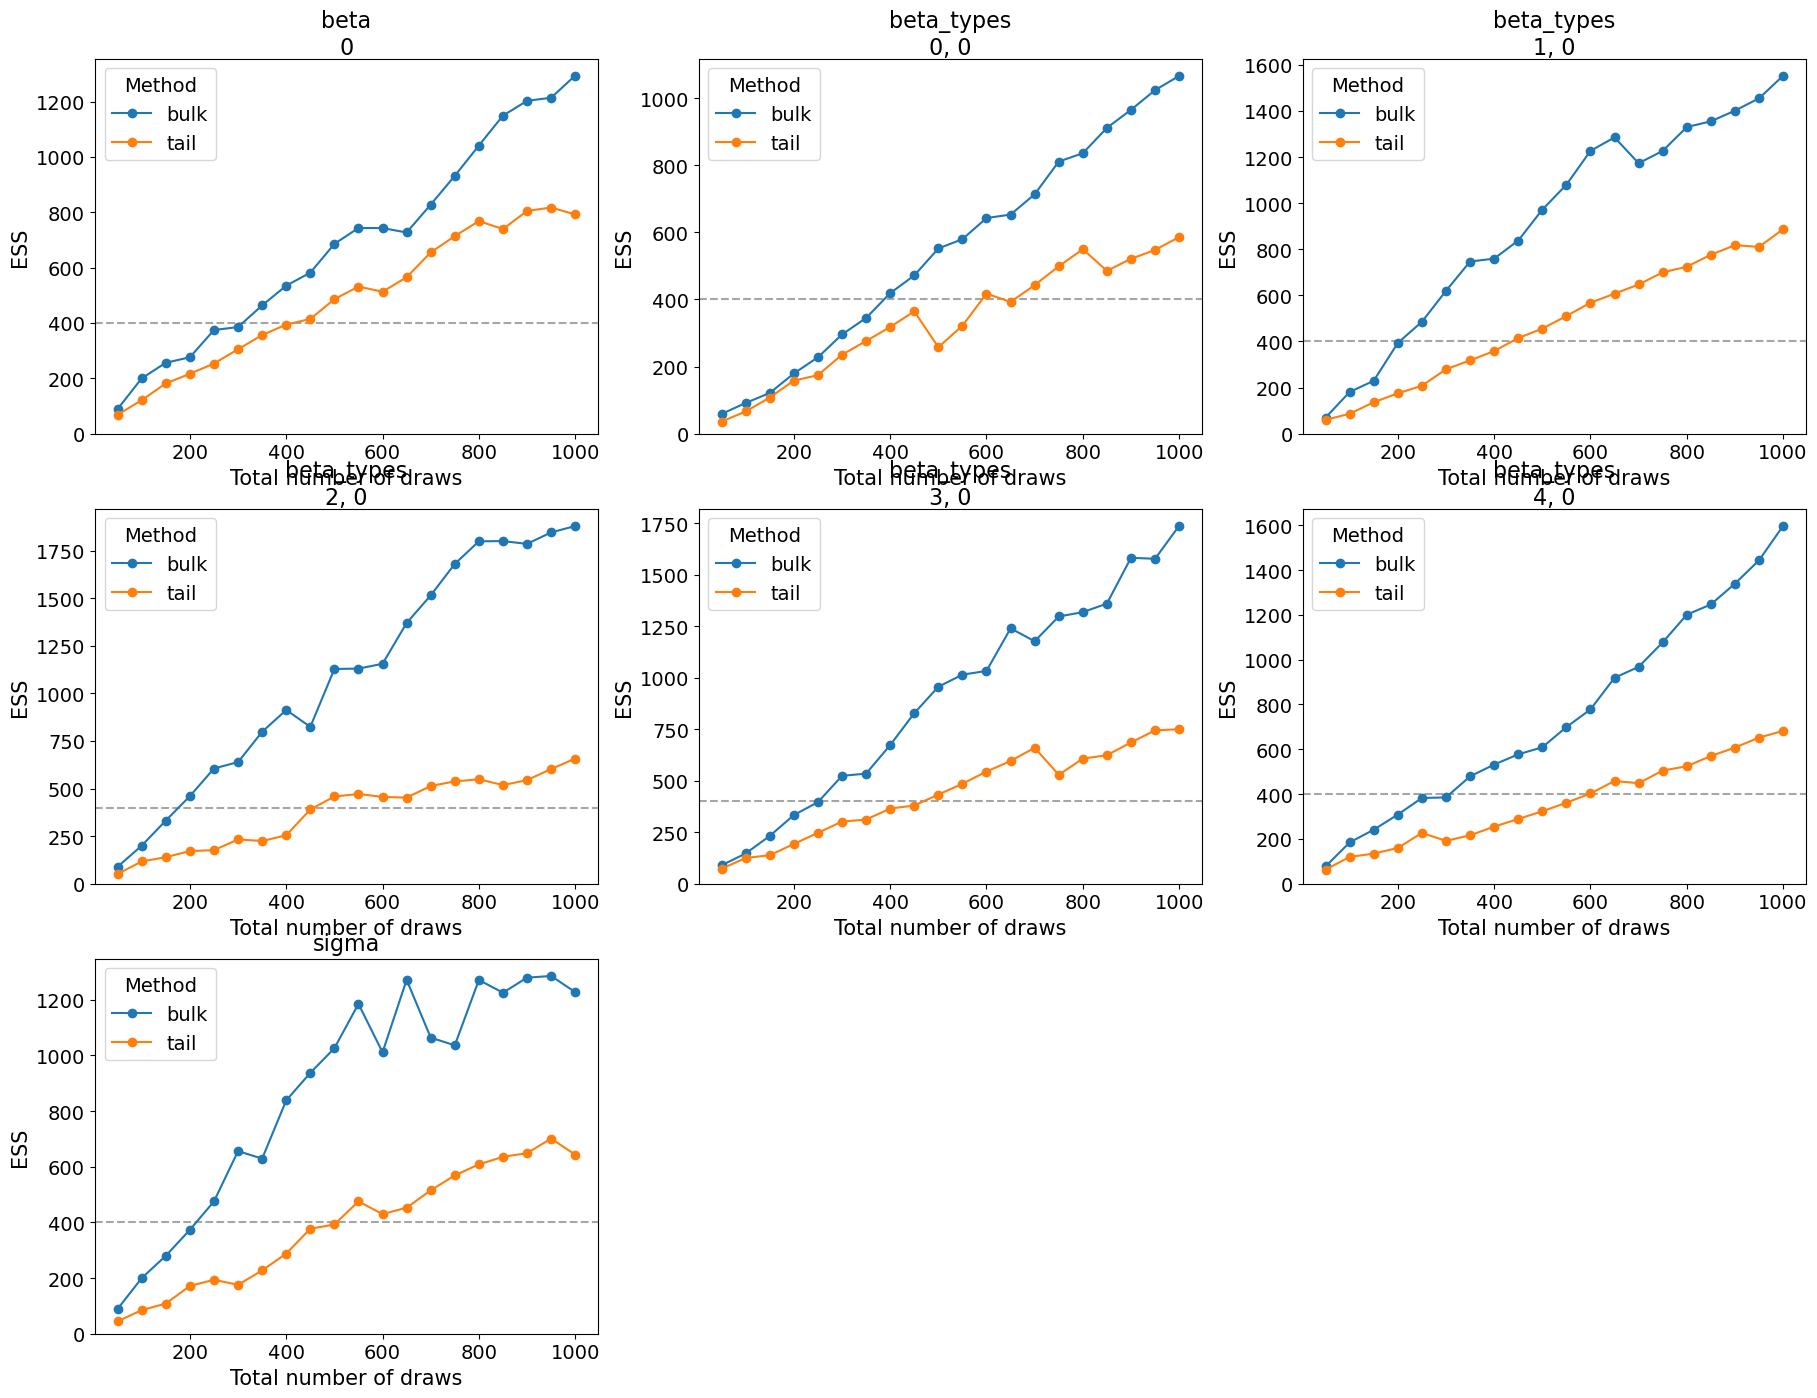

IS THE MODEL GOOD?


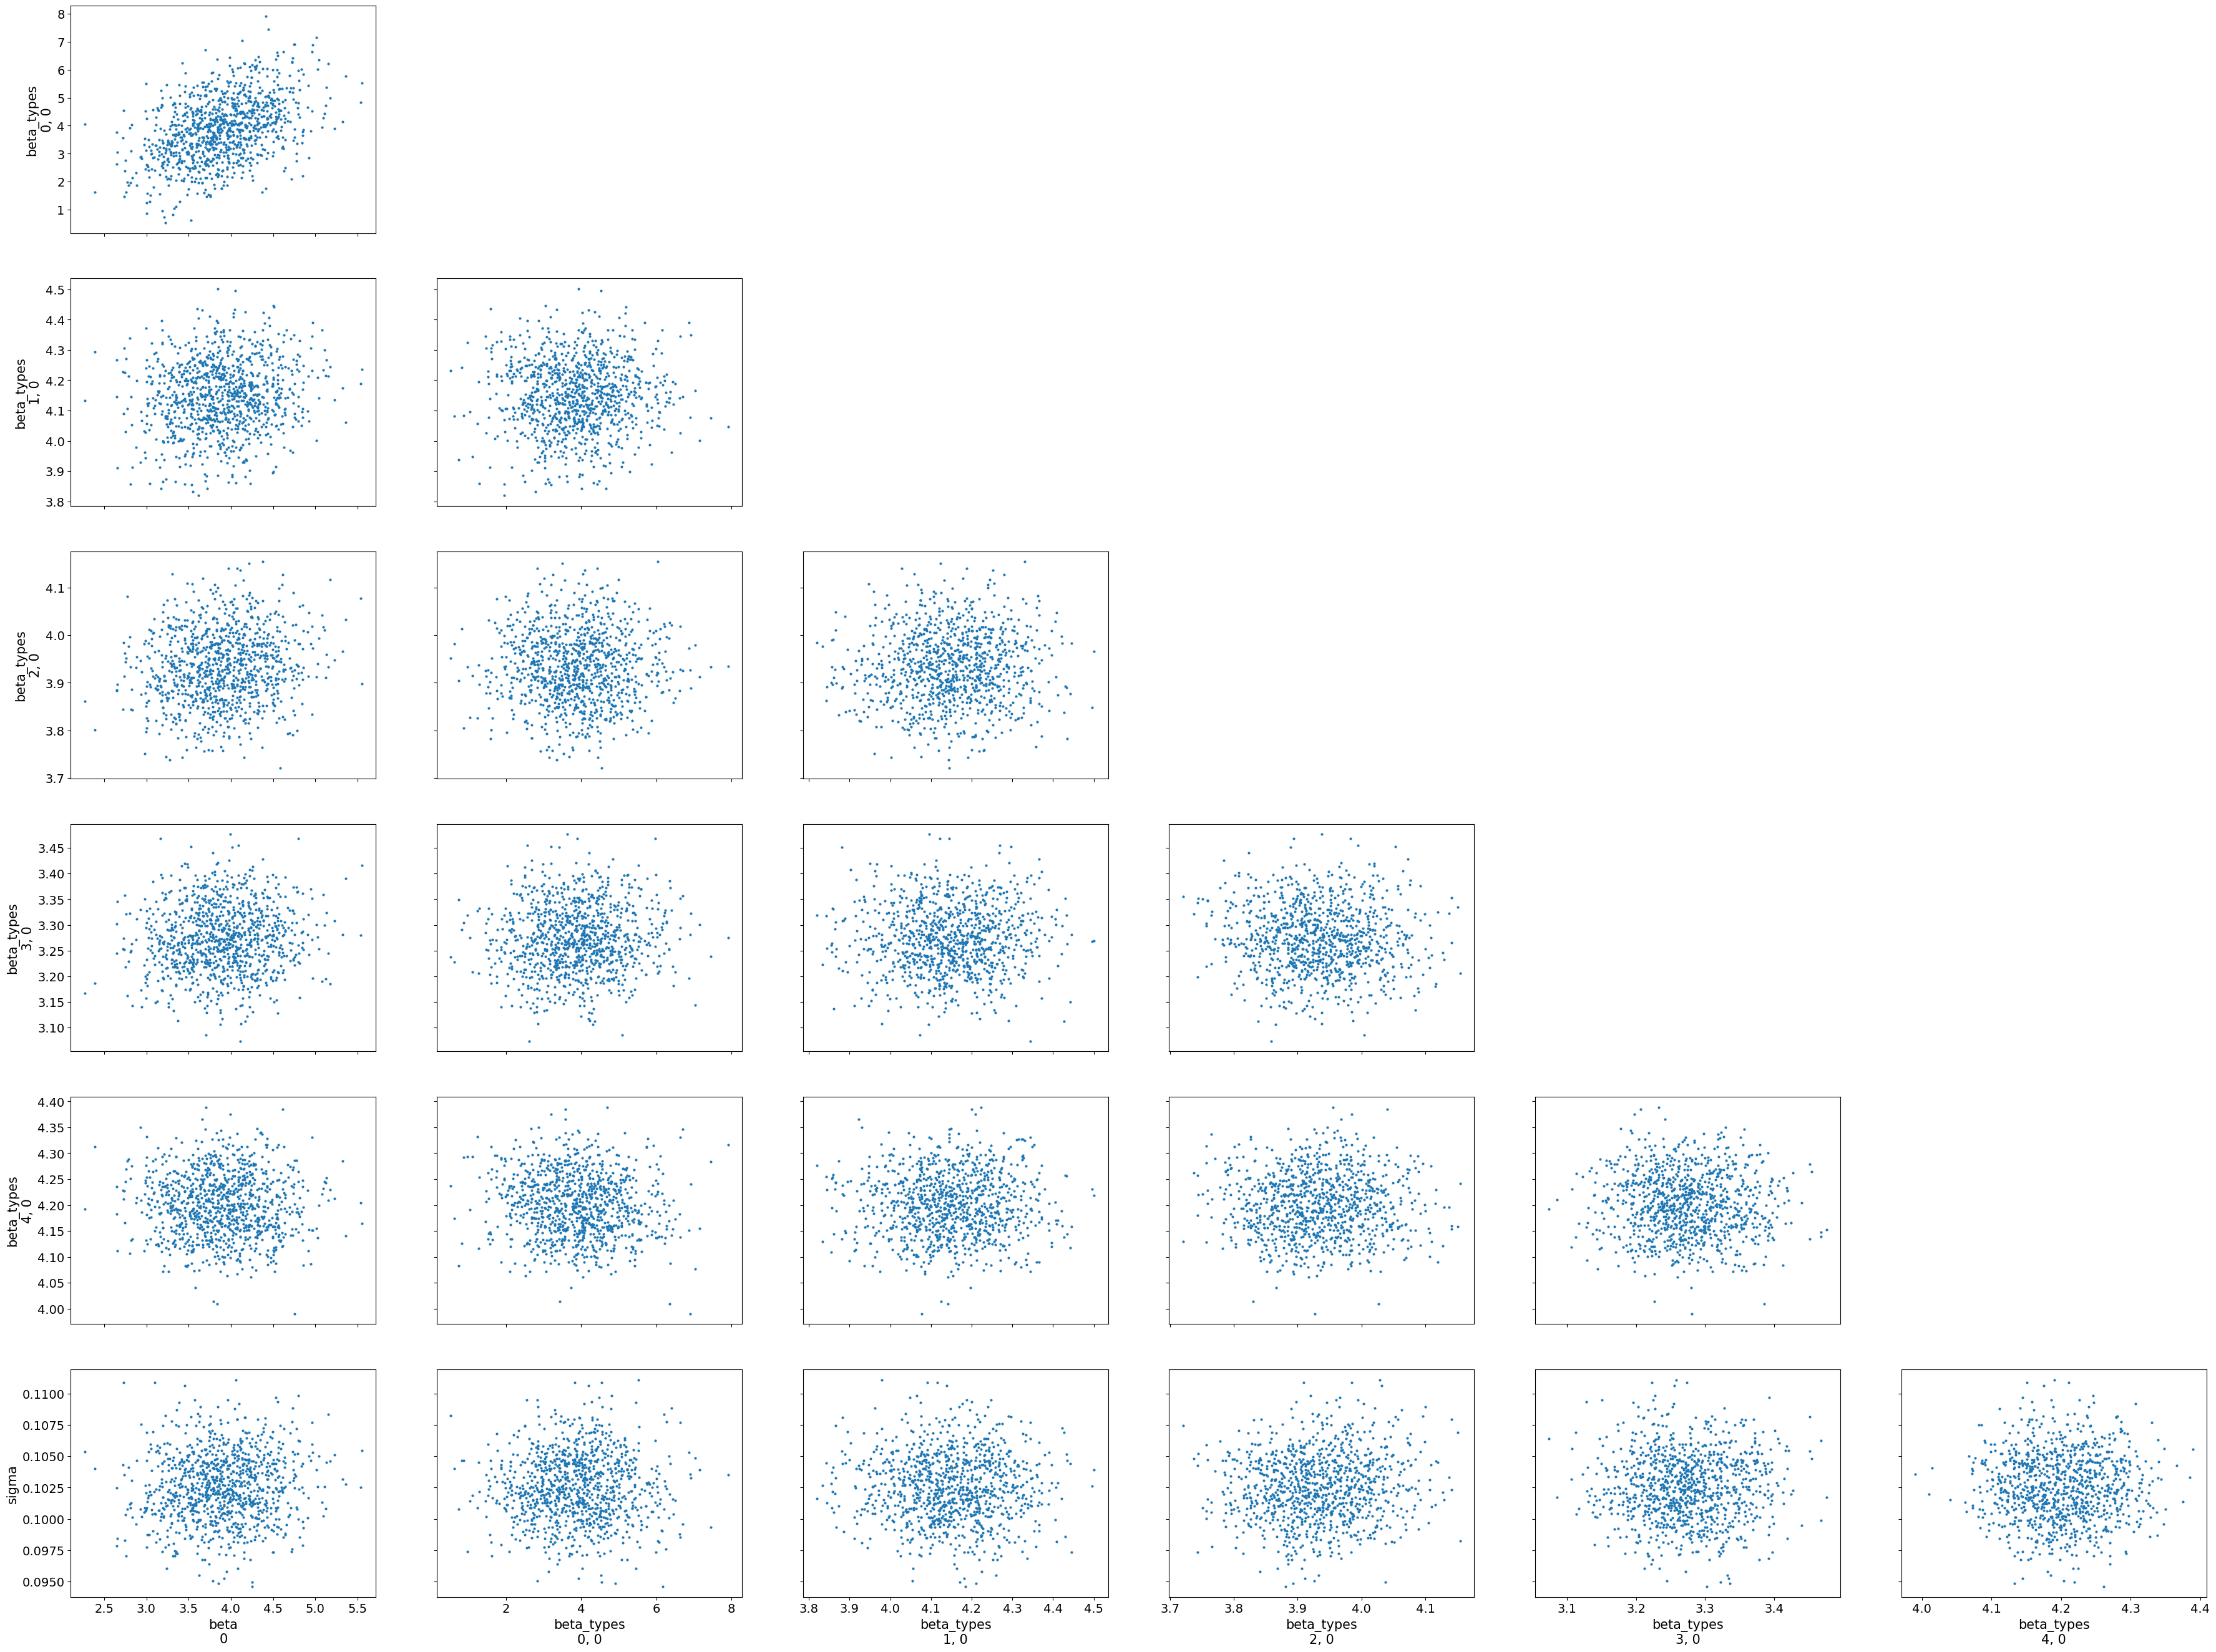

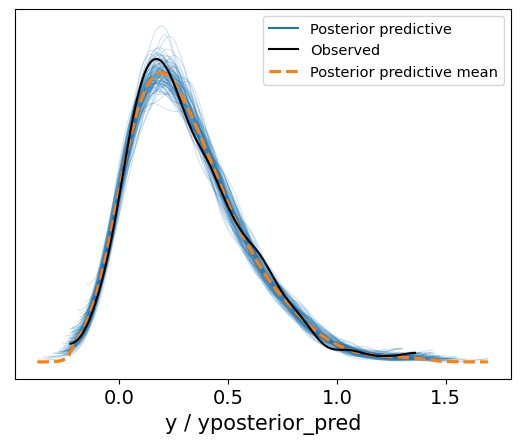

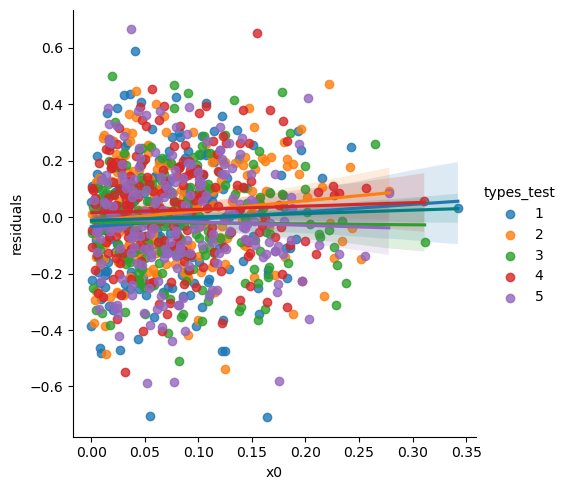

              y_test  y_test_predictions
types_test                              
1           0.267311            0.281974
2           0.356908            0.341123
3           0.312154            0.332125
4           0.286552            0.261665
5           0.333454            0.349218
WHAT ARE THE RESULTS?


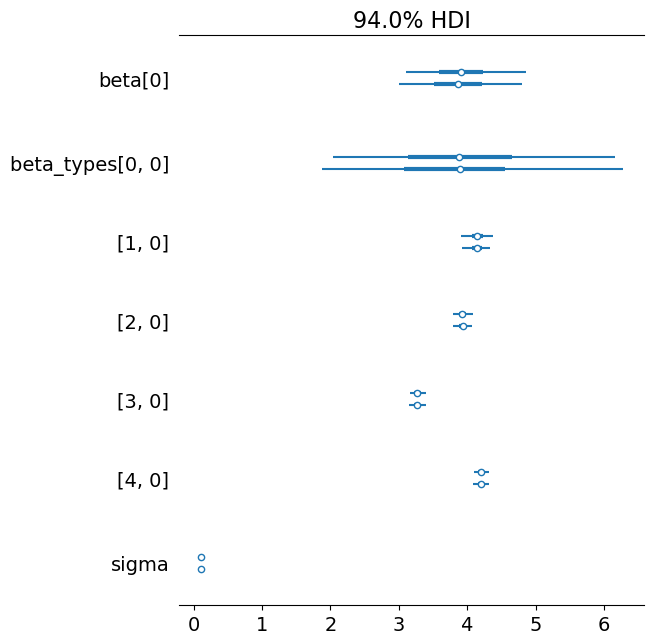

In [61]:
plot_stuff_about_model(idata, stan_data, fit, var_names = ['beta', 'beta_types', 'sigma'])

# Directly incrementing "target" in Stan --- this is equivalent to the first model that we built

In [63]:
stan_data = draw_samples_from_model(betas_k, number_datapoints_per_location)
stan_folder = 'stan_code/'
stan_file = stan_folder + 'linear_regression_withinformativeprior_usingtarget.stan'
with open(stan_file) as file:
    model_code = file.read()
print(model_code)

data {
    int<lower=0> N;
    int<lower=0> N_test;
    int<lower=1> Nattr; // number of covariates
    matrix[N,Nattr] X;  
    matrix[N_test,Nattr] X_test;  
    array[N] real y;
    }

parameters {
    vector[Nattr] beta;  // attribute effects
    real <lower=0> sigma; // standard deviation of the noise
}
model {
    // beta ~ normal(0, 10);
    target += normal_lpdf(beta | 0, 10); #equiv to the above line

    // sigma ~ normal(0, 10);
    target += normal_lpdf(sigma | 0, 10); #equiv to the above line

    // y ~ normal(X*beta, sigma);
    target += normal_lpdf(y | X*beta, sigma); #equiv to the above line

    // The target syntax directly adds the log density to the target, which is used for the MCMC sampling.
    // Note: you can use the target syntax to construct fancier models, like you will need for the zero-inflated model in the homework. 
    // See https://mc-stan.org/docs/stan-users-guide/zero-inflated.html for more examples. 
}

generated quantities {
    # this is drawin

In [64]:
compiled_model = stan.build(model_code, data=stan_data, random_seed=1)
fit = compiled_model.sample(num_chains=2, num_warmup = 200, num_samples= 1000)
idata = idata = get_arviz_data(fit, compiled_model = compiled_model, model_data = stan_data)
summary = az.summary(fit, var_names = ['beta', 'sigma'])
summary

Building...

In file included from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/boost/multi_array/multi_array_ref.hpp:32,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/boost/multi_array.hpp:34,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/boost/numeric/odeint/algebra/multi_array_algebra.hpp:22,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/boost/numeric/odeint.hpp:63,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/ode_rk45.hpp:9,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/integrate_ode_rk45.hpp:6,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor.hpp:14,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include


Building: 20.0s, done.Messages from stanc:
Warning in '/tmp/httpstan_hnpno4x6/model_4byk7xwl.stan', line 16, column 41: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
Warning in '/tmp/httpstan_hnpno4x6/model_4byk7xwl.stan', line 19, column 42: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
Warning in '/tmp/httpstan_hnpno4x6/model_4byk7xwl.stan', line 22, column 46: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
Warning in '/tmp/httpstan_hnpno4x6/model_4byk7xwl.stan', line 30, column 4: Comments
    beginning with # are deprecated and thi

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]  4.169  0.039   4.101    4.244      0.001    0.001    1582.0   
sigma    0.103  0.003   0.099    0.109      0.000    0.000    1734.0   

         ess_tail  r_hat  
beta[0]    1267.0    1.0  
sigma      1210.0    1.0

In [65]:
# ground truth:
betas_k, sigma

(array([[4.26359161],
        [3.93536551],
        [3.91582342],
        [4.10026828],
        [4.52086749]]),
 0.1)

CONVERGENCE CHECKS


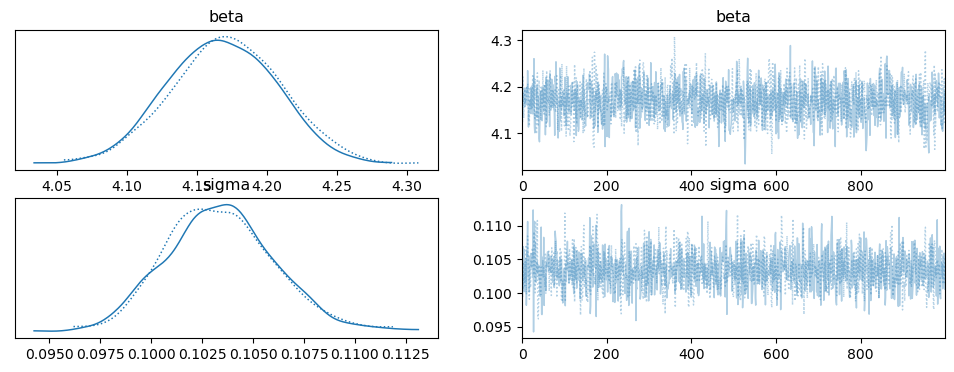

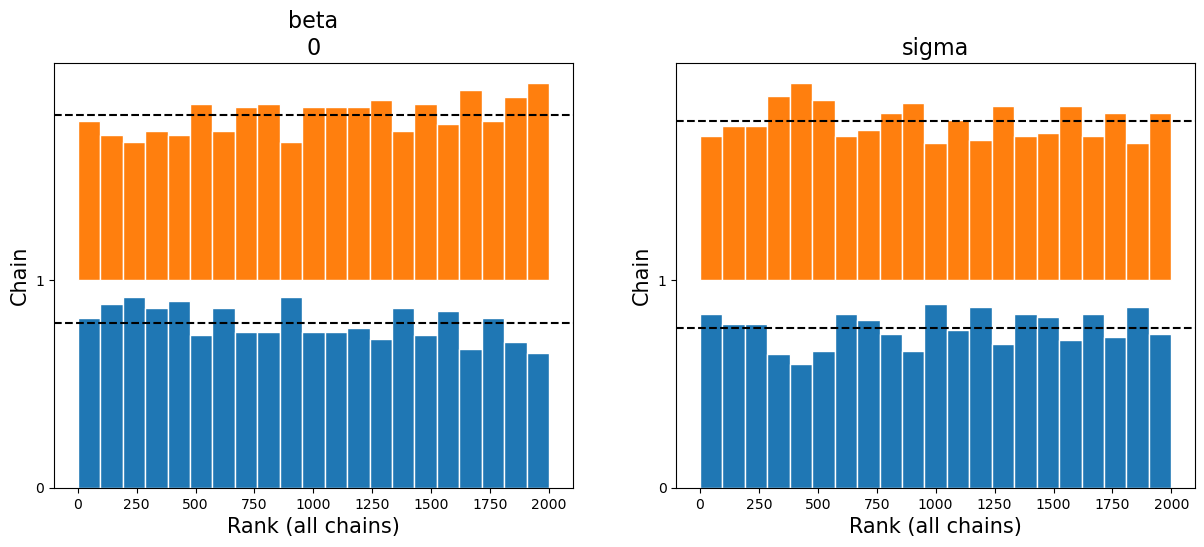

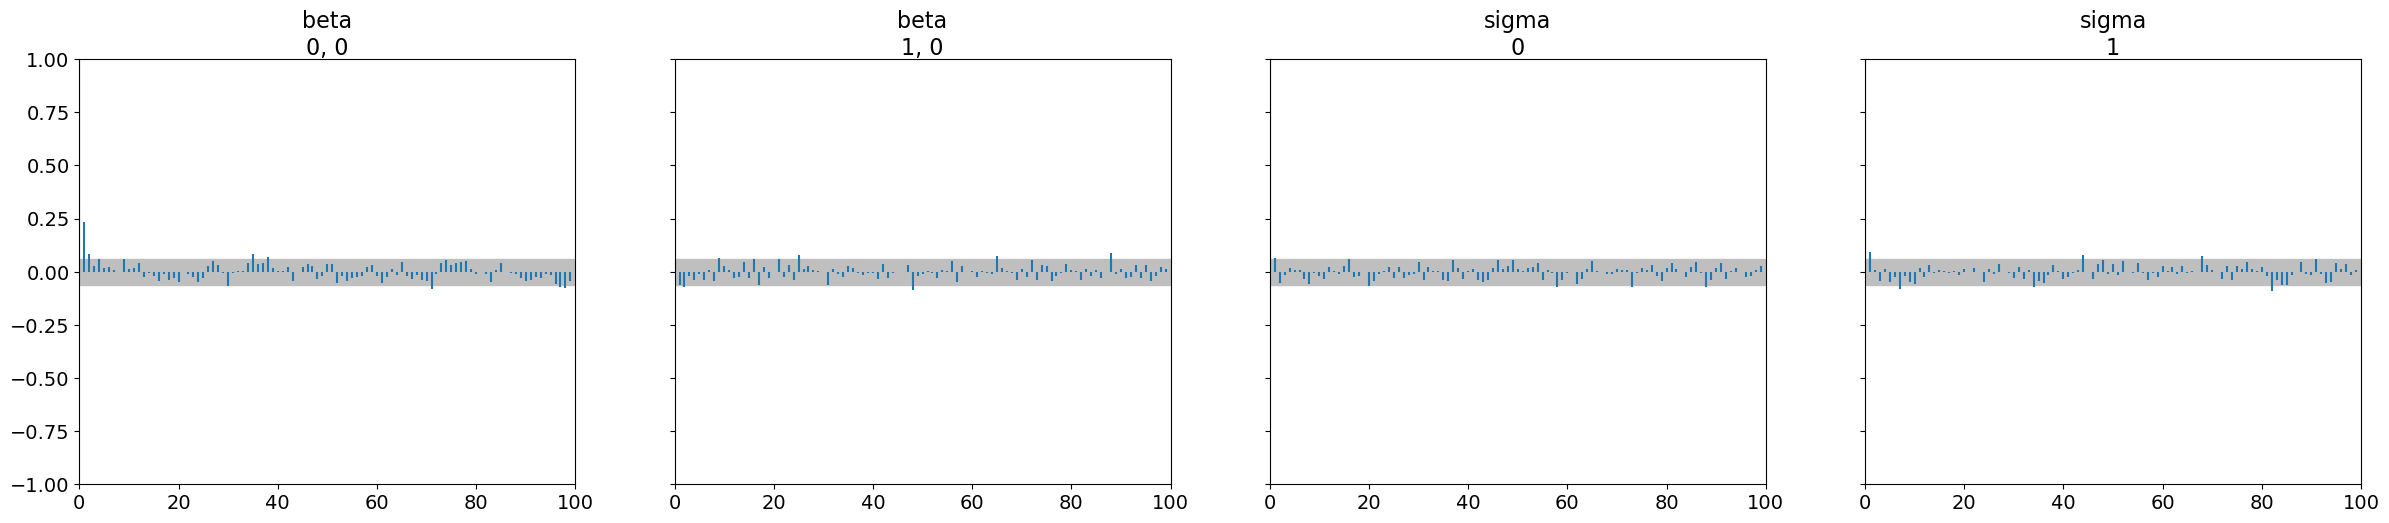

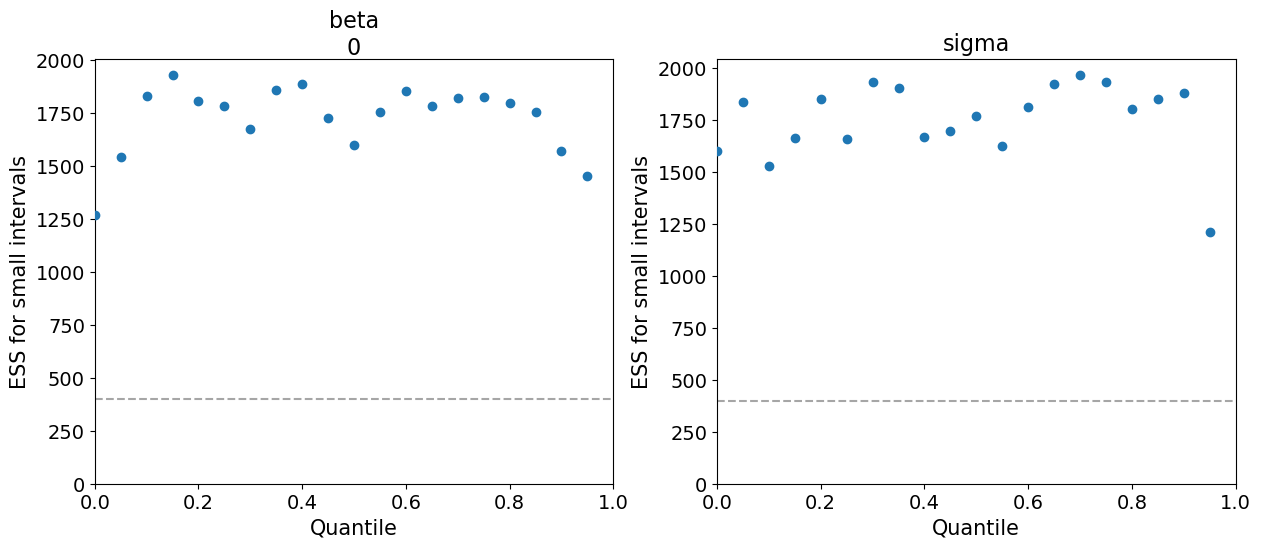

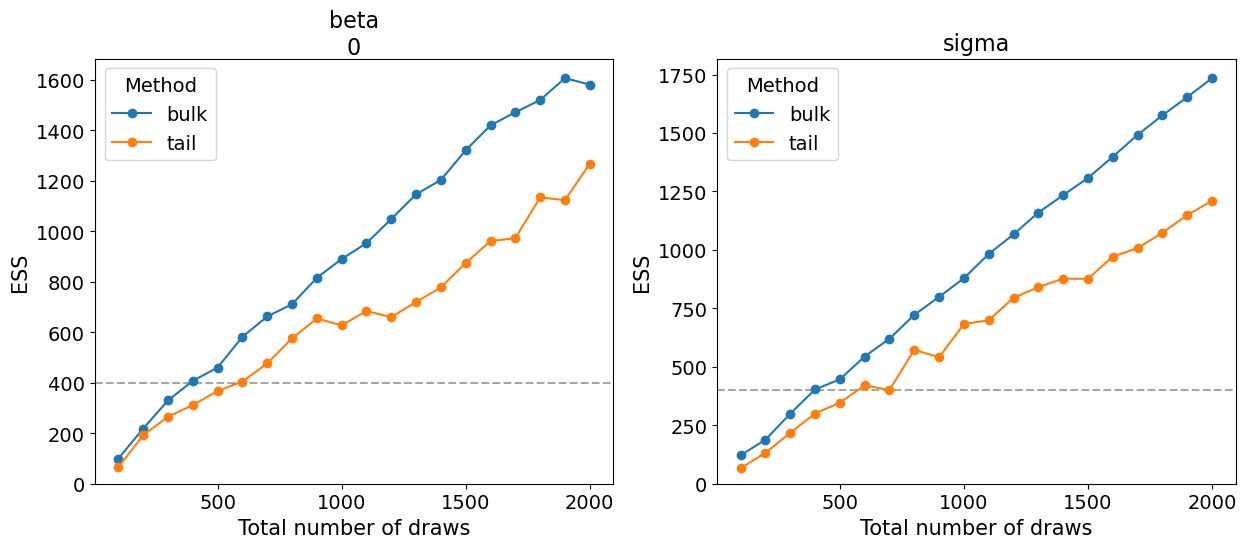

IS THE MODEL GOOD?


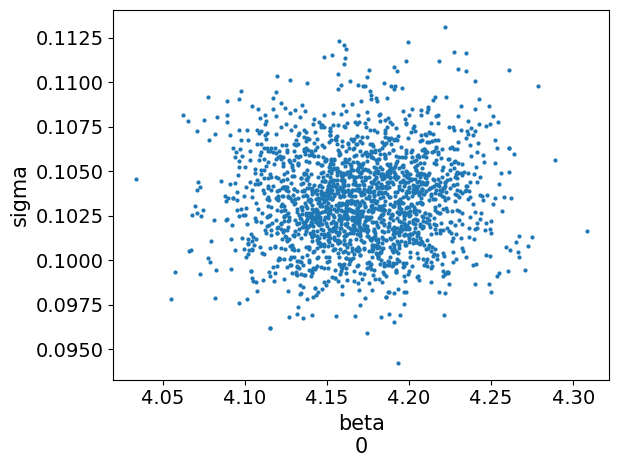

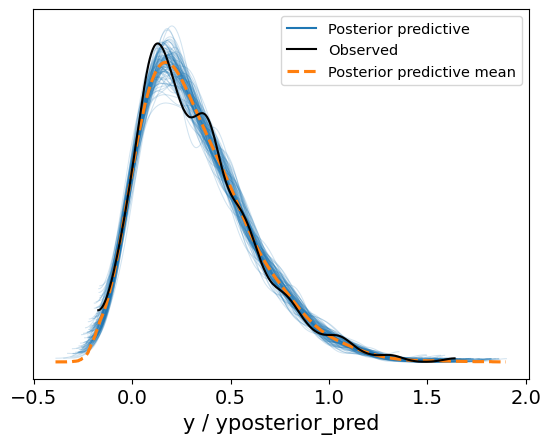

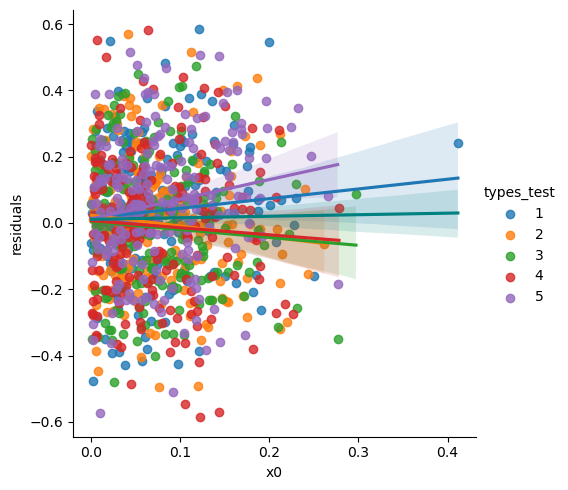

              y_test  y_test_predictions
types_test                              
1           0.352697            0.315785
2           0.325235            0.327567
3           0.300239            0.314394
4           0.289756            0.298206
5           0.398659            0.338191
WHAT ARE THE RESULTS?


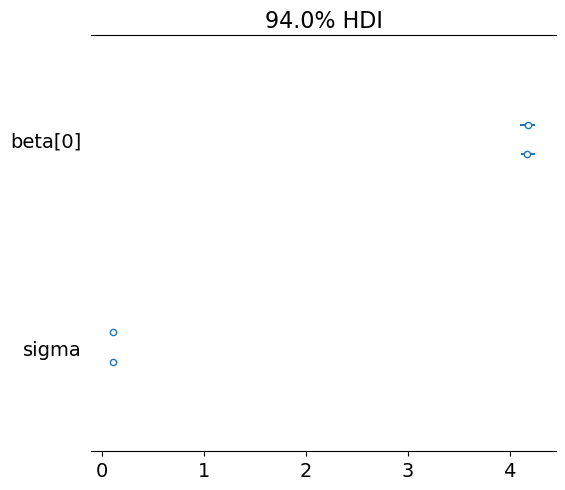

In [66]:
plot_stuff_about_model(idata, stan_data, fit)